<span style="color:blue">**Description**</span>

<span style="color:red">*Problem Statement*</span>

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In [1]:
#Supress Warnings
import warnings
warnings.filterwarnings('ignore')

<span style="color:blue">**Library Imports**</span>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline


In [3]:
##Defining a function for coloring NaN and Non-NaN values, Highlights values for visual emphasis in data presentation.
def color_style(value):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for value 
    greater than 5% NaNs, and green for safer values 
    and black for anything otherwise.
    """
    if value>0:
        color= 'red'
    elif value==0:
        color='green'
    else:
        color='black'
    return 'color: %s' % color

In [4]:
##Defining a function for missing value percentage dataframe: null_prcnt_df
def null_prcnt_df(data):
    df= data.copy()
    missing = pd.DataFrame(100*df.isnull().sum()/len(df.index))
    missing.rename(columns={0:'Null_Percentage'}, inplace=True)
    missing = pd.DataFrame(missing.Null_Percentage).sort_values(by='Null_Percentage',ascending=False).style.applymap(color_style)
    return missing

In [5]:
##Function to display content in 'bold' within print statement
from IPython.display import Markdown, display
def printbold(string):   
    return display(Markdown(string))

<span style="color:blue">**Step 1: Reading and Understanding the Data**</span>

In [6]:
##Read the dataset
telecom_df = pd.read_csv('train.csv')
telecom_df.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...            0            0        NaN        NaN        NaN   
1  122.787  ...            0            0        NaN        1.0        NaN   
2  103.176  ...            0            0        NaN        NaN        NaN   
3  205.260  ...            0            0        NaN        NaN        NaN   
4  128.191  ...            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
0  1958         0.0         0.0         0.0                  0  
1   710         0.0         0.0         0.0                  0  
2   882         0.0         0.0         0.0                  0  
3   982         0.0         0.0         0.0                  0  
4   647         0.0         0.0         0.0                  0  

[5 rows x 172 columns]

In [7]:
##Creating a copy of the data incase it is required later
telecom_df_orig = telecom_df.copy()

In [8]:
##Check number of records and feature columns: 99999 records and 226 columns
telecom_df.shape

(69999, 172)

In [9]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [10]:
telecom_df.columns

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=172)

In [11]:
telecom_df.describe()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count  69999.000000    69999.0         69297.0         69297.0   
mean   34999.000000      109.0             0.0             0.0   
std    20207.115084        0.0             0.0             0.0   
min        0.000000      109.0             0.0             0.0   
25%    17499.500000      109.0             0.0             0.0   
50%    34999.000000      109.0             0.0             0.0   
75%    52498.500000      109.0             0.0             0.0   
max    69998.000000      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count         69297.0  69999.000000  69999.000000  69999.000000  67231.000000   
mean              0.0    283.134365    278.185912    278.858826    133.153275   
std               0.0    334.213918    344.366927    351.924315    299.963093   
min               0.0  -2258.709000  -1289.715000   -945.808000      0.000000   
25%               0.0     93.581000     86.714000     84.095000      7.410000   
50%               0.0    197.484000    191.588000    192.234000     34.110000   
75%               0.0    370.791000    365.369500    369.909000    119.390000   
max               0.0  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7  ...   sachet_3g_7   sachet_3g_8     fb_user_6  \
count  67312.000000  ...  69999.000000  69999.000000  17568.000000   
mean     133.894438  ...      0.081444      0.085487      0.916325   
std      311.277193  ...      0.634547      0.680035      0.276907   
min        0.000000  ...      0.000000      0.000000      0.000000   
25%        6.675000  ...      0.000000      0.000000      1.000000   
50%       32.280000  ...      0.000000      0.000000      1.000000   
75%      115.837500  ...      0.000000      0.000000      1.000000   
max     8157.780000  ...     33.000000     41.000000      1.000000   

          fb_user_7     fb_user_8           aon    aug_vbc_3g    jul_vbc_3g  \
count  17865.000000  18417.000000  69999.000000  69999.000000  69999.000000   
mean       0.909544      0.890319   1220.639709     68.108597     65.935830   
std        0.286842      0.312501    952.426321    269.328659    267.899034   
min        0.000000      0.000000    180.000000      0.000000      0.000000   
25%        1.000000      1.000000    468.000000      0.000000      0.000000   
50%        1.000000      1.000000    868.000000      0.000000      0.000000   
75%        1.000000      1.000000   1813.000000      0.000000      0.000000   
max        1.000000      1.000000   4337.000000  12916.220000   9165.600000   

        jun_vbc_3g  churn_probability  
count  69999.00000       69999.000000  
mean      60.07674           0.101887  
std      257.22681           0.302502  
min        0.00000           0.000000  
25%        0.00000           0.000000  
50%        0.00000           0.000000  
75%        0.00000           0.000000  
max    11166.21000           1.000000  

[8 rows x 163 columns]

In [12]:
##Check null values in entire df
null_prcnt_df(telecom_df)

<span style="color:blue">**Step 2: Data Cleaning and Manipulation**</span>

In [13]:
##Stripping off white_spaces from the column name(if any)
telecom_df = telecom_df.rename(columns= lambda x: x.strip(), inplace=False)

In [14]:
##Checking and dropping duplicated records(if any)
telecom_df = telecom_df.drop_duplicates()

In [15]:
telecom_df.shape

(69999, 172)

In [16]:
##List of Incorrect name columns (as data dictionary says RECH: Recharge)
last_day_rech_cols = list(telecom_df.columns[telecom_df.columns.str.contains('last_day_rch_amt')])
last_day_rech_cols

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']

In [17]:
##Correcting name of 'last_day_rch_amt_*' to 'last_day_rech_amt_*' columns (for months 6,7,and 8)
telecom_df = telecom_df.rename(columns= {'last_day_rch_amt_6':'last_day_rech_amt_6', 'last_day_rch_amt_7':'last_day_rech_amt_7',\
                                     'last_day_rch_amt_8':'last_day_rech_amt_8'})
correct_last_day_rech_amt_cols = list(telecom_df.columns[telecom_df.columns.str.contains('last_day')])
correct_last_day_rech_amt_cols

['last_day_rech_amt_6', 'last_day_rech_amt_7', 'last_day_rech_amt_8']

In [18]:
##Columns containing recharge amount 'rech_amt' or recharge data 'rech_data' details
rech_amt_data_cols = telecom_df.columns[telecom_df.columns.str.contains('rech_amt|rech_data', regex=True)]
rech_amt_data_cols

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'last_day_rech_amt_6', 'last_day_rech_amt_7', 'last_day_rech_amt_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
       'av_rech_amt_data_8'],
      dtype='object')

> **Observation:** The above mentioned columns correspond to `'rech_amt'` and `'rech_data'` features across months 6, 7 and 8 respectively:

>(i) Total recharge amount (calling)

>(ii) Maximum recharge amount (calling)

>(iii) Last day recharge amount

>(iv) Last date of Recharging the data

>(v) Total recharge for data

>(vi) Maximum recharge for data

>(vii) Average recharge amount for data

In [19]:
##Check null values in above mentioned columns, if any(column wise: missing value percentage)
rech_amt_data_df = telecom_df[rech_amt_data_cols]
null_prcnt_df(rech_amt_data_df)

**Observation**: Among the `'rech_amt'` and `'rech_data'` features, all the data features have around 74% missing values whereas the calling based recharge features have no missing values.

In [20]:
##Check stats of these columns in the dataframe
rech_amt_data_df.describe()

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  \
count      69999.000000      69999.000000      69999.000000    69999.000000   
mean         328.139788        322.376363        323.846355      104.569265   
std          404.211068        411.070120        426.181405      121.407701   
min            0.000000          0.000000          0.000000        0.000000   
25%          110.000000        100.000000         90.000000       30.000000   
50%          229.000000        220.000000        225.000000      110.000000   
75%          438.000000        430.000000        436.000000      120.000000   
max        35190.000000      40335.000000      45320.000000     4010.000000   

       max_rech_amt_7  max_rech_amt_8  last_day_rech_amt_6  \
count    69999.000000    69999.000000         69999.000000   
mean       104.137573      107.540351            63.426949   
std        120.782543      124.396750            97.954876   
min          0.000000        0.000000             0.000000   
25%         30.000000       30.000000             0.000000   
50%        110.000000       98.000000            30.000000   
75%        128.000000      144.000000           110.000000   
max       3299.000000     4449.000000          4010.000000   

       last_day_rech_amt_7  last_day_rech_amt_8  total_rech_data_6  \
count         69999.000000         69999.000000       17568.000000   
mean             59.294218            62.489478           2.467612   
std              95.429492           101.996729           2.794610   
min               0.000000             0.000000           1.000000   
25%               0.000000             0.000000           1.000000   
50%              30.000000            30.000000           1.000000   
75%             110.000000           130.000000           3.000000   
max            3100.000000          4449.000000          61.000000   

       total_rech_data_7  total_rech_data_8  max_rech_data_6  max_rech_data_7  \
count       17865.000000       18417.000000     17568.000000     17865.000000   
mean            2.679989           2.652441       126.500000       126.402071   
std             3.073472           3.101265       109.352573       109.459266   
min             1.000000           1.000000         1.000000         1.000000   
25%             1.000000           1.000000        25.000000        25.000000   
50%             2.000000           1.000000       145.000000       145.000000   
75%             3.000000           3.000000       177.000000       177.000000   
max            54.000000          60.000000      1555.000000      1555.000000   

       max_rech_data_8  av_rech_amt_data_6  av_rech_amt_data_7  \
count     18417.000000        17568.000000        17865.000000   
mean        125.374925          192.831096          201.455940   
std         109.648799          190.623115          198.346141   
min           1.000000            1.000000            1.000000   
25%          25.000000           82.000000           92.000000   
50%         145.000000          154.000000          154.000000   
75%         179.000000          252.000000          252.000000   
max        1555.000000         5920.000000         4365.000000   

       av_rech_amt_data_8  
count        18417.000000  
mean           196.815792  
std            192.280532  
min              1.000000  
25%             84.000000  
50%            154.000000  
75%            252.000000  
max           4076.000000

**Observation**: For columns like `av_rech_amt_data_*` and `total_rech_data_*` (months) the minimum value is 1. Hence, we can impute the missing values by 0. (Considering there were no recharges done by the customer).



In [21]:
##Imputation of 'av_rech_amt_data_* and total_rech_data_*' column NaNs with 0 (for all the months 6, 7, 8)

telecom_df['av_rech_amt_data_6']= telecom_df['av_rech_amt_data_6'].fillna(0)
telecom_df['av_rech_amt_data_7']= telecom_df['av_rech_amt_data_7'].fillna(0)
telecom_df['av_rech_amt_data_8']= telecom_df['av_rech_amt_data_8'].fillna(0)


telecom_df['total_rech_data_6']= telecom_df['total_rech_data_6'].fillna(0)
telecom_df['total_rech_data_7']= telecom_df['total_rech_data_7'].fillna(0)
telecom_df['total_rech_data_8']= telecom_df['total_rech_data_8'].fillna(0)


In [22]:


##Calculating total data recharge amt for all the months 6, 7, 8 .
telecom_df['total_rech_data_amt_6'] = (telecom_df['av_rech_amt_data_6'] * telecom_df['total_rech_data_6']) 
telecom_df['total_rech_data_amt_7'] = (telecom_df['av_rech_amt_data_7'] * telecom_df['total_rech_data_7']) 
telecom_df['total_rech_data_amt_8'] = (telecom_df['av_rech_amt_data_8'] * telecom_df['total_rech_data_8'])

<span style="color:blue">**Step 3: EDA**</span>
1. Dealing with features with constant value (constant variance), dealing with datatypes and handling missing values for rest of the features, etc.

In [23]:
##Removing columns that show constant variance (i.e. all values are constant or 0)
def remove_single_val_uniq_col(df):
    df_newsingle = df.copy()
    
    uniq_svcol = df_newsingle.nunique() ==1
    list_uniq_svcol = list(uniq_svcol[uniq_svcol.values== True].index)
    df_newsingle.drop(list_uniq_svcol, axis=1, inplace=True)
    print('Columns that are dropped are:\n{0}'.format(list_uniq_svcol))
    print('\nNumber of columns dropped:\n{0}'.format(len(list_uniq_svcol)))
    return df_newsingle

telecom_df= remove_single_val_uniq_col(telecom_df)

Columns that are dropped are:
['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

Number of columns dropped:
13


In [24]:
##Since this is not a time-series based analysis, we might also eliminate date columns as they won't be useful for our analysis
date_columns_list= list(telecom_df.columns[telecom_df.columns.str.contains('date')])
date_columns_list

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [25]:
##Dropping the date columns
telecom_df.drop(date_columns_list, axis=1, inplace=True)
telecom_df.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   0   31.277   87.009    7.527        48.58       124.38         1.29   
1   1    0.000  122.787   42.953         0.00         0.00         0.00   
2   2   60.806  103.176    0.000         0.53        15.93         0.00   
3   3  156.362  205.260  111.095         7.26        16.01         0.00   
4   4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  fb_user_7  fb_user_8   aon  \
0         32.24         96.68          2.33  ...        NaN        NaN  1958   
1          0.00         25.99         30.89  ...        1.0        NaN   710   
2         53.99         82.05          0.00  ...        NaN        NaN   882   
3         68.76         78.48         50.23  ...        NaN        NaN   982   
4         56.99         38.11          9.63  ...        1.0        1.0   647   

   aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  \
0         0.0         0.0         0.0                  0   
1         0.0         0.0         0.0                  0   
2         0.0         0.0         0.0                  0   
3         0.0         0.0         0.0                  0   
4         0.0         0.0         0.0                  0   

   total_rech_data_amt_6  total_rech_data_amt_7  total_rech_data_amt_8  
0                    0.0                    0.0                    0.0  
1                    0.0                  145.0                    0.0  
2                    0.0                    0.0                    0.0  
3                    0.0                    0.0                    0.0  
4                 1225.0                 1337.0                  852.0  

[5 rows x 156 columns]

In [26]:
telecom_df.shape

(69999, 156)

This function `(df_categorical_cols_unique)` scans the input DataFrame to identify potential categorical columns based on the number of unique values (less than 20). It then creates and returns a DataFrame that lists these columns along with their data types, the count of unique values, and the unique values themselves. The output is sorted by the count of unique values for easier analysis of potential categorical features.

In [27]:

def df_categorical_cols_unique(data):
    df = data.copy()
    
    unique_count = []
    unique_val = []
    col_list = []
    data_type = []
    
    for col in df.columns:
        if len(df[col].unique()) < 20:  # Check for columns with fewer than 20 unique values
            col_list.append(col)
            data_type.append(df[col].dtype)
            unique_count.append(len(df[col].unique()))
            unique_val.append(df[col].unique().tolist())  # Convert to list to avoid issues with np.array
    
    unique_df = pd.DataFrame({
        'Features': col_list,
        'Data Type': data_type,
        'Unique Count': unique_count,
        'Unique Values': unique_val  # Keep this as a list
    })
    
    unique_df.set_index('Features', inplace=True)
    sorted_df = unique_df.sort_values(by='Unique Count', ascending=True)
    return sorted_df

# Example usage
printbold("**Checking for potential categorical datatype columns:**")  
df_categorical_cols_unique(data=telecom_df)


**Checking for potential categorical datatype columns:**

Data Type  Unique Count  \
Features                                    
churn_probability     int64             2   
night_pck_user_6    float64             3   
night_pck_user_7    float64             3   
night_pck_user_8    float64             3   
fb_user_6           float64             3   
fb_user_7           float64             3   
fb_user_8           float64             3   
monthly_2g_6          int64             5   
monthly_2g_7          int64             6   
monthly_2g_8          int64             6   
monthly_3g_6          int64            10   
monthly_3g_8          int64            12   
monthly_3g_7          int64            13   

                                                Unique Values  
Features                                                       
churn_probability                                      [0, 1]  
night_pck_user_6                              [nan, 0.0, 1.0]  
night_pck_user_7                              [nan, 0.0, 1.0]  
night_pck_user_8                              [nan, 0.0, 1.0]  
fb_user_6                                     [nan, 1.0, 0.0]  
fb_user_7                                     [nan, 1.0, 0.0]  
fb_user_8                                     [nan, 1.0, 0.0]  
monthly_2g_6                                  [0, 1, 2, 3, 4]  
monthly_2g_7                               [0, 1, 2, 4, 3, 5]  
monthly_2g_8                               [0, 1, 2, 4, 3, 5]  
monthly_3g_6                   [0, 1, 2, 4, 3, 5, 6, 8, 7, 9]  
monthly_3g_8           [0, 1, 2, 3, 4, 8, 5, 6, 9, 7, 16, 10]  
monthly_3g_7       [0, 1, 2, 3, 5, 4, 8, 6, 7, 16, 14, 9, 10]

2. Extracting meaningful insights from EDA:

In [28]:
## Provides a detailed statistical summary of the telecom_df DataFrame, 
## including specific percentiles to gain a deeper understanding of the distribution of the data.
telecom_df.describe(percentiles= [0,0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99,0.999])

id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  69999.000000  69999.000000  69999.000000  69999.000000  67231.000000   
mean   34999.000000    283.134365    278.185912    278.858826    133.153275   
std    20207.115084    334.213918    344.366927    351.924315    299.963093   
min        0.000000  -2258.709000  -1289.715000   -945.808000      0.000000   
0%         0.000000  -2258.709000  -1289.715000   -945.808000      0.000000   
1%       699.980000      0.000000      0.000000      0.000000      0.000000   
10%     6999.800000     32.248600     29.761200     18.210600      0.260000   
25%    17499.500000     93.581000     86.714000     84.095000      7.410000   
50%    34999.000000    197.484000    191.588000    192.234000     34.110000   
75%    52498.500000    370.791000    365.369500    369.909000    119.390000   
90%    62998.200000    619.993800    615.661400    614.994600    345.080000   
95%    66498.100000    832.022700    823.236700    828.464700    617.185000   
99%    69298.020000   1400.276640   1414.891380   1445.054800   1447.098000   
99.9%  69928.002000   2683.990142   2645.732588   2702.137226   3186.105400   
max    69998.000000  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  67312.000000  66296.000000  67231.000000  67312.000000  66296.000000   
mean     133.894438    132.978257    198.874771    197.153383    196.543577   
std      311.277193    311.896596    316.818355    322.482226    324.089234   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
0%         0.000000      0.000000      0.000000      0.000000      0.000000   
1%         0.000000      0.000000      0.000000      0.000000      0.000000   
10%        0.150000      0.000000      7.260000      6.431000      5.690000   
25%        6.675000      6.410000     34.860000     32.240000     31.575000   
50%       32.280000     32.100000     96.480000     91.885000     91.800000   
75%      115.837500    115.060000    232.990000    227.630000    229.345000   
90%      347.908000    343.695000    482.030000    482.071000    486.980000   
95%      628.437500    620.240000    735.985000    747.558000    738.017500   
99%     1478.540900   1472.480500   1546.471000   1545.104000   1522.474000   
99.9%   3234.329570   3254.837600   3223.180400   3211.228580   3189.322000   
max     8157.780000  10752.560000   8362.360000   7043.980000  14007.340000   

       ...     fb_user_7     fb_user_8           aon    aug_vbc_3g  \
count  ...  17865.000000  18417.000000  69999.000000  69999.000000   
mean   ...      0.909544      0.890319   1220.639709     68.108597   
std    ...      0.286842      0.312501    952.426321    269.328659   
min    ...      0.000000      0.000000    180.000000      0.000000   
0%     ...      0.000000      0.000000    180.000000      0.000000   
1%     ...      0.000000      0.000000    188.000000      0.000000   
10%    ...      1.000000      0.000000    286.000000      0.000000   
25%    ...      1.000000      1.000000    468.000000      0.000000   
50%    ...      1.000000      1.000000    868.000000      0.000000   
75%    ...      1.000000      1.000000   1813.000000      0.000000   
90%    ...      1.000000      1.000000   2792.000000    160.444000   
95%    ...      1.000000      1.000000   3108.000000    464.277000   
99%    ...      1.000000      1.000000   3651.000000   1226.659800   
99.9%  ...      1.000000      1.000000   3821.000000   2882.718780   
max    ...      1.000000      1.000000   4337.000000  12916.220000   

         jul_vbc_3g   jun_vbc_3g  churn_probability  total_rech_data_amt_6  \
count  69999.000000  69999.00000       69999.000000           69999.000000   
mean      65.935830     60.07674           0.101887             148.479217   
std      267.899034    257.22681           0.302502             749.012768   
min        0.000000      0.00000           0.000000   

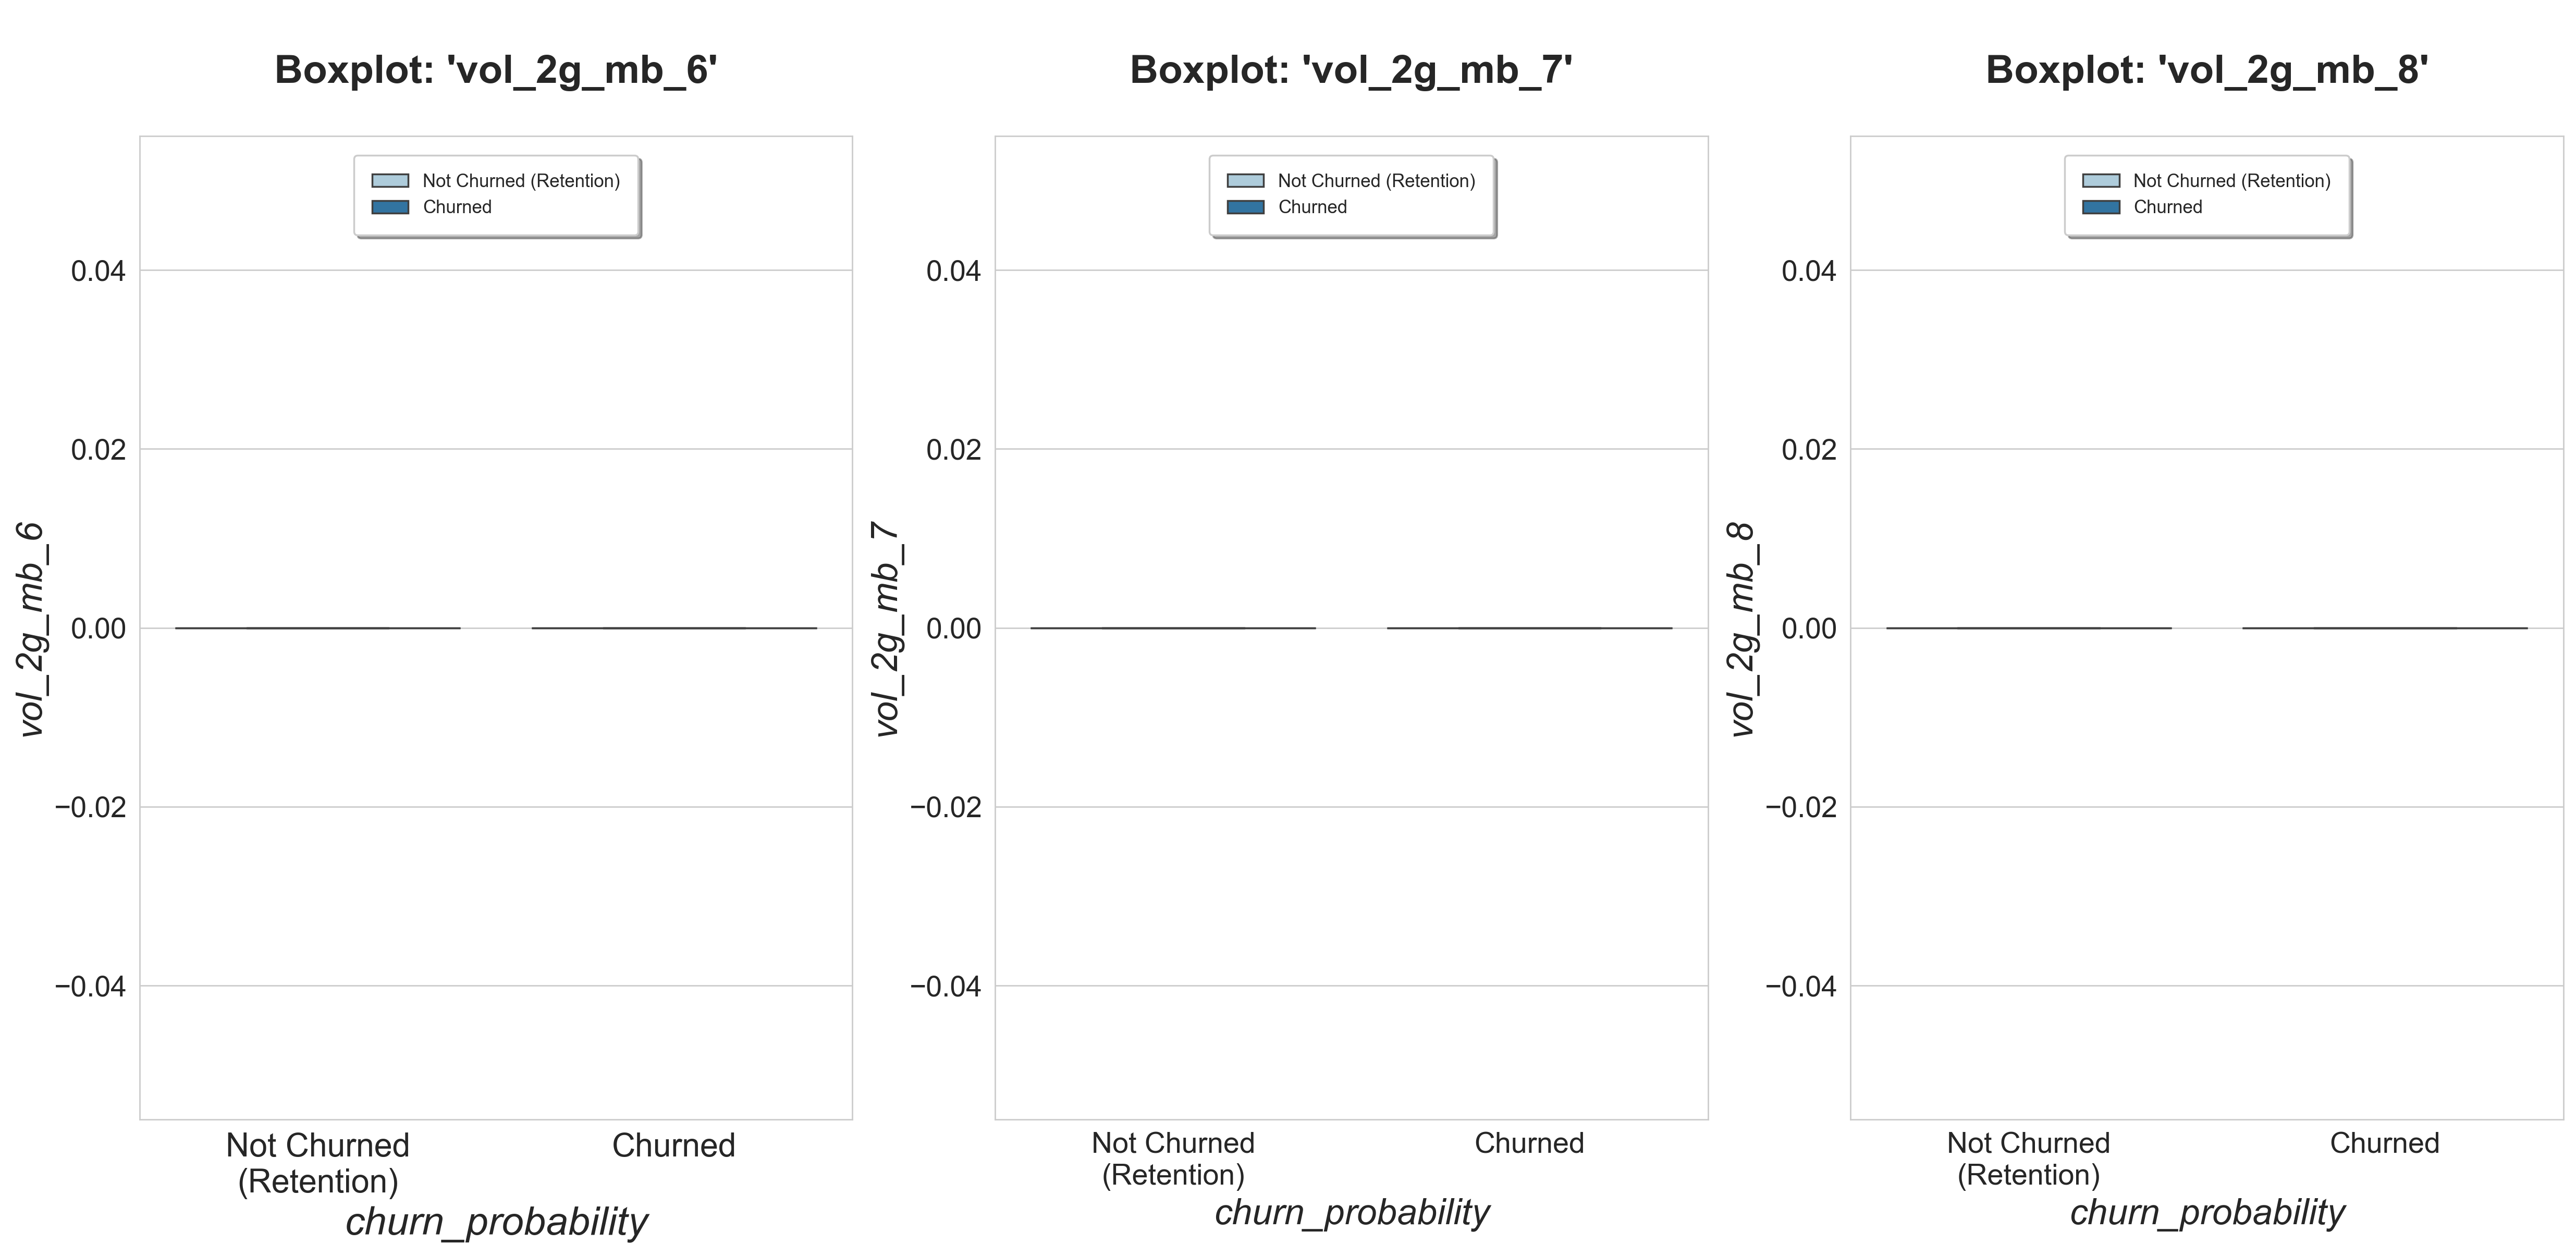

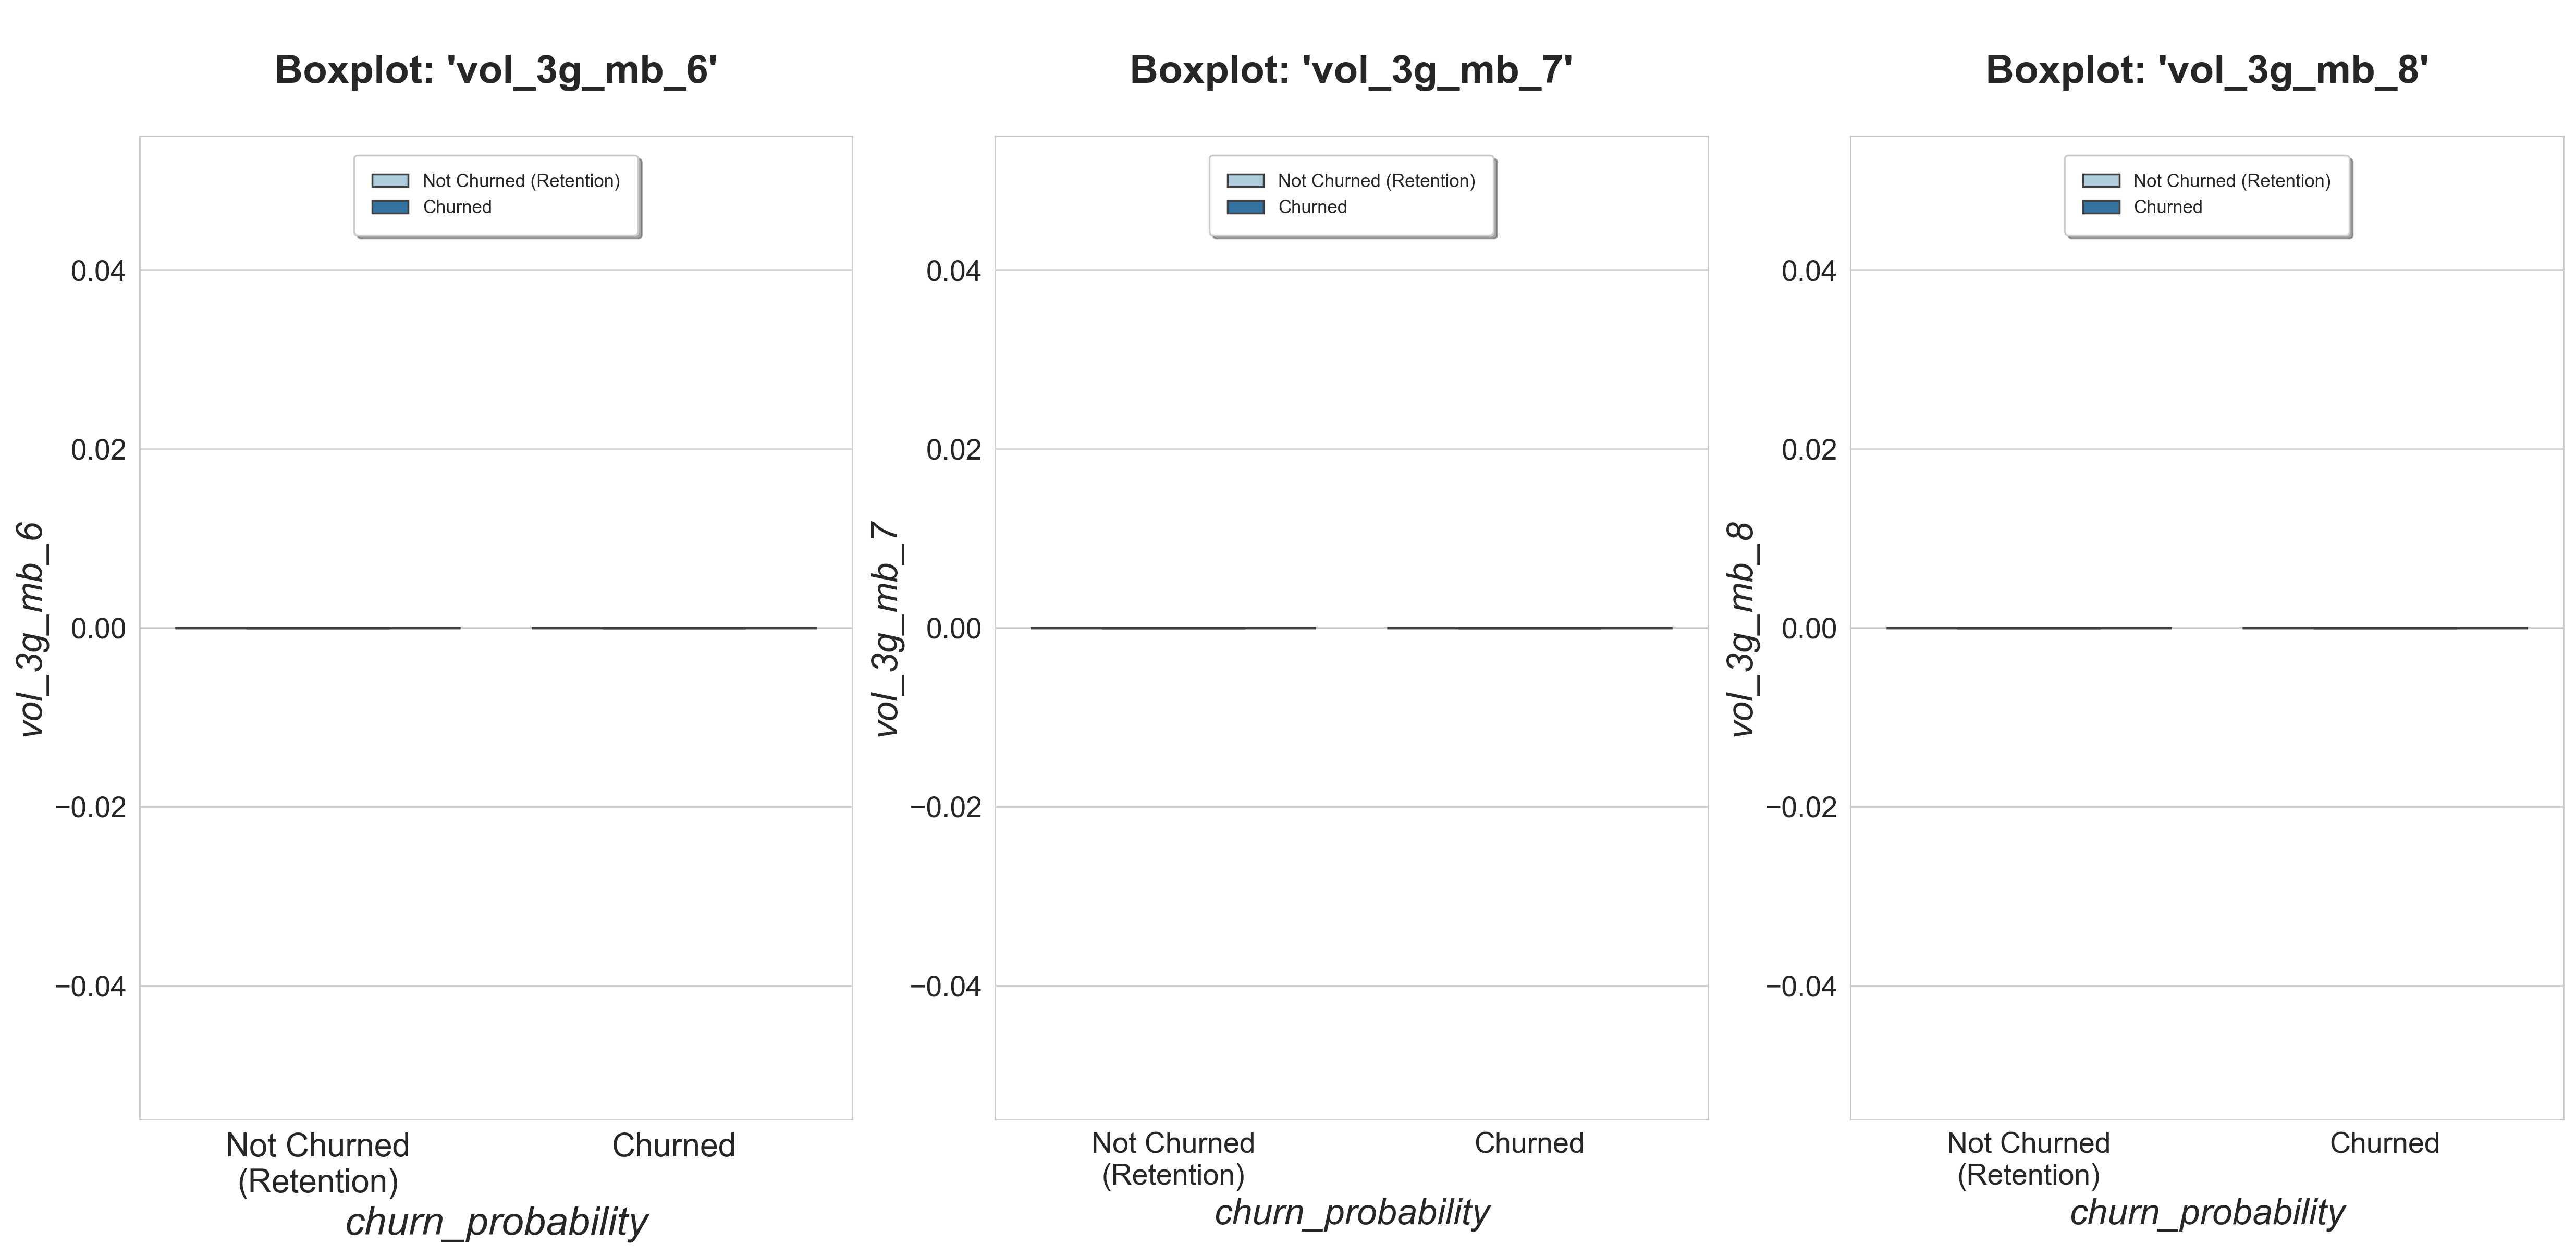

In [29]:
##Creating a function for boxplots for features belonging to months (6), (7) and (8) respectively with churn and no churn hue.
##(0: Not Churned (Retention), 1: Churned)

def plot_boxplots_6_7_8(feature):  
    plt.figure(figsize=(24,10), dpi=250)
    sns.set_style("whitegrid")
    
    # Copy the DataFrame
    df = telecom_df.copy()
    
    # Check if feature columns exist
    for month in ['6', '7', '8']:
        col_name = f'{feature}_{month}'
        if col_name not in df.columns:
            print(f"Warning: Column '{col_name}' does not exist in the DataFrame.")
            return
    
    # Check data types
    for col in [f'{feature}_6', f'{feature}_7', f'{feature}_8']:
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"Warning: Column '{col}' is not numeric.")
            return
    
    # Check for NaN values
    for col in [f'{feature}_6', f'{feature}_7', f'{feature}_8']:
        if df[col].isnull().sum() > 0:
            print(f"Warning: Column '{col}' contains NaN values.")
    
    # Create plots
    plt.subplot(1,3,1)
    ax_11 = sns.boxplot(data=df, y=f'{feature}_6', x='churn_probability', hue='churn_probability', showfliers=False, palette='Paired')
    ax_11.set_xticklabels(labels=['Not Churned\n(Retention)', 'Churned'], fontsize=18)
    plt.title(f"\nBoxplot: '{feature}_6'\n", fontsize=22, fontweight='bold')
    plt.ylabel(f'{feature}_6', fontsize=20, fontstyle='italic')
    plt.xlabel("churn_probability", fontsize=22, fontstyle='italic')
    plt.yticks(fontsize=16)
    
    # Legend for subplot_131
    T1 = ax_11.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
    T1.get_texts()[0].set_text('Not Churned (Retention)')
    T1.get_texts()[1].set_text('Churned')
    
    plt.subplot(1,3,2)
    ax_22 = sns.boxplot(data=df, y=f'{feature}_7', x='churn_probability', hue='churn_probability', showfliers=False, palette='Paired')
    ax_22.set_xticklabels(labels=['Not Churned\n(Retention)', 'Churned'], fontsize=18)
    plt.title(f"\nBoxplot: '{feature}_7'\n", fontsize=22, fontweight='bold')
    plt.ylabel(f'{feature}_7', fontsize=20, fontstyle='italic')
    plt.xlabel("churn_probability", fontsize=20, fontstyle='italic')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    # Legend for subplot_132
    T2 = ax_22.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
    T2.get_texts()[0].set_text('Not Churned (Retention)')
    T2.get_texts()[1].set_text('Churned')
    
    plt.subplot(1,3,3)
    ax_33 = sns.boxplot(data=df, y=f'{feature}_8', x='churn_probability', hue='churn_probability', showfliers=False, palette='Paired')
    ax_33.set_xticklabels(labels=['Not Churned\n(Retention)', 'Churned'], fontsize=18)
    plt.title(f"\nBoxplot: '{feature}_8'\n", fontsize=22, fontweight='bold')
    plt.ylabel(f'{feature}_8', fontsize=20, fontstyle='italic')
    plt.xlabel("churn_probability", fontsize=20, fontstyle='italic')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    # Legend for subplot_133
    T3 = ax_33.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
    T3.get_texts()[0].set_text('Not Churned (Retention)')
    T3.get_texts()[1].set_text('Churned')
    
    plt.show()

# Plotting volume of 2G data usage features:
plot_boxplots_6_7_8('vol_2g_mb')

# Plotting volume of 3G data usage features:
plot_boxplots_6_7_8('vol_3g_mb')


In [30]:
##Since the range is very small and no trend can be seen, let's use barplot

##Defining a function for barplots for features belonging to months (6), (7) and (8) respectively with churn and no churn hue.
##(0: Not Churned (Retention), 1: Churned)

def plot_barplots_6_7_8(feature):  ##Note: Showfliers: False (Suppresses the effect of outliers on the graphs.)
    plt.figure(figsize=(24,10), dpi=250)
    sns.set_style("whitegrid")
    df = telecom_df.copy()
    
    plt.subplot(1,3,1)
    ax_11= sns.barplot(data=df, y=feature+"_6", x=df["churn_probability"], hue="churn_probability", palette=("Paired"))
    ax_11.set_xticklabels(labels=['Not Churned\n(Retention)','Churned'], fontsize=18)
    plt.title(f"\nBarplot: '{feature}_6'\n", fontsize=22, fontweight='bold')
    plt.ylabel(feature+"_6", fontsize=20, fontstyle='italic')
    plt.xlabel("churn", fontsize=22, fontstyle='italic')
    plt.yticks(fontsize=16)
    
    #legend subplot_131
    T1= ax_11.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
    T1.get_texts()[0].set_text('Not Churned (Retention)')
    T1.get_texts()[1].set_text('Churned')
    
    plt.subplot(1,3,2)
    ax_22= sns.barplot(data=df, y=feature+"_7", x=df["churn_probability"], hue="churn_probability", palette=("Paired"))
    ax_22.set_xticklabels(labels=['Not Churned\n(Retention)','Churned'], fontsize=18)
    plt.title(f"\nBarplot: '{feature}_7'\n", fontsize=22, fontweight='bold')
    plt.ylabel(feature+"_7", fontsize=20, fontstyle='italic')
    plt.xlabel("churn", fontsize=20, fontstyle='italic')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    #legend subplot_132
    T2= ax_22.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
    T2.get_texts()[0].set_text('Not Churned (Retention)')
    T2.get_texts()[1].set_text('Churned')

    plt.subplot(1,3,3)
    ax_33= sns.barplot(data=df, y=feature+"_8", x=df["churn_probability"], hue="churn_probability", palette=("Paired"))
    ax_33.set_xticklabels(labels=['Not Churned\n(Retention)','Churned'], fontsize=18)
    plt.title(f"\nBarplot: '{feature}_8'\n", fontsize=22, fontweight='bold')
    plt.ylabel(feature+"_8", fontsize=20, fontstyle='italic')
    plt.xlabel("churn", fontsize=20, fontstyle='italic')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    #legend subplot_133
    T3= ax_33.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
    T3.get_texts()[0].set_text('Not Churned (Retention)')
    T3.get_texts()[1].set_text('Churned')
    
    plt.show()

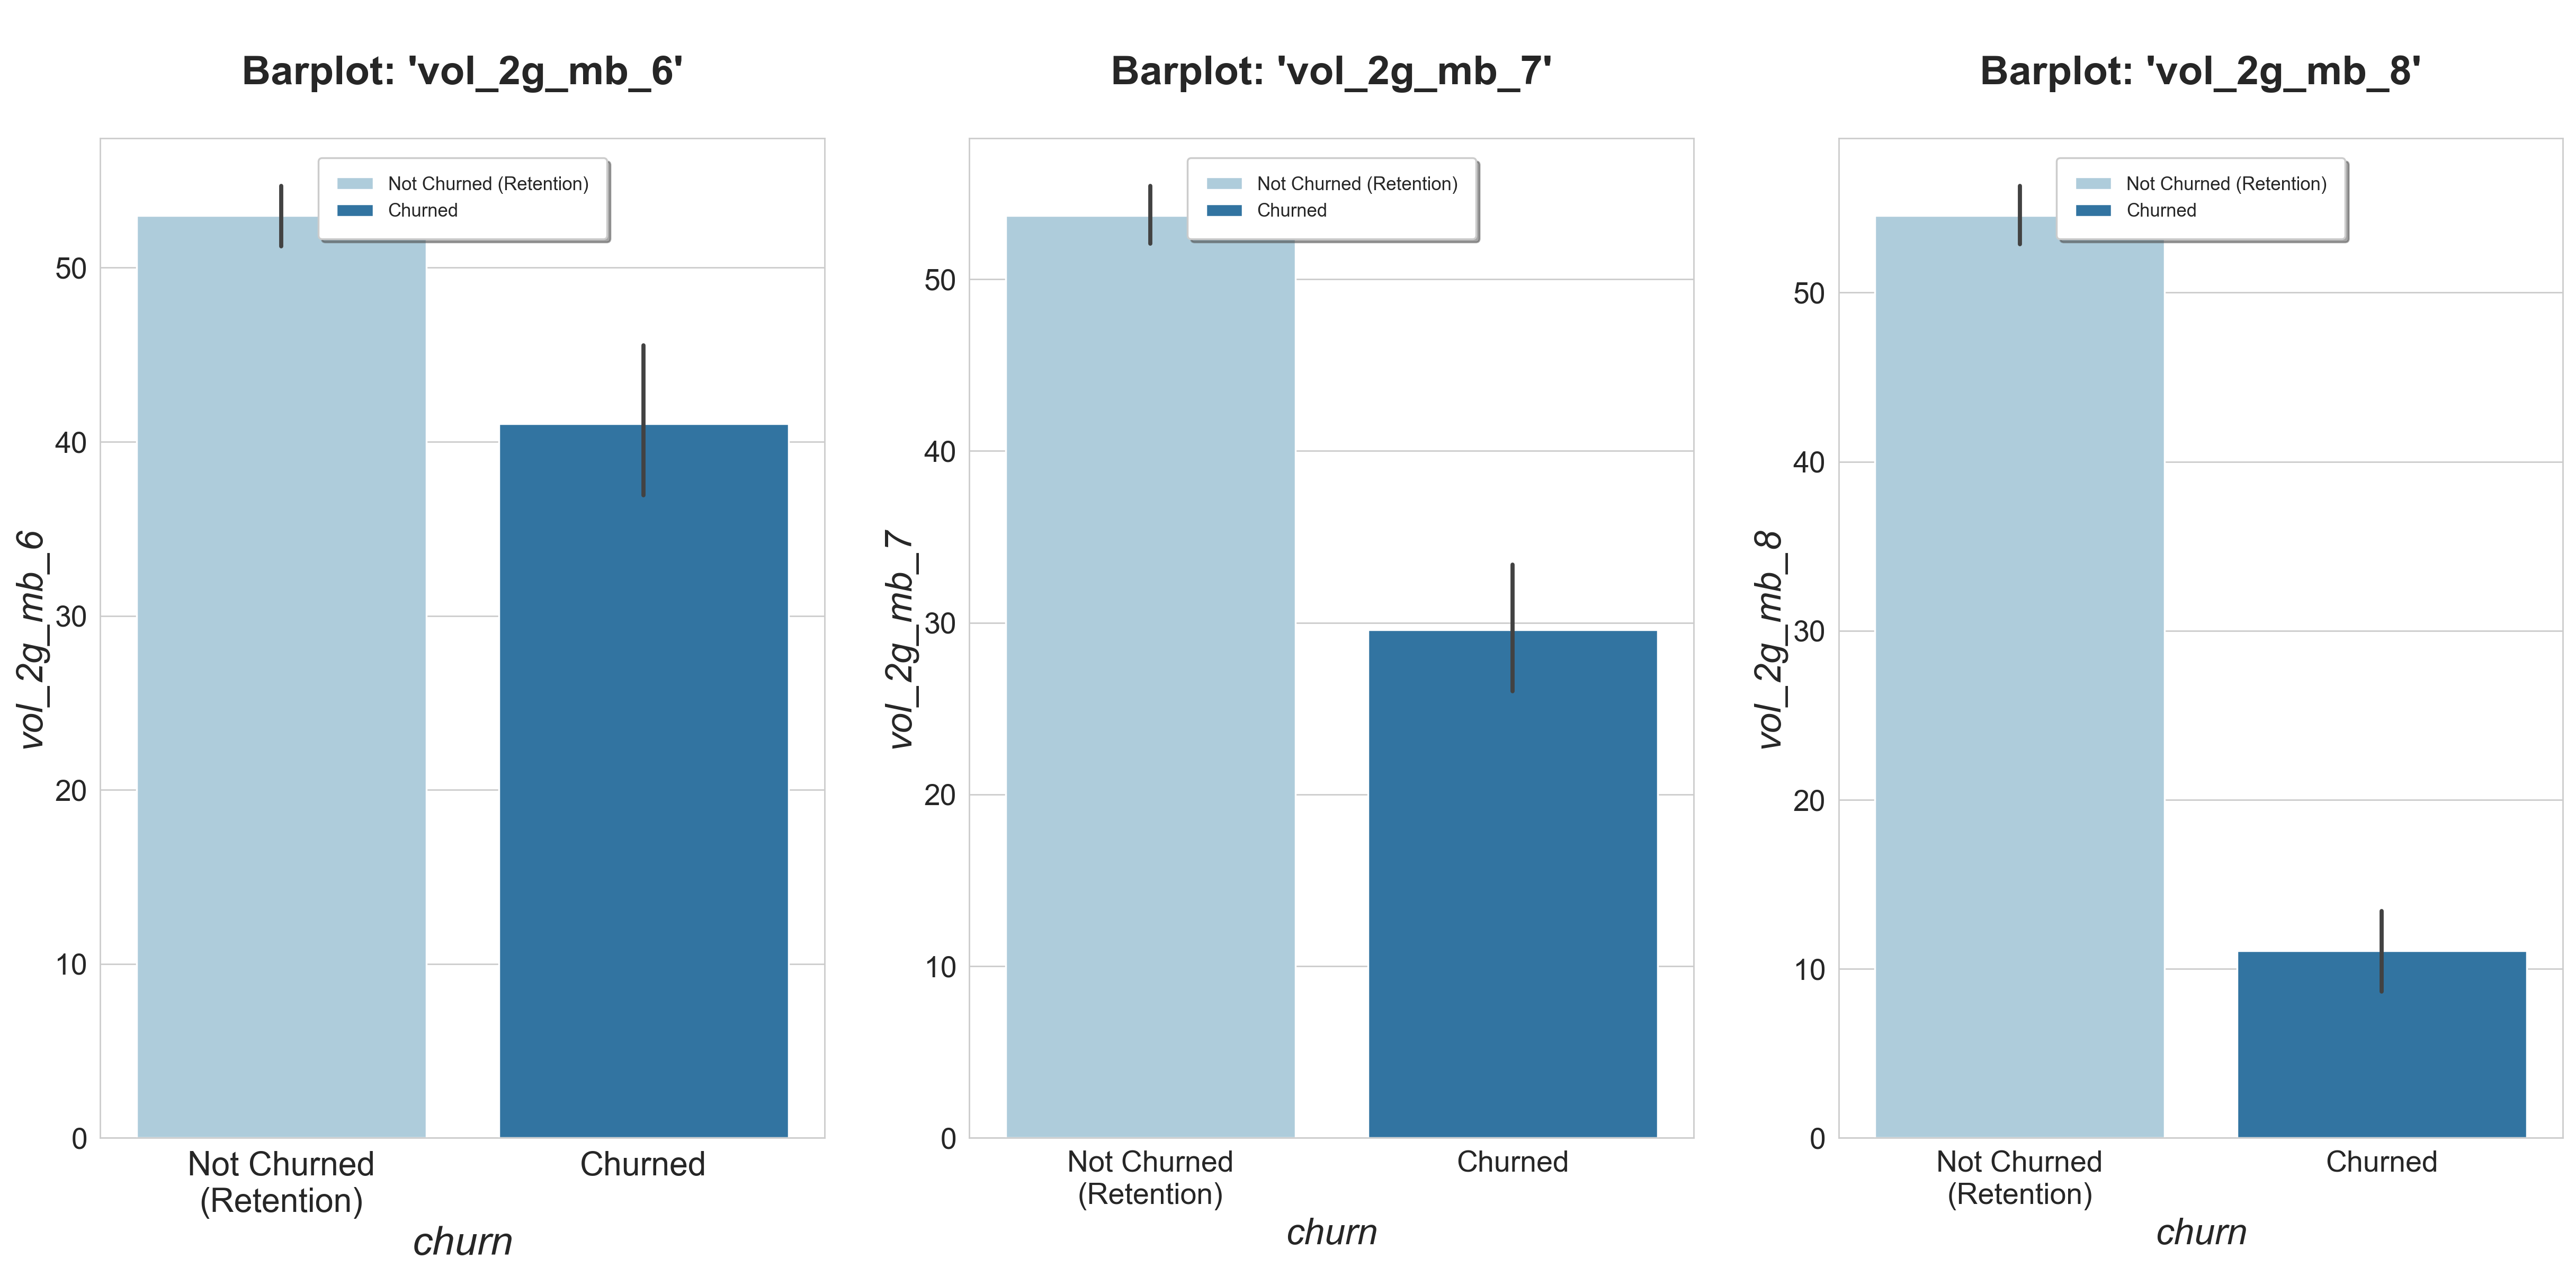

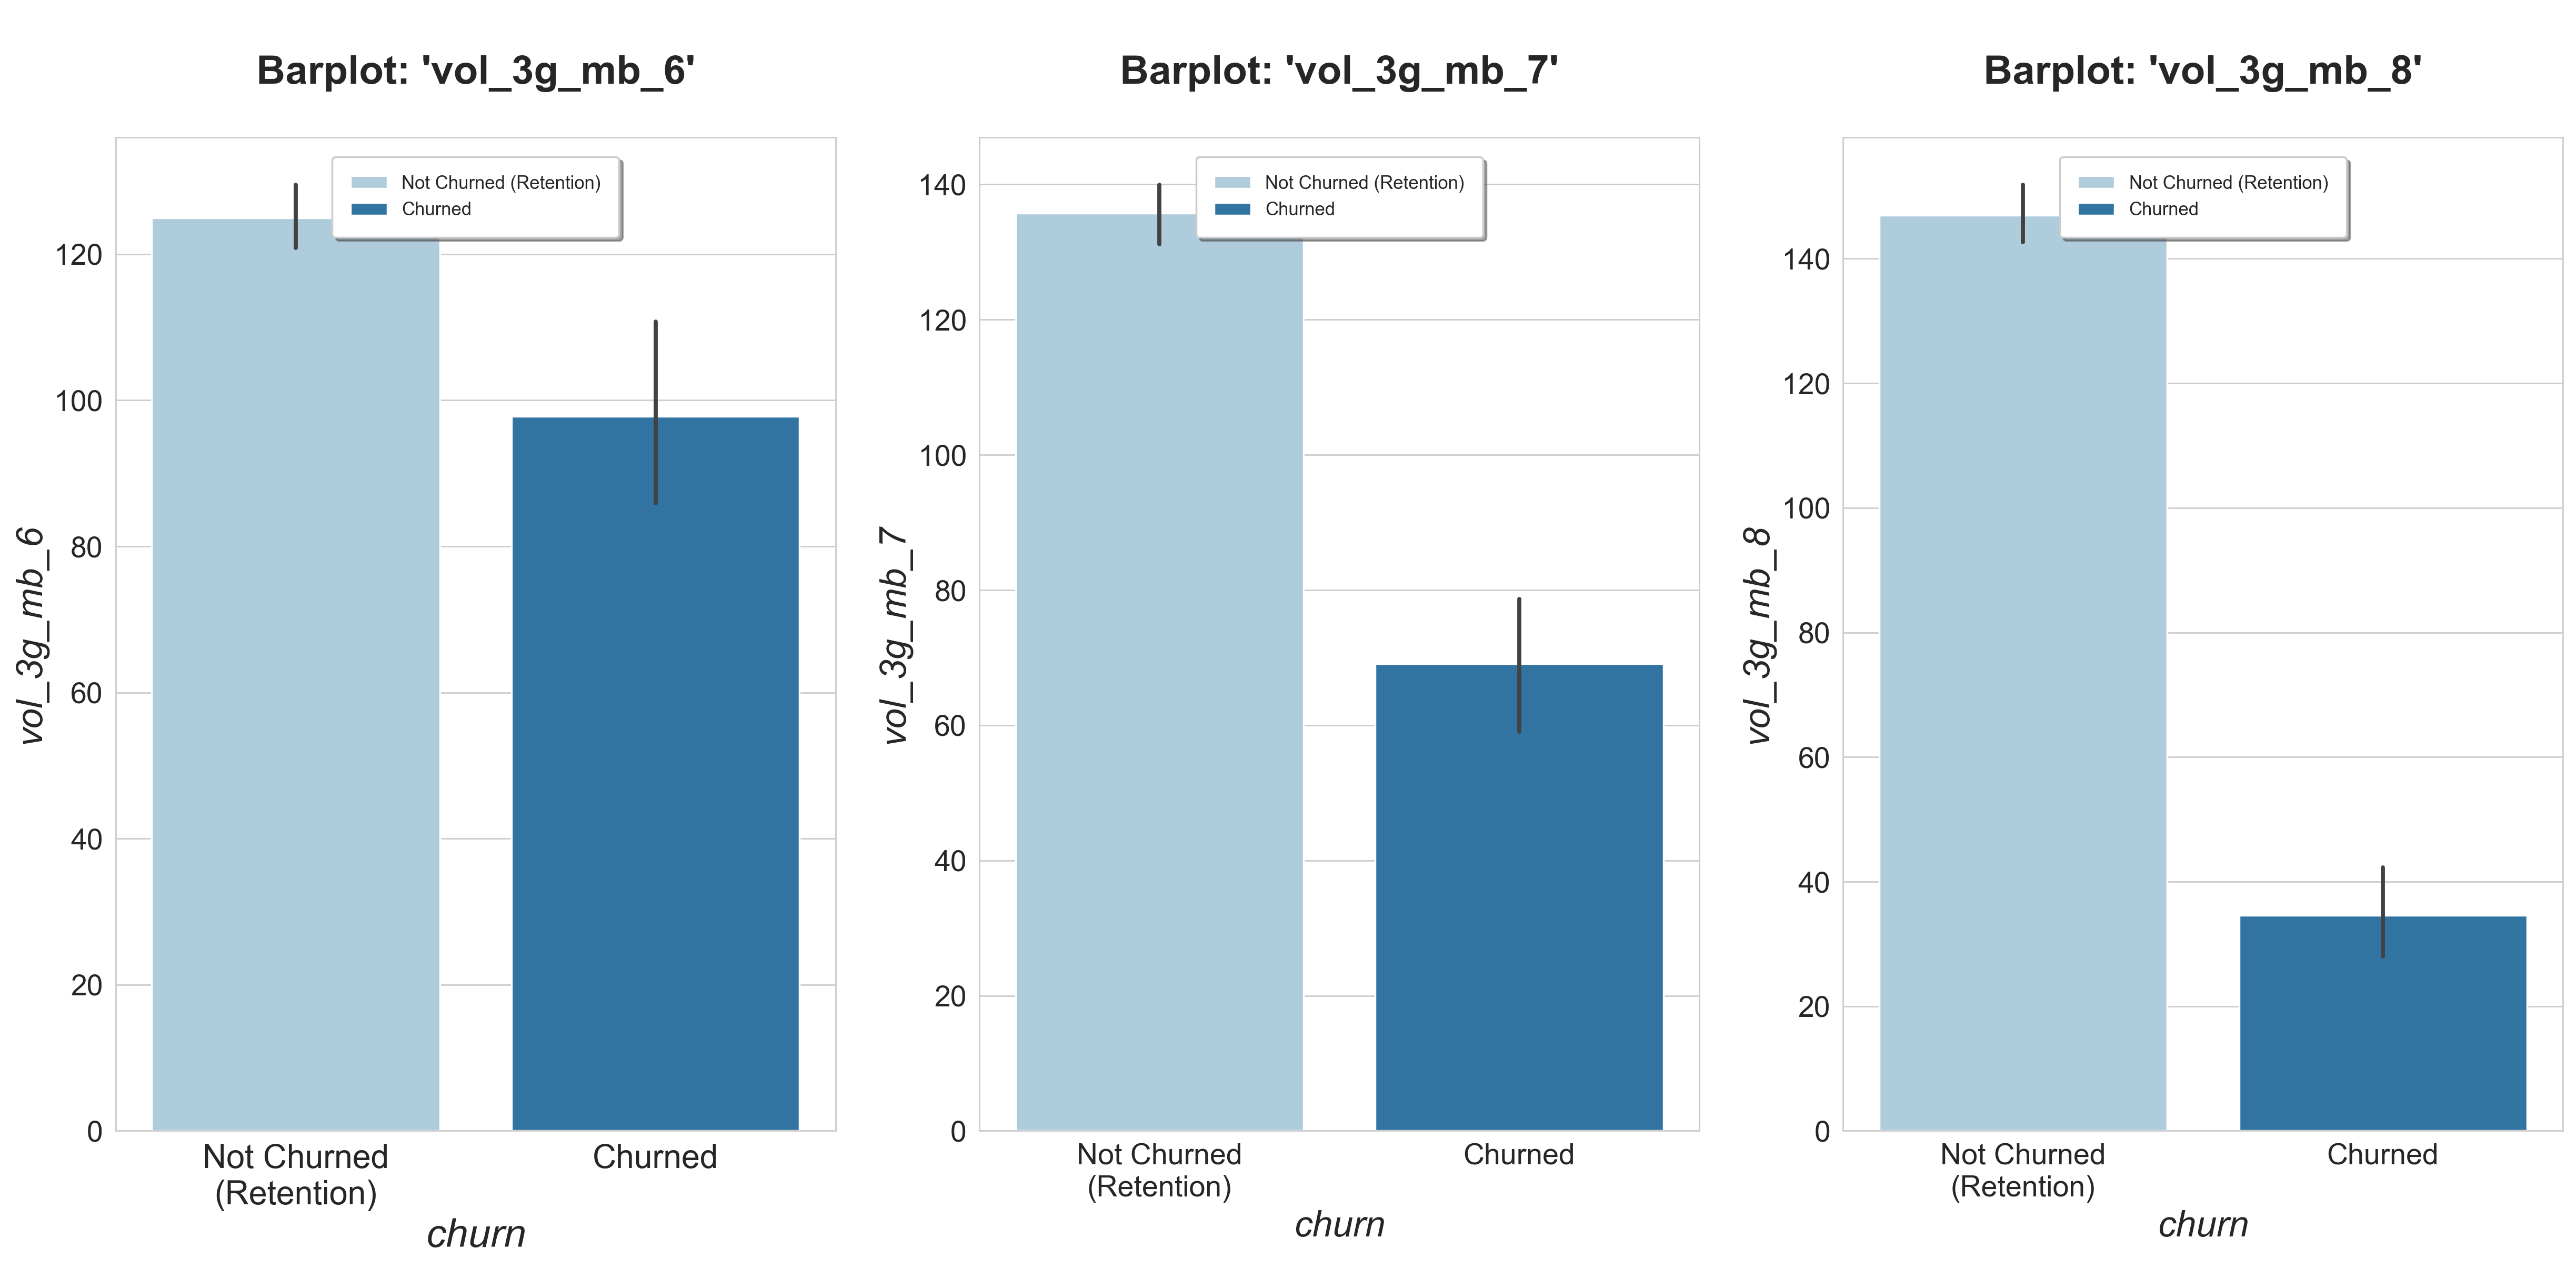

In [31]:
# Plotting volume of 2G data usage features:
plot_barplots_6_7_8('vol_2g_mb')

# Plotting volume of 3G data usage features:
plot_barplots_6_7_8('vol_3g_mb')


(a) Recharge amount (calling and data plan) associated features:

In [32]:
rech_amt_cols = telecom_df.columns[telecom_df.columns.str.contains('rech_amt|rech_data_amt')]  ##For 6, 7 and 8 months
rech_amt_cols

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'last_day_rech_amt_6', 'last_day_rech_amt_7', 'last_day_rech_amt_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'total_rech_data_amt_6', 'total_rech_data_amt_7',
       'total_rech_data_amt_8'],
      dtype='object')

In [33]:
##Recheck for null values for the above mentioned recharge amount (calling and dataplan) features

rech_amt_df = telecom_df[rech_amt_cols]
null_prcnt_df(rech_amt_df)

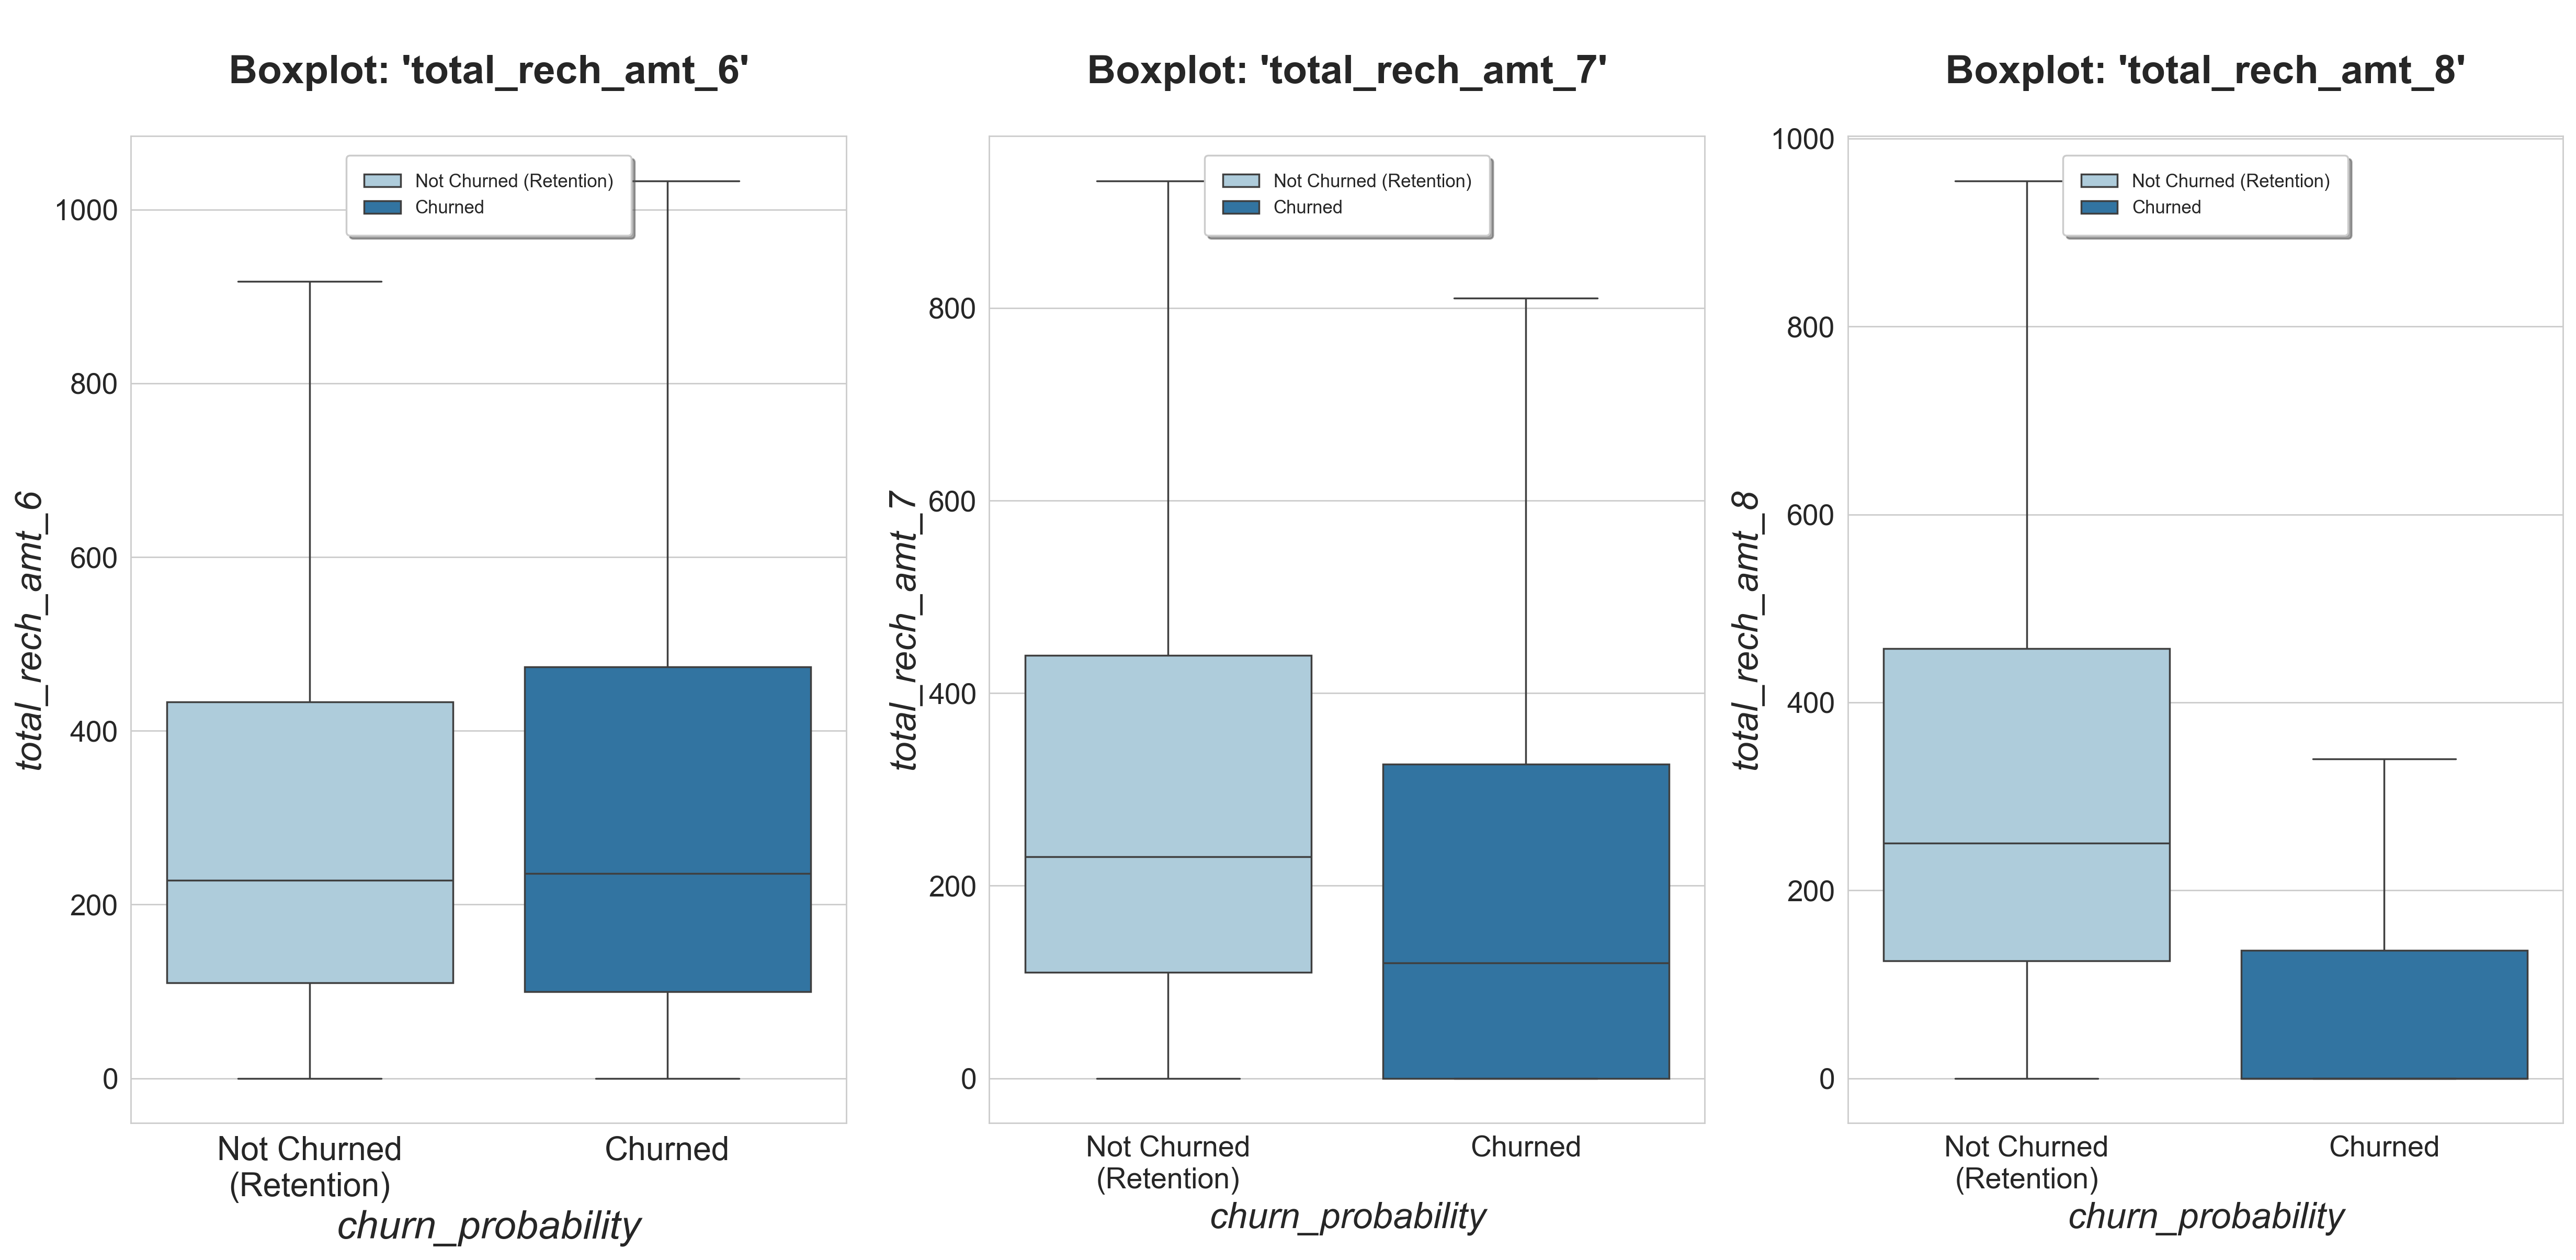

In [34]:
##Plotting boxplots for 'total_rech_amt' (calling plan recharges)
plot_boxplots_6_7_8('total_rech_amt')

**Observation**: We can see a drop in the `total recharge amount` for churned customers in the 8th Month

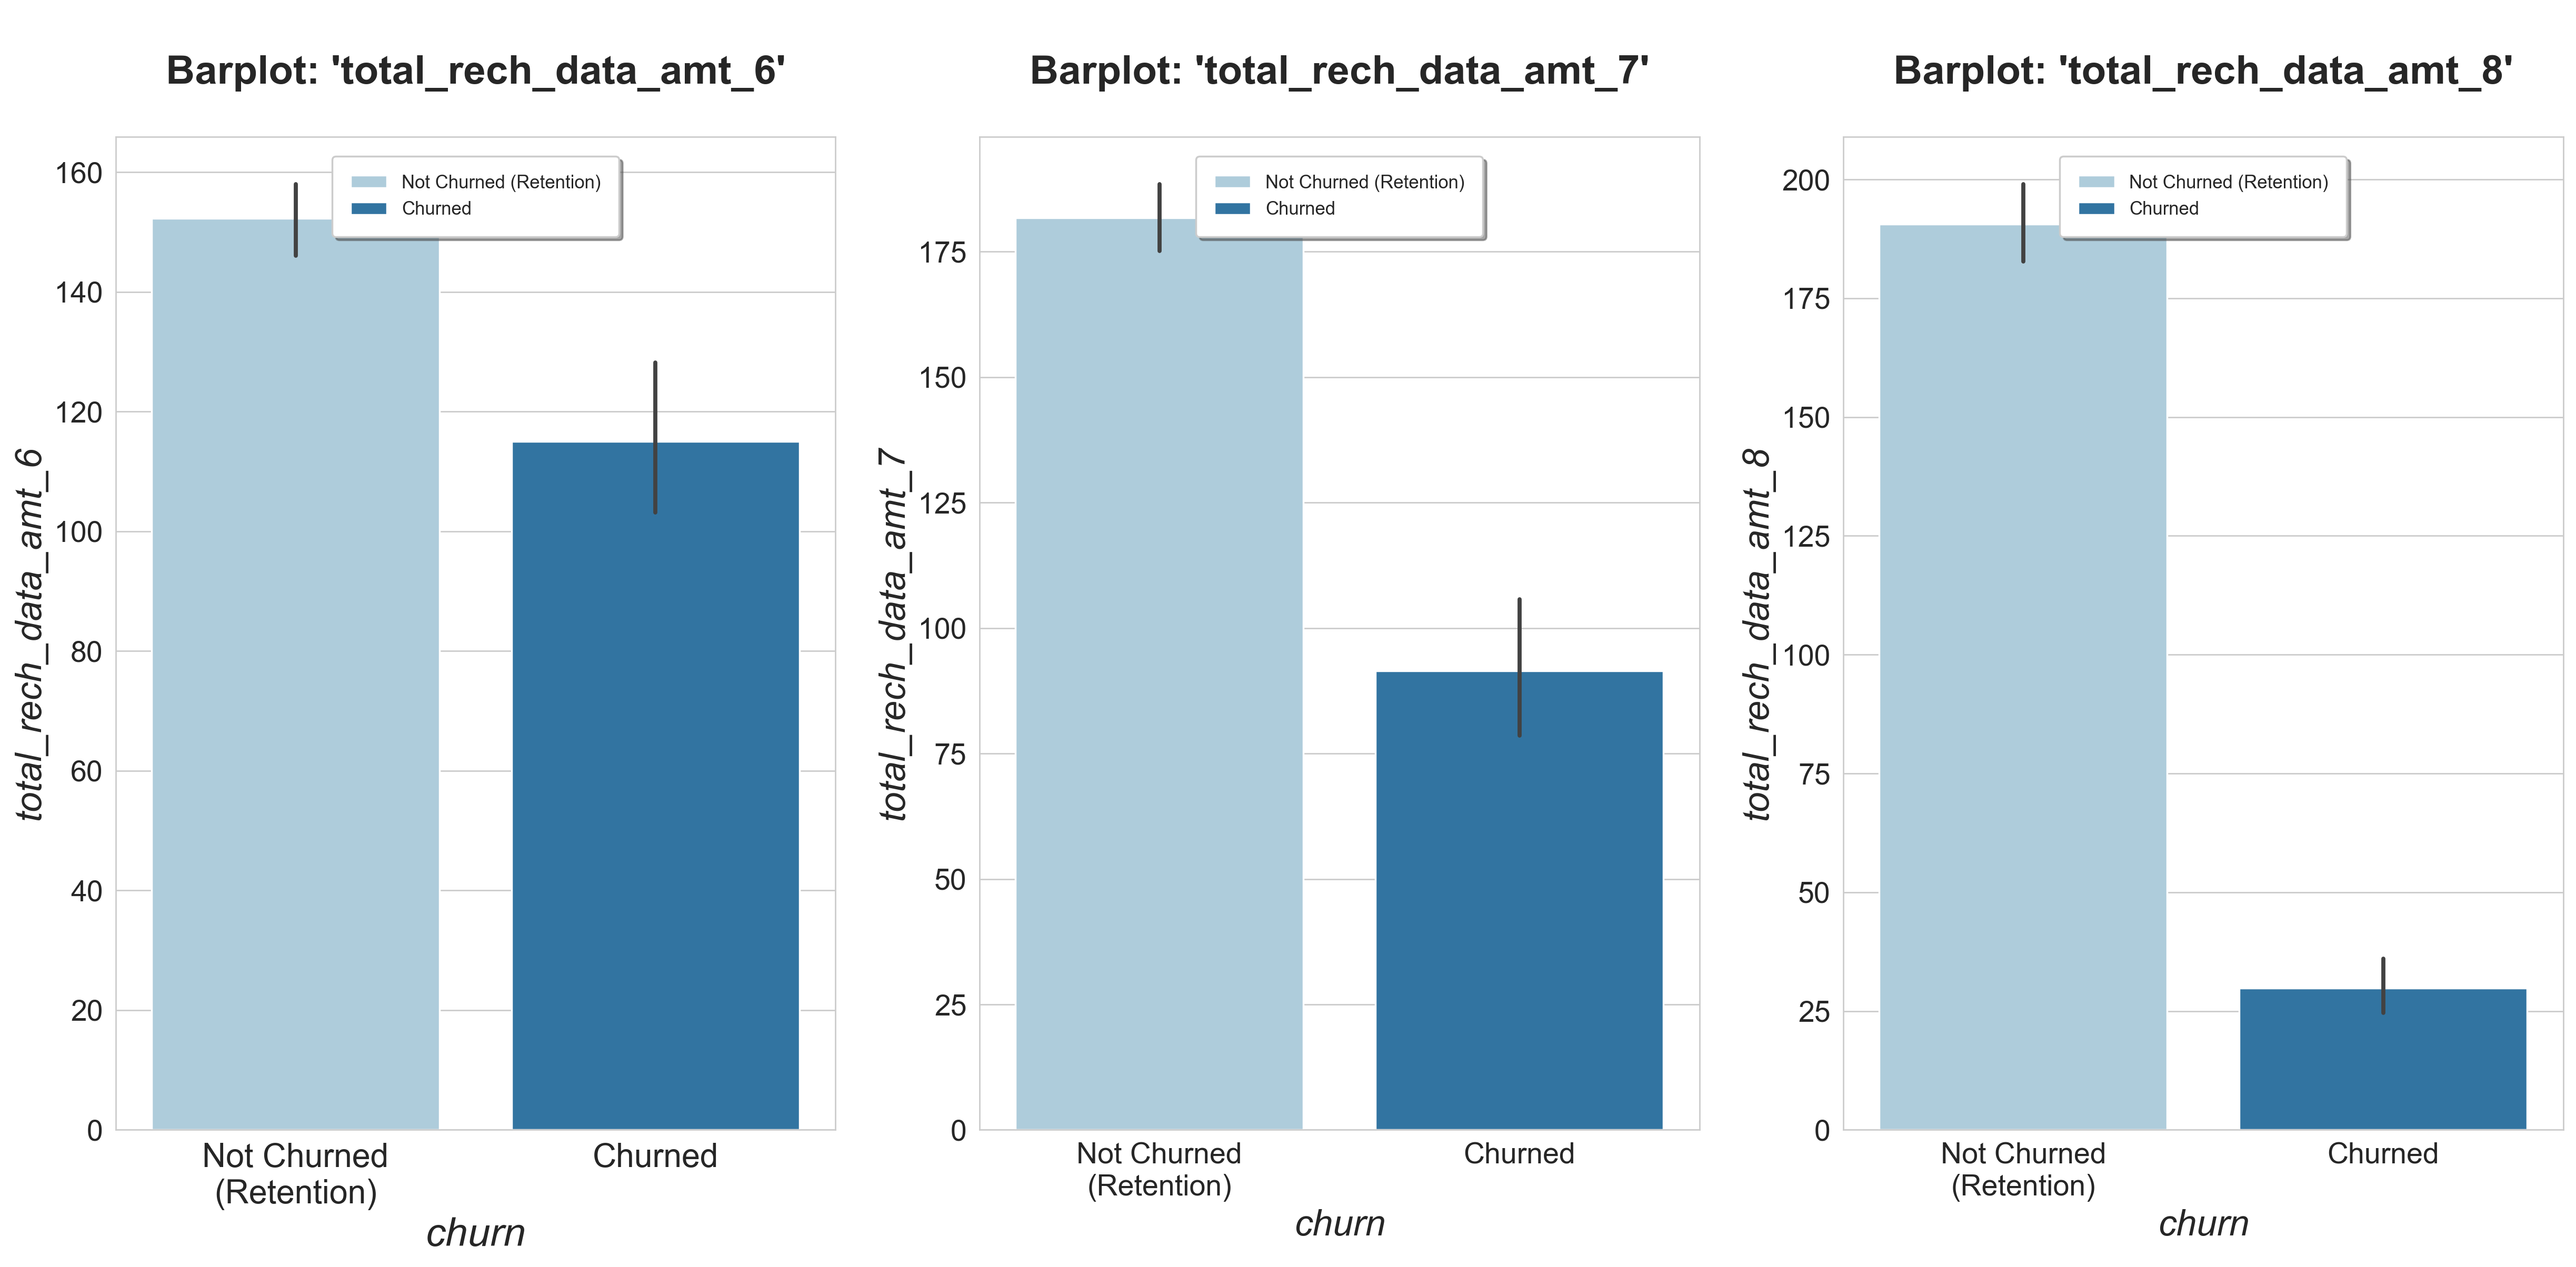

In [35]:
##Plotting boxplots for 'total_rech_data_amt' (dataplan recharges). 
plot_barplots_6_7_8('total_rech_data_amt')

**Observation**: Again, a significant drop in the `total data recharge amount` is seen for churned customers in the 8th Month

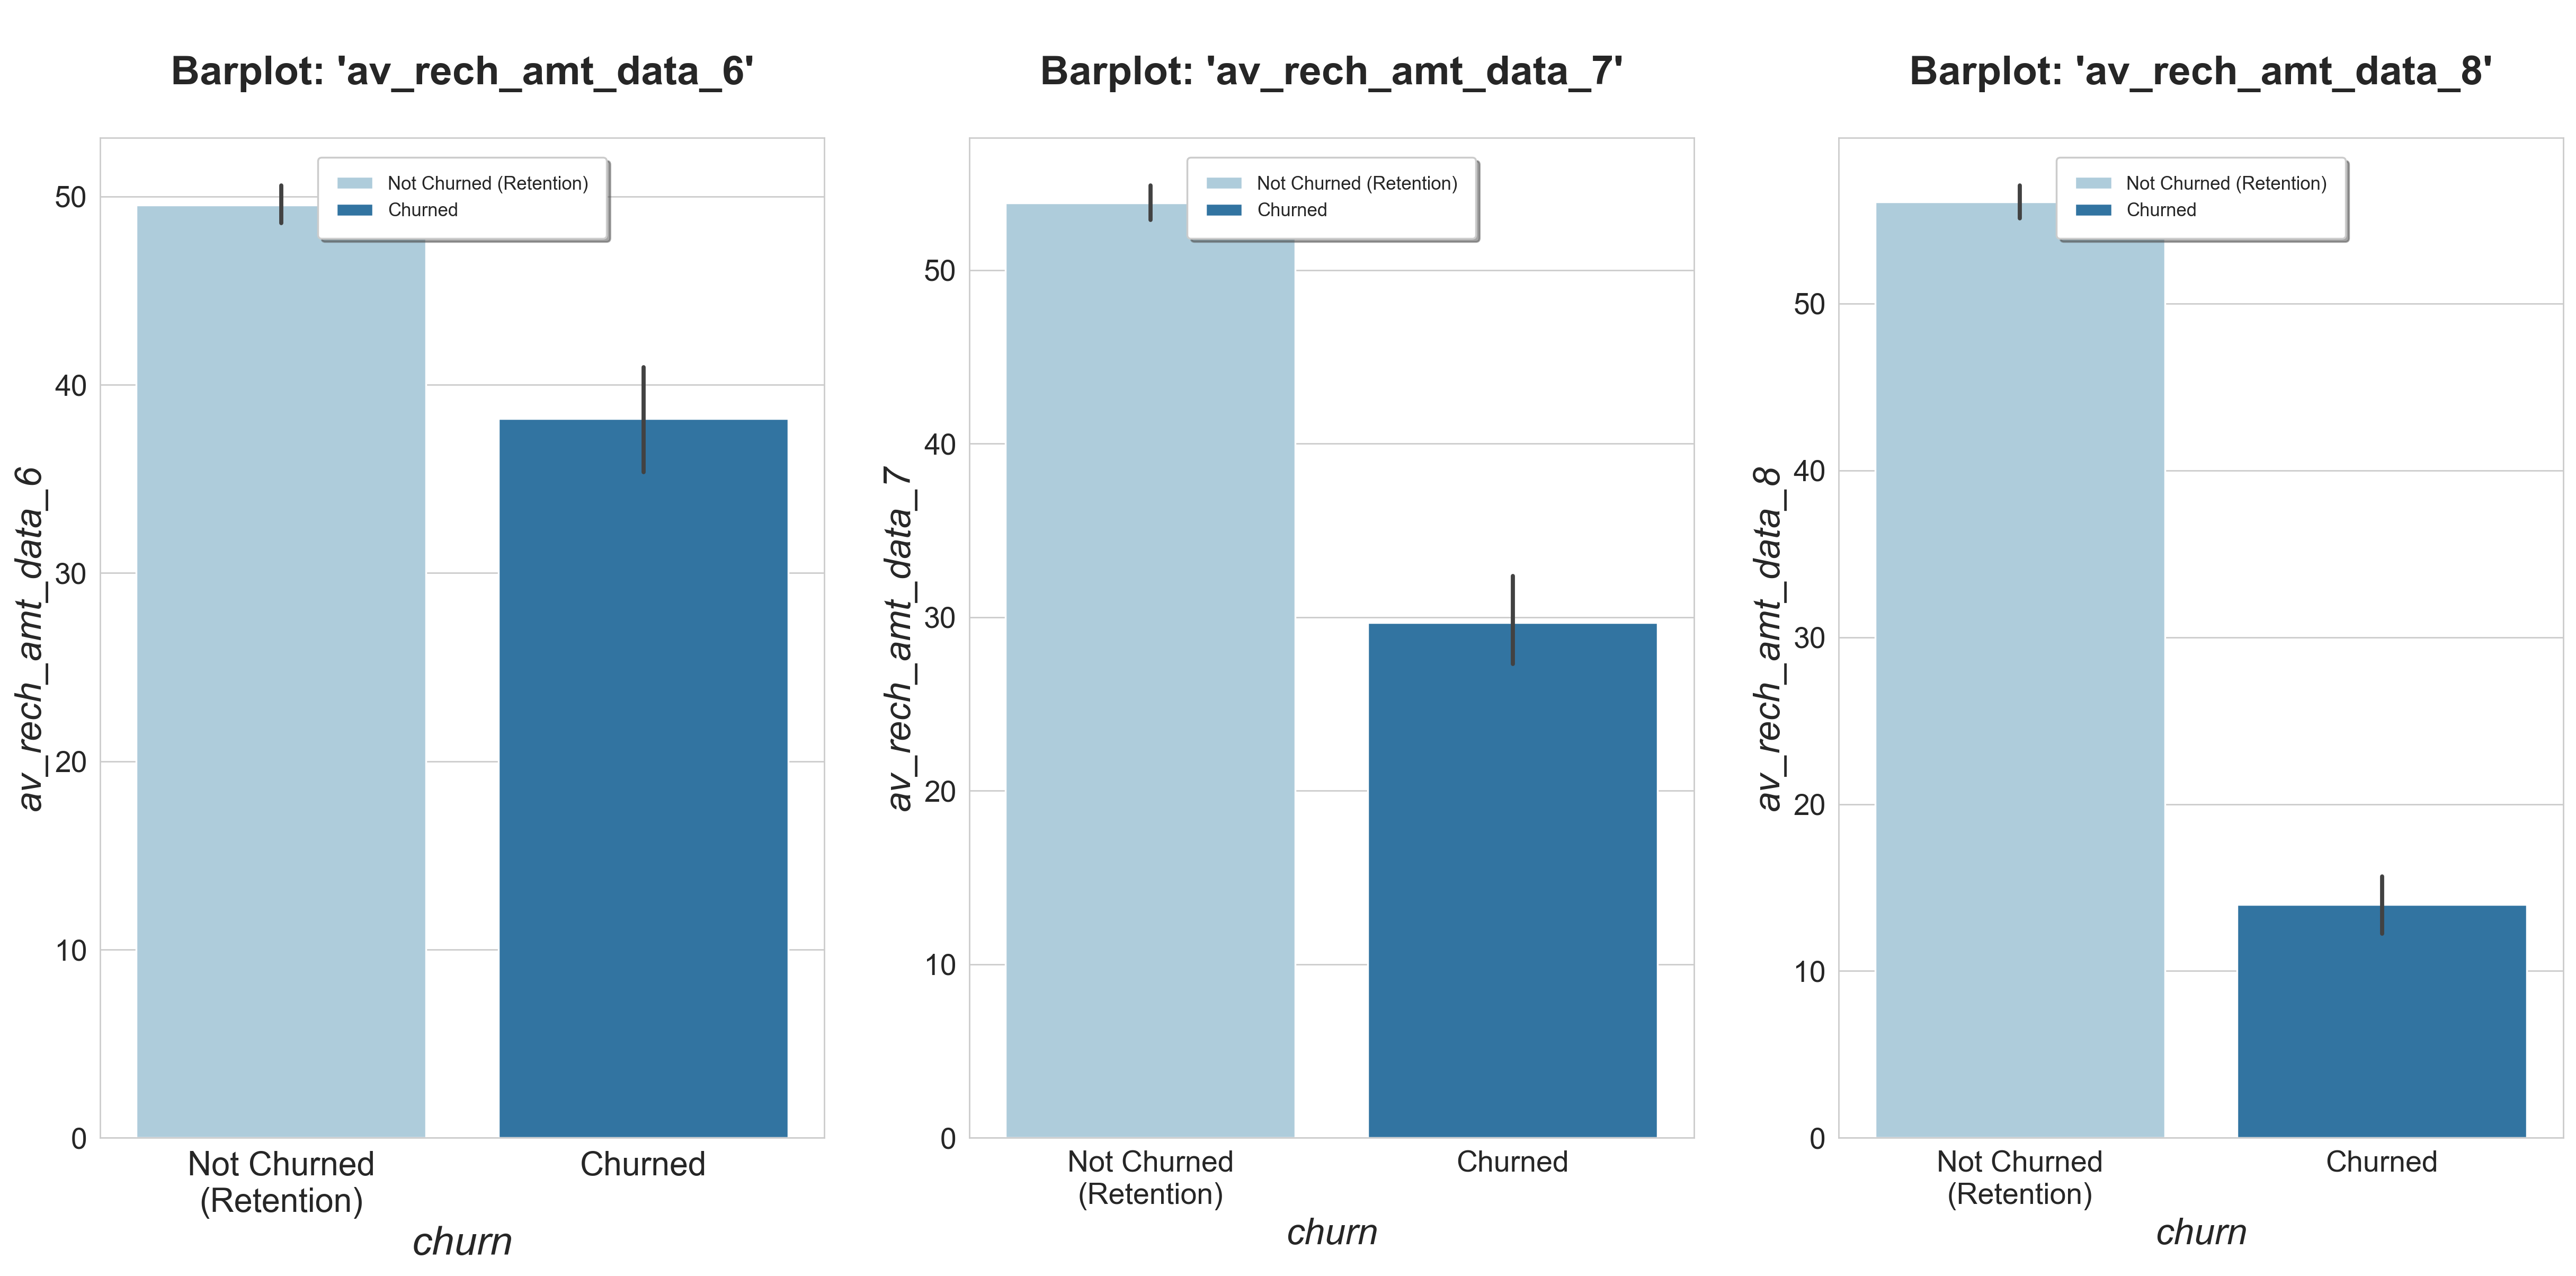

In [36]:
##Plotting boxplots for 'av_rech_amt_data' 
plot_barplots_6_7_8('av_rech_amt_data')

**Observation:** Again, a significant drop in the `average data recharge amount` is seen for churned customers in the 8th Month. Also, it makes sense as the `total_rech_data_amt_*` drops too.

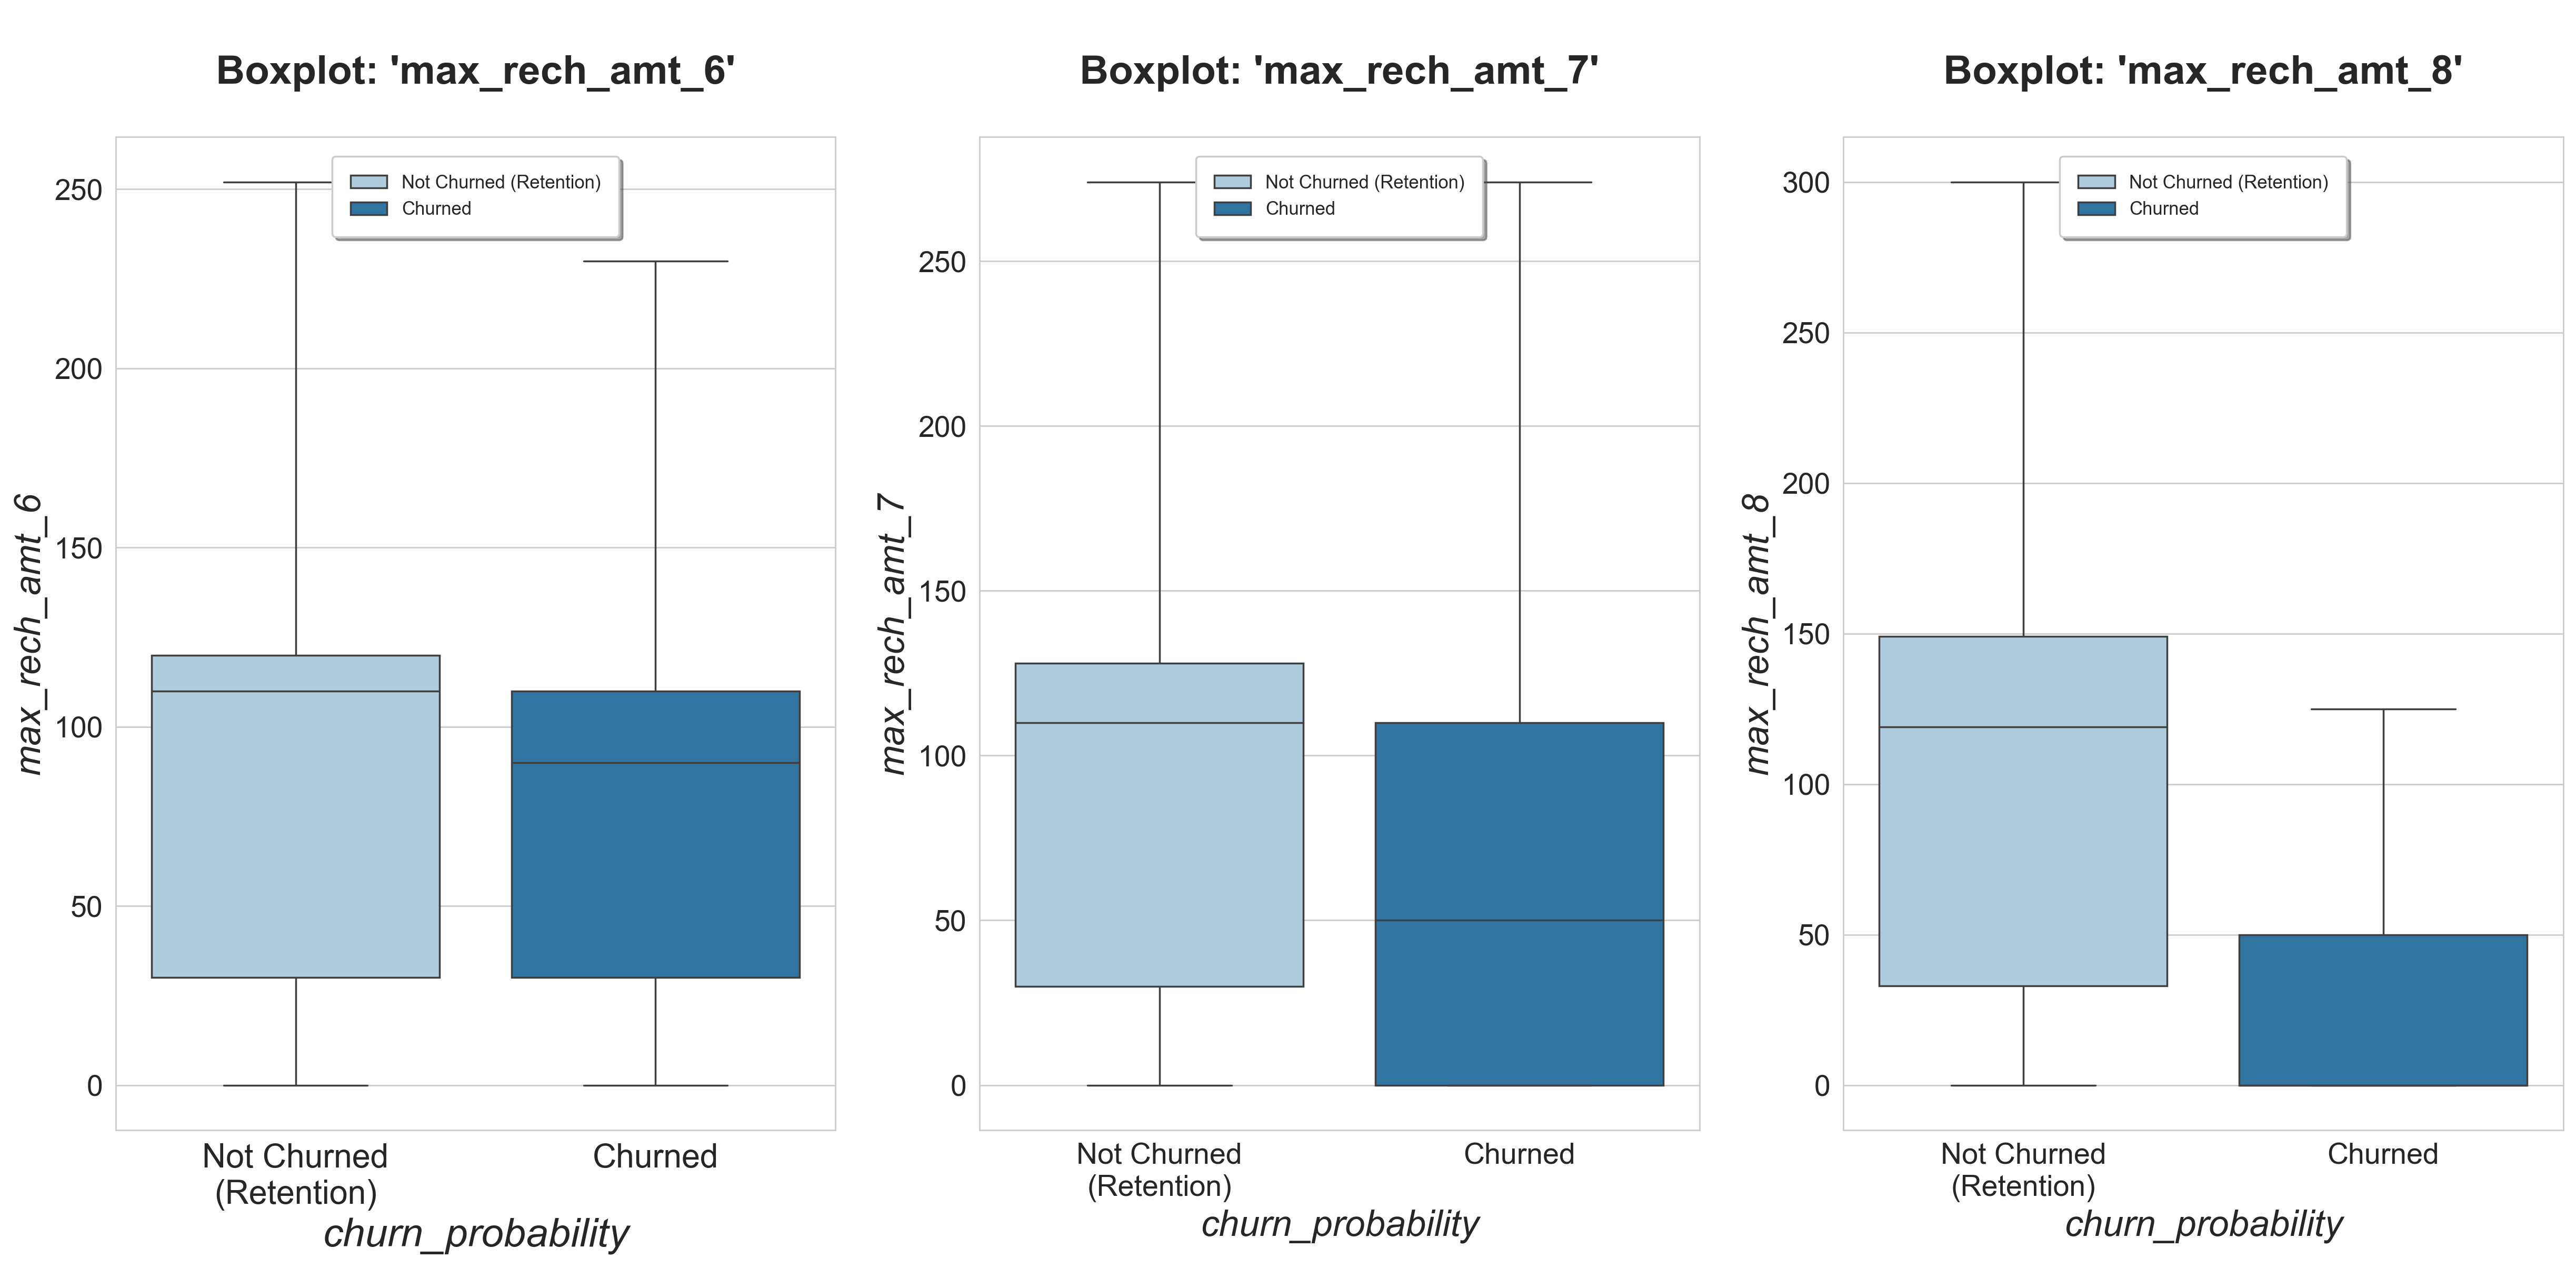

In [37]:
##Plotting boxplots for 'max_rech_amt' 
plot_boxplots_6_7_8('max_rech_amt')

**Observation:** A noticeable drop in the `maximum recharge amount` is seen in the 8th month for churned customers.

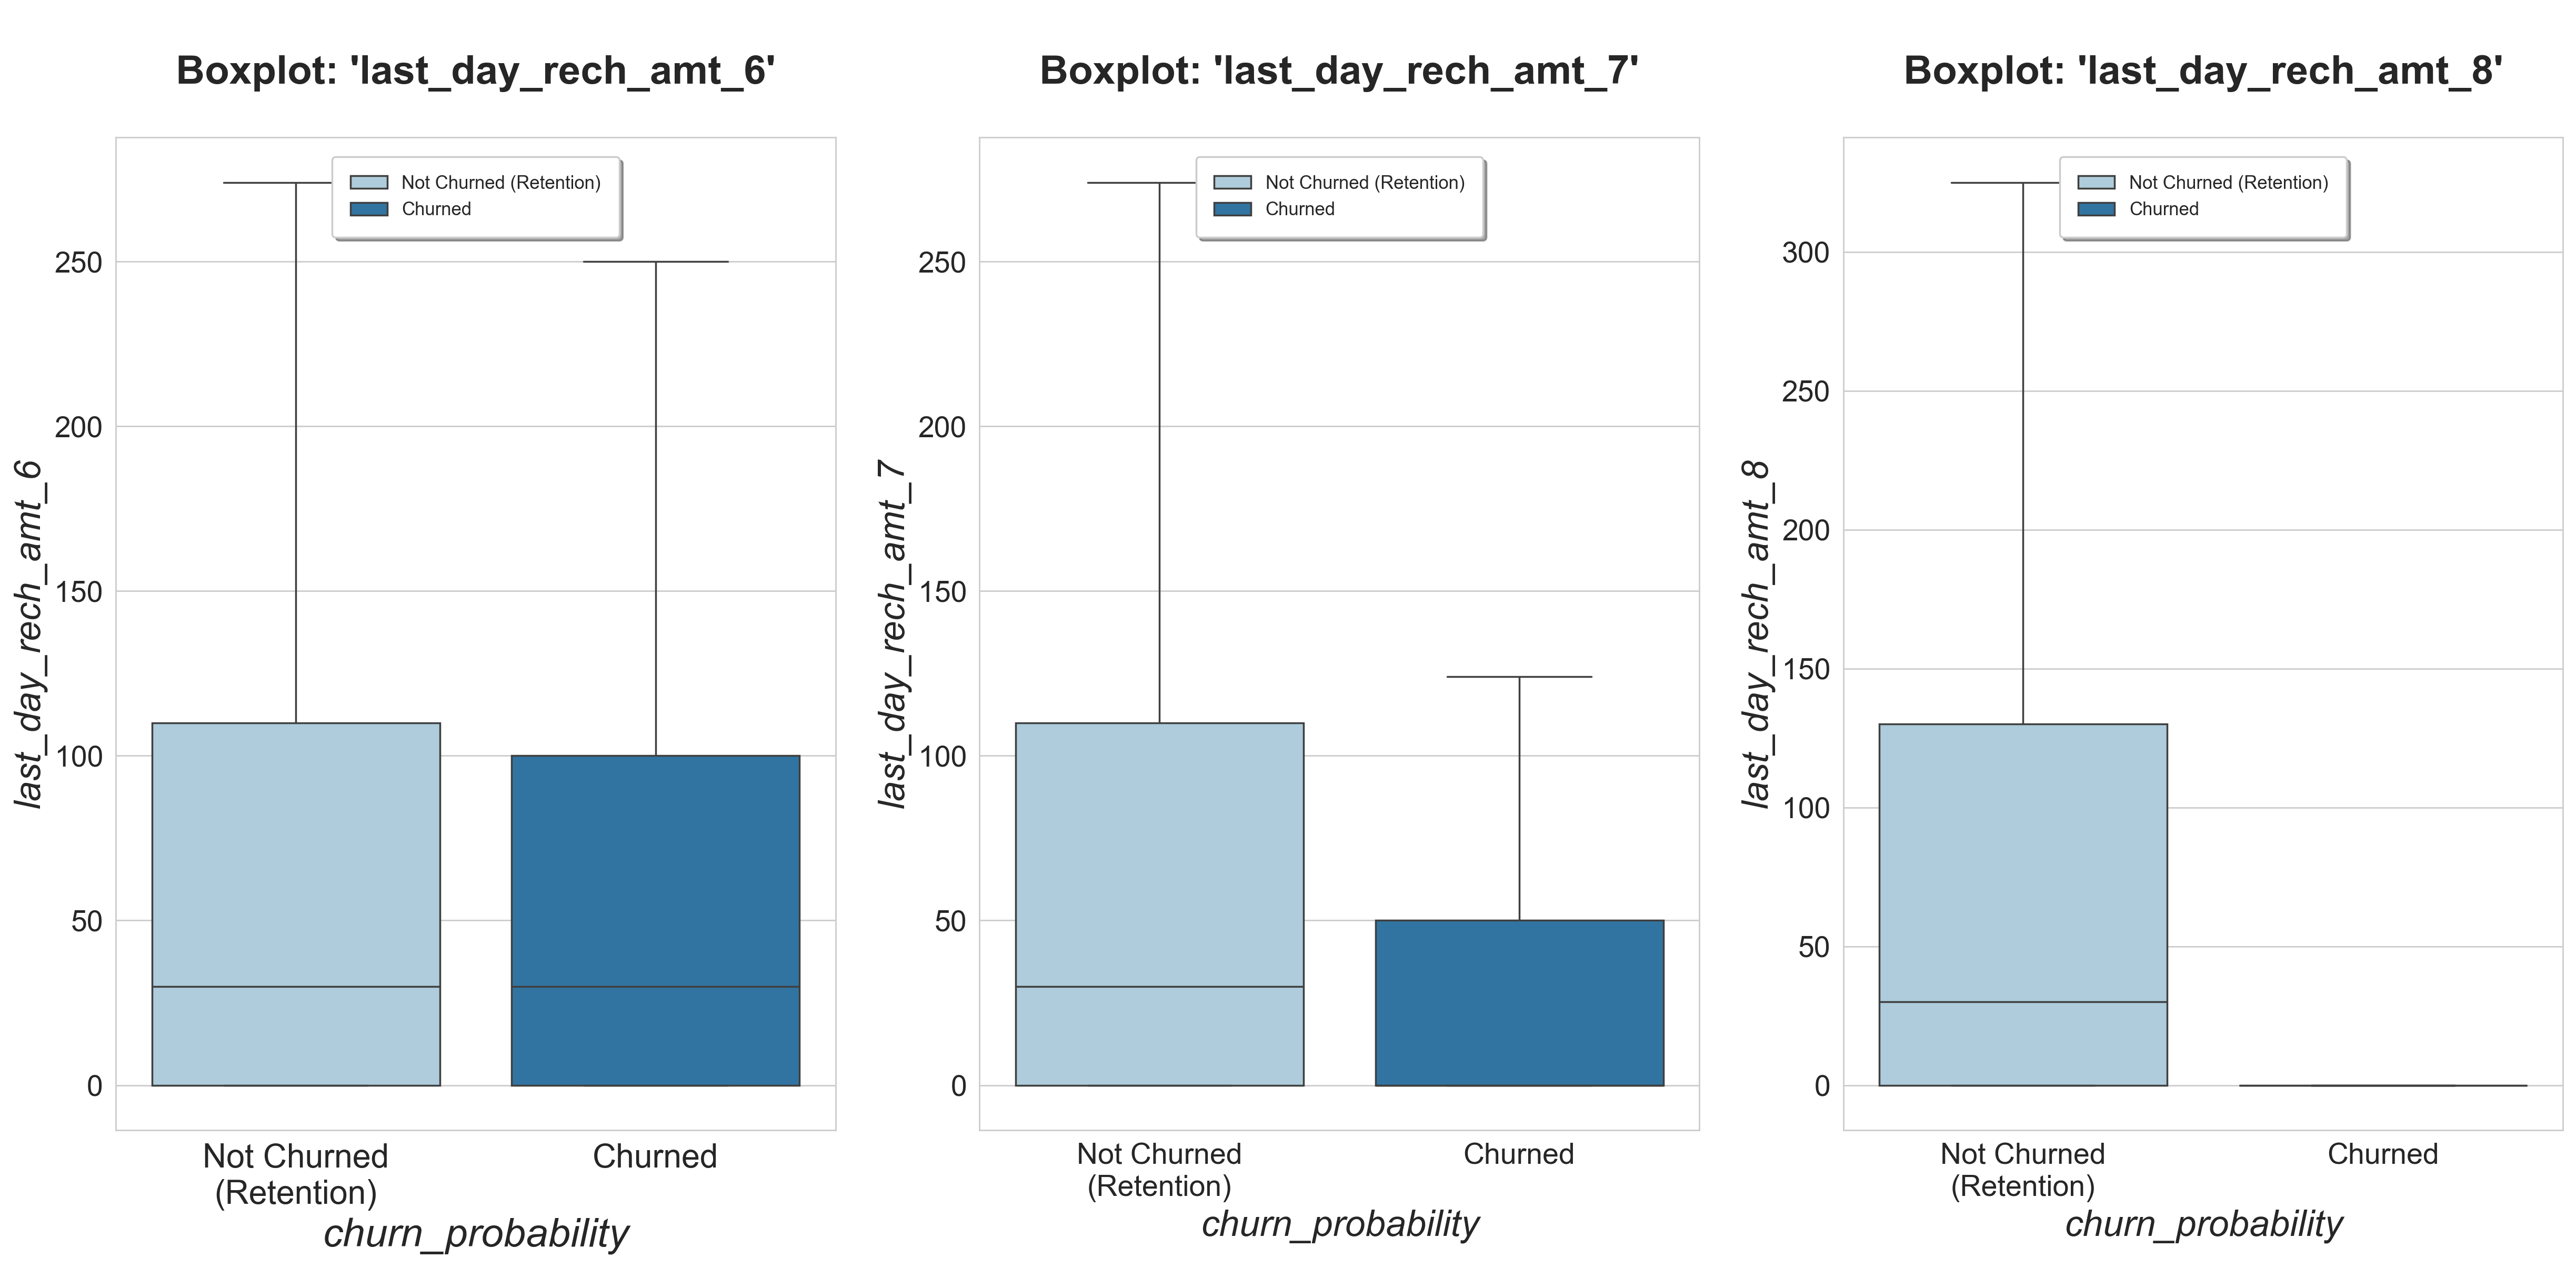

In [38]:
##Plotting boxplots for 'last_day_rech_amt' 
plot_boxplots_6_7_8('last_day_rech_amt')

**Observation:** We do see a noteworthy drop in the `last day recharge amount` in the 8th month for churned customers.

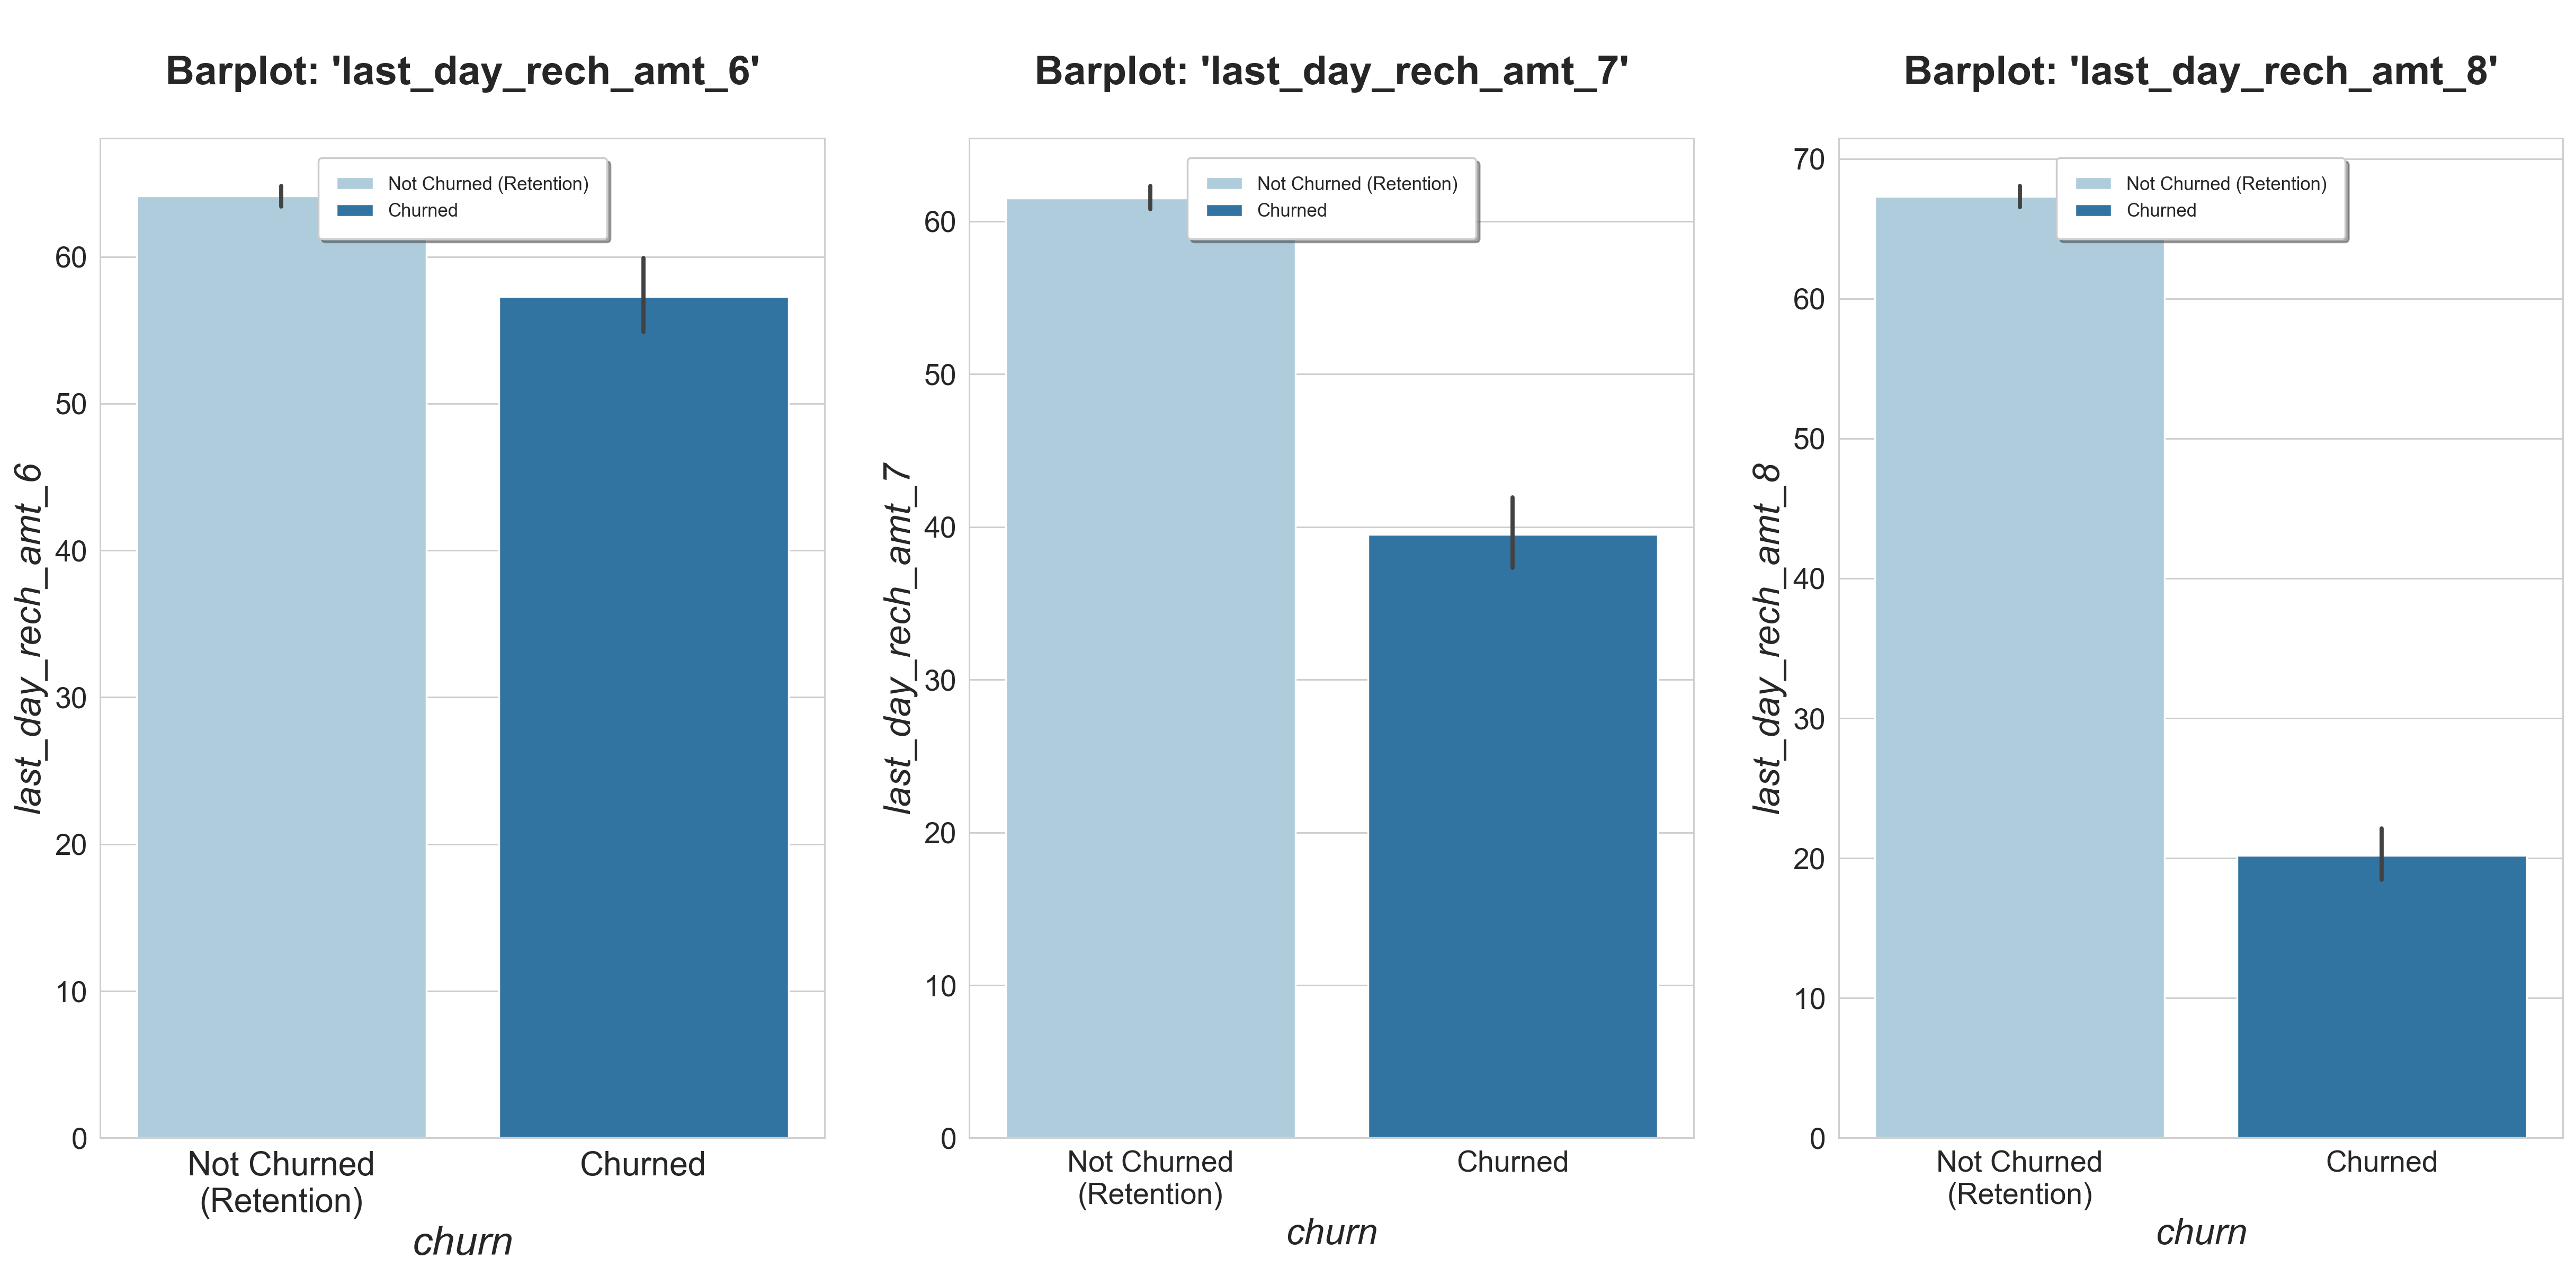

In [39]:
##Plotting boxplots for 'last_day_rech_amt' 
plot_barplots_6_7_8('last_day_rech_amt')

In [40]:
##Let's check other 'rech_num' and 'max_rech_data' variables
other_rech = telecom_df.columns[telecom_df.columns.str.contains('rech_num|max_rech_data',regex=True)]
other_rech

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8'],
      dtype='object')

In [41]:
##Let's check for missing values in 'total_rech_num' and 'max_rech_data' features

other_rech_df = telecom_df[other_rech]
null_prcnt_df(other_rech_df)

`total_rech_num` feature has no missing values whereas `max_rech_data` feature still has missing values, around 74% for all the 3 months. Let's check the range of values for these features.

In [42]:
telecom_df[['max_rech_data_6','max_rech_data_7','max_rech_data_8']].describe()

max_rech_data_6  max_rech_data_7  max_rech_data_8
count     17568.000000     17865.000000     18417.000000
mean        126.500000       126.402071       125.374925
std         109.352573       109.459266       109.648799
min           1.000000         1.000000         1.000000
25%          25.000000        25.000000        25.000000
50%         145.000000       145.000000       145.000000
75%         177.000000       177.000000       179.000000
max        1555.000000      1555.000000      1555.000000

**Observation:** We see that the minimum value is 1, median is 145 (for all) and also the maximum value is 1555 across all 3 months which indicate that the missing values imply no recharges. Thus, imputing the missing values for such records with 0; meaning no recharges of data plans for the respective missing records.

In [43]:
##Imputing 'max_rech_data_*' columns with 0 (*columns: all 3 months - month 6, 7 and 8)
telecom_df[['max_rech_data_6','max_rech_data_7','max_rech_data_8']] = telecom_df[['max_rech_data_6','max_rech_data_7',\
                                                                                  'max_rech_data_8']].replace(np.nan, 0)

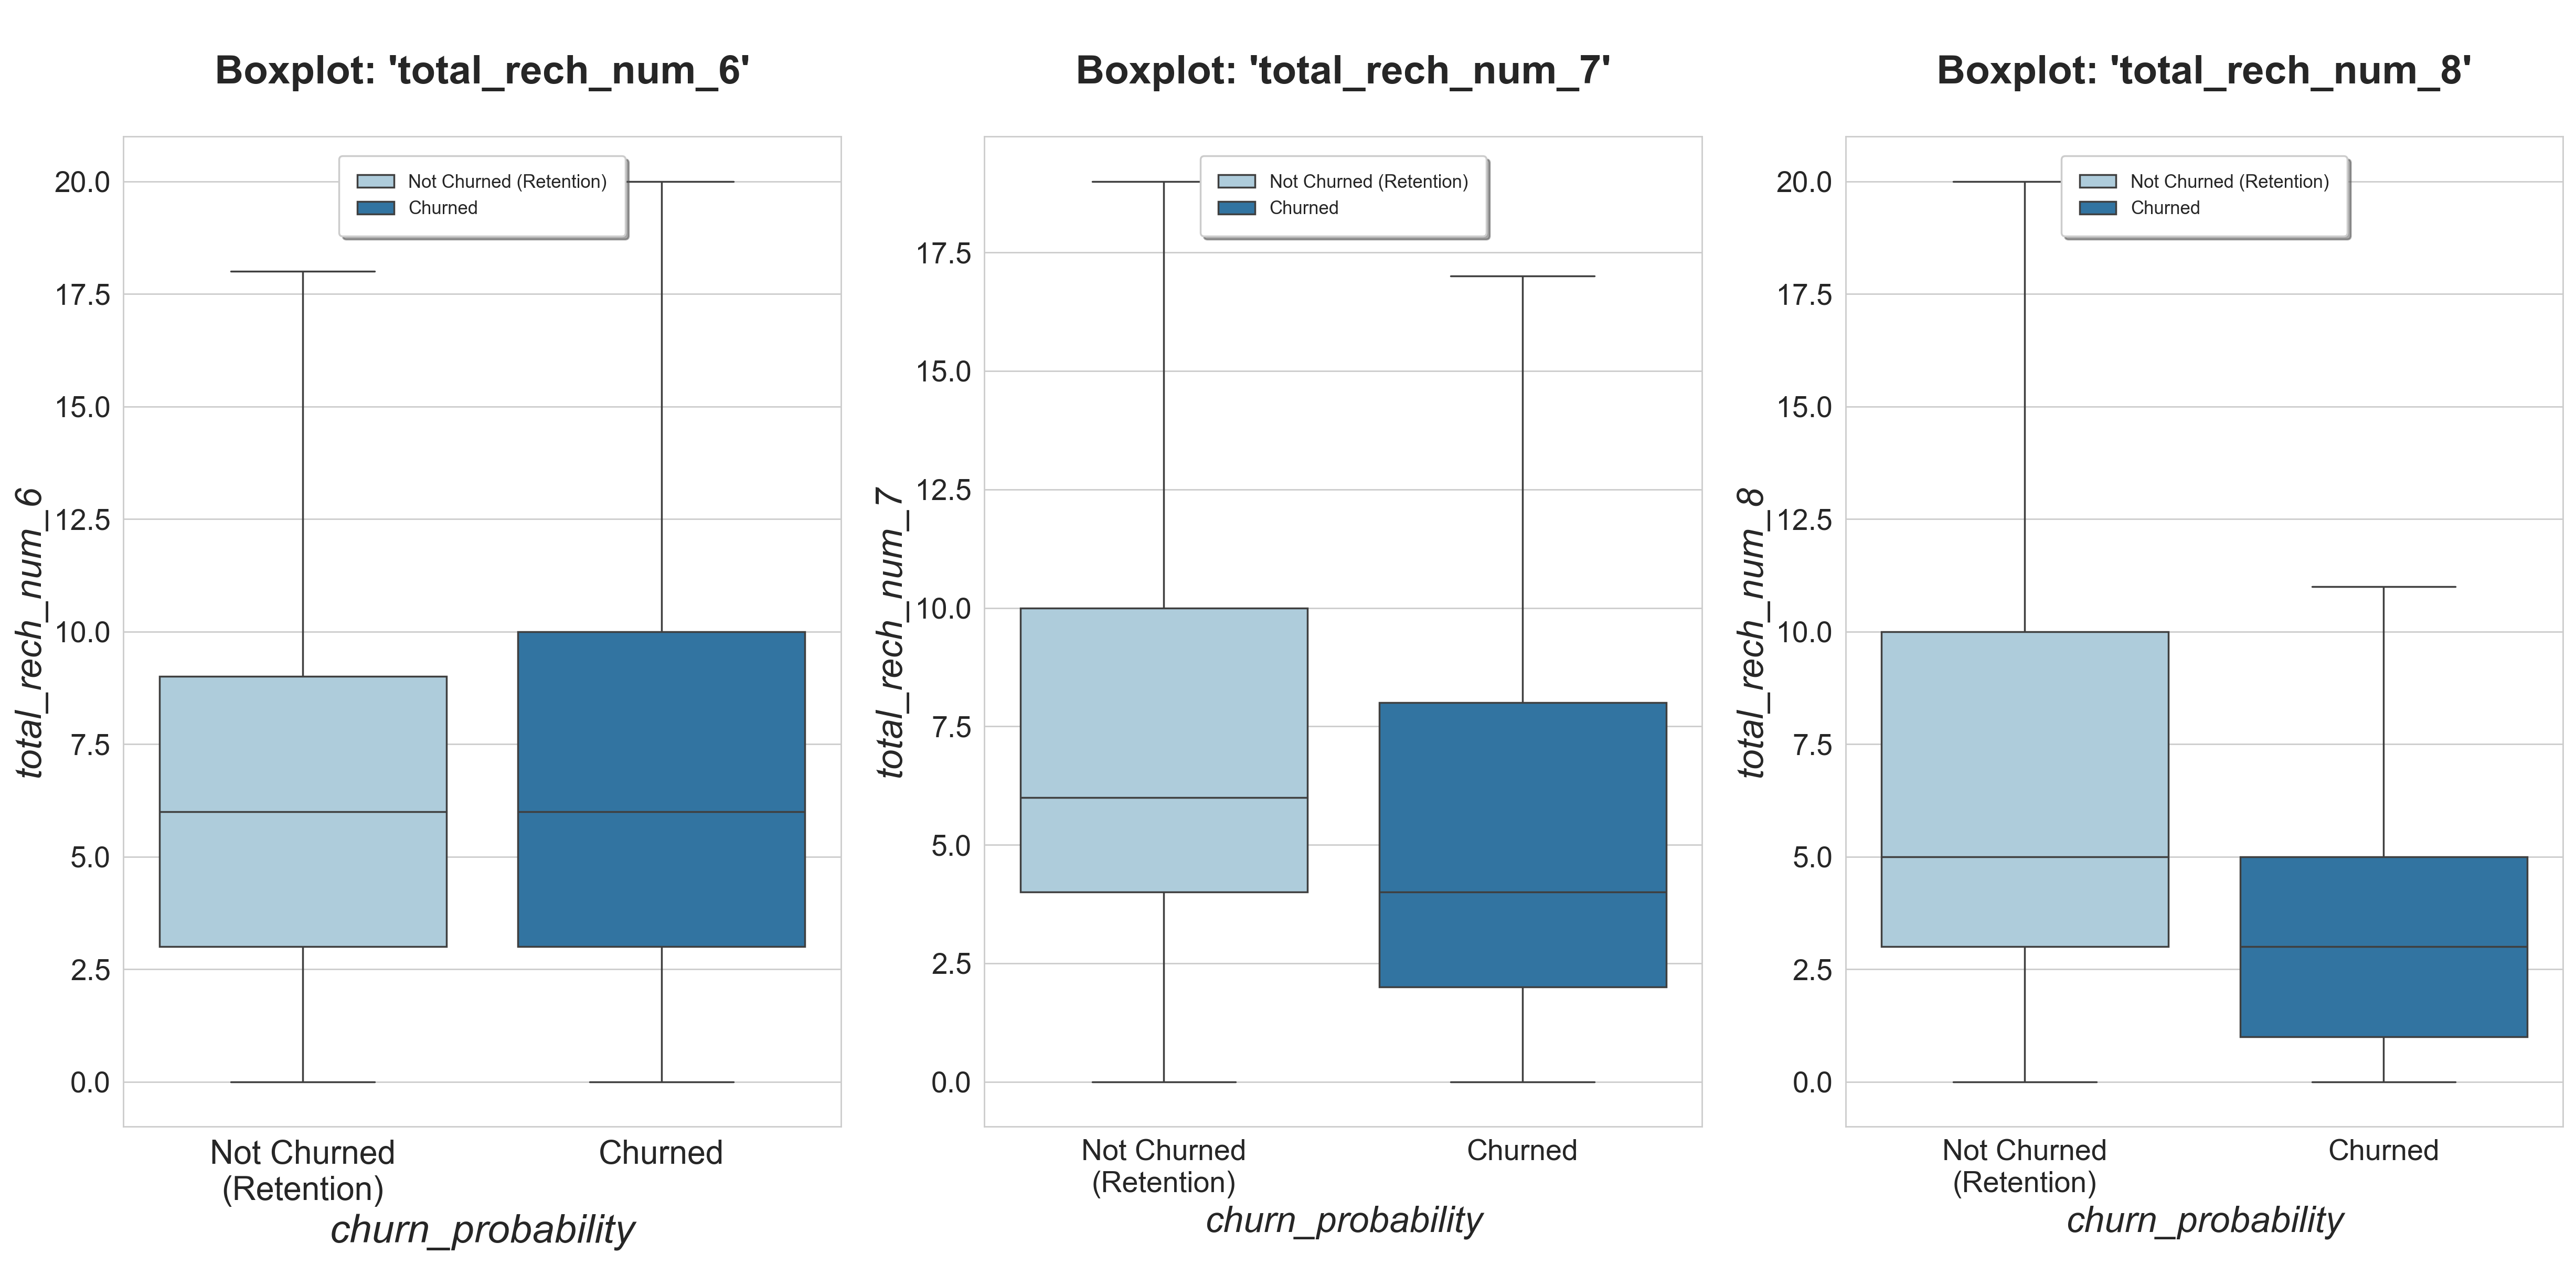

In [44]:
##Plotting boxplots for 'total_rech_num' 
plot_boxplots_6_7_8('total_rech_num')

**Observation:** A noticeable drop in the `total number of recharges` is seen in the 8th month for churned customers.

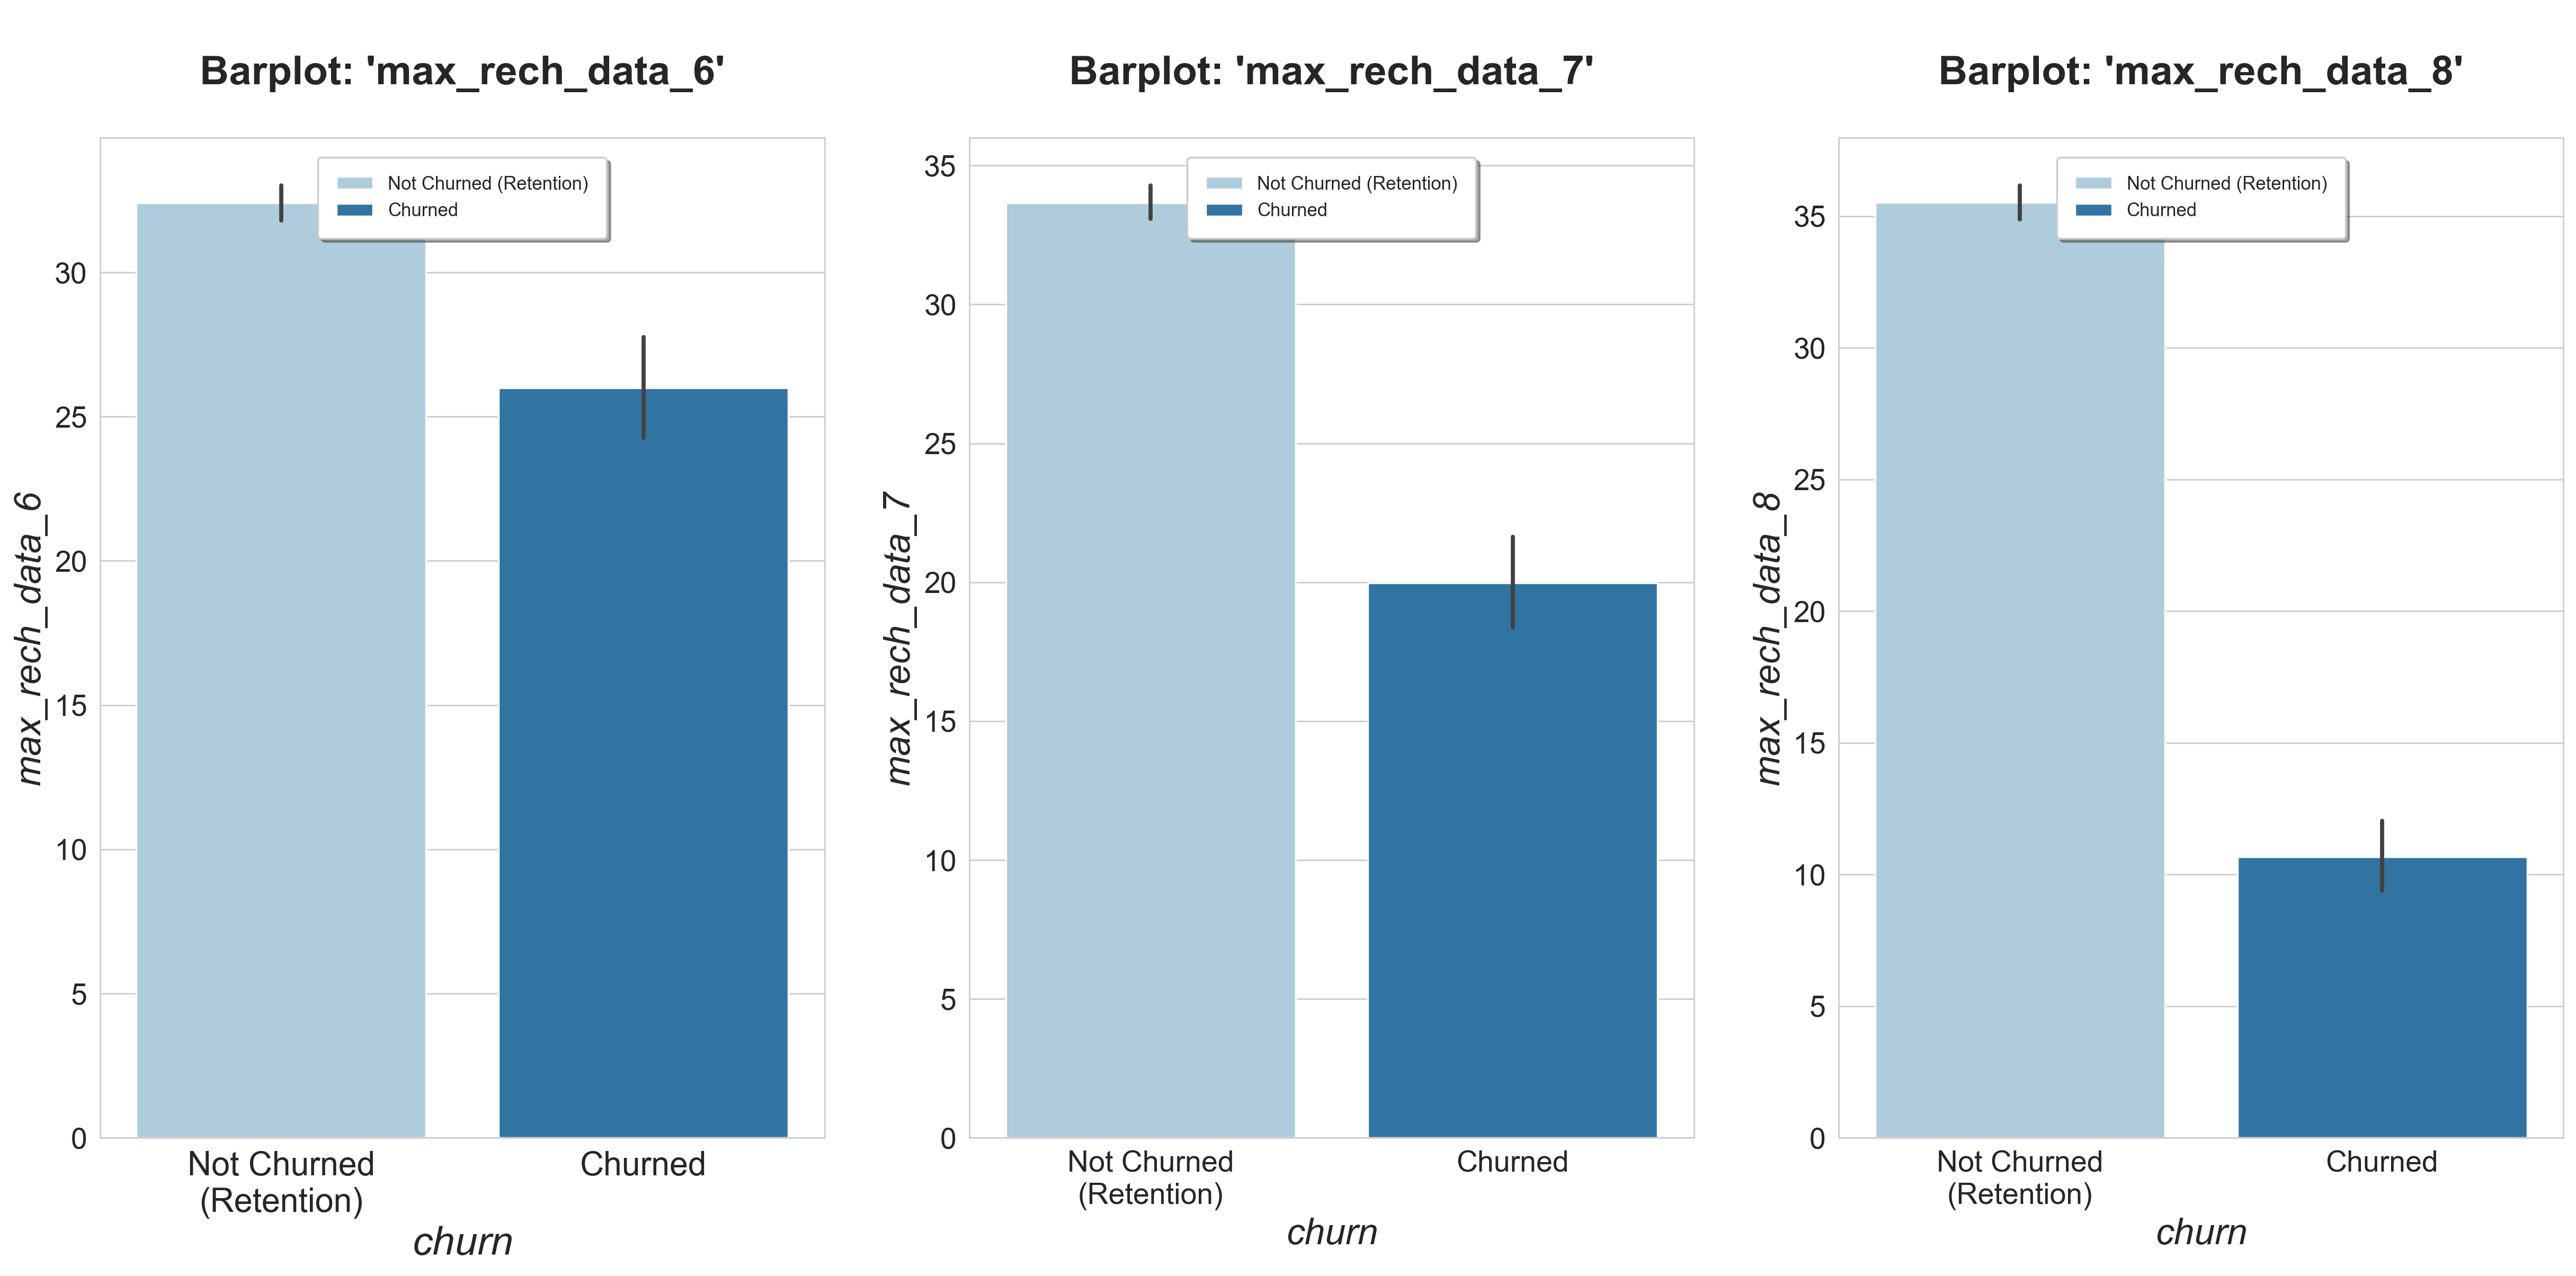

In [45]:
##Plotting boxplots for 'max_rech_data' 
plot_barplots_6_7_8('max_rech_data')

**Observation:** A significant drop in the `max_rech_data` is seen in the 8th month for churned customers.

In [46]:
##Recheck for missing values in 'recharge' plans for calling and data features
all_rech_vars = list(telecom_df.columns[telecom_df.columns.str.contains('rech_amt|rech_data_amt|rech_num|max_rech_data')])  ##Excluding 2g_3g
all_rech = telecom_df[all_rech_vars]
null_prcnt_df(all_rech)

(b) Visualizing 2G and 3G based usage attributes

In [47]:
usage_2g_3g_vars = list(telecom_df.columns[telecom_df.columns.str.contains('2g|3g',regex=True)])
usage_2g_3g_vars

['count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'vol_2g_mb_6',
 'vol_2g_mb_7',
 'vol_2g_mb_8',
 'vol_3g_mb_6',
 'vol_3g_mb_7',
 'vol_3g_mb_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8',
 'aug_vbc_3g',
 'jul_vbc_3g',
 'jun_vbc_3g']

In [48]:
##Check for missing values
usage_2g_3g = telecom_df[usage_2g_3g_vars]
null_prcnt_df(usage_2g_3g)

**Observations:** More than 74% missing values exist in `'arpu_2g'`, `'arpu_3g'`, `'count_rech_2g'` and `'count_rech_3g'` features for all the 3 months. These are revenue based features counting towards 2G and 3G. Moreover, there are more than 74% missing values. Hence, we drop these columns .

In [49]:
##Dropping 'arpu_2g', 'arpu_3g', 'count_rech_2g' and 'count_rech_3g' based features (revenue_based)
drop_vars = list(telecom_df.columns[telecom_df.columns.str.contains('arpu_2g|arpu_3g|count_rech_2g_|count_rech_3g')])
telecom_df.drop(drop_vars, axis=1, inplace=True)

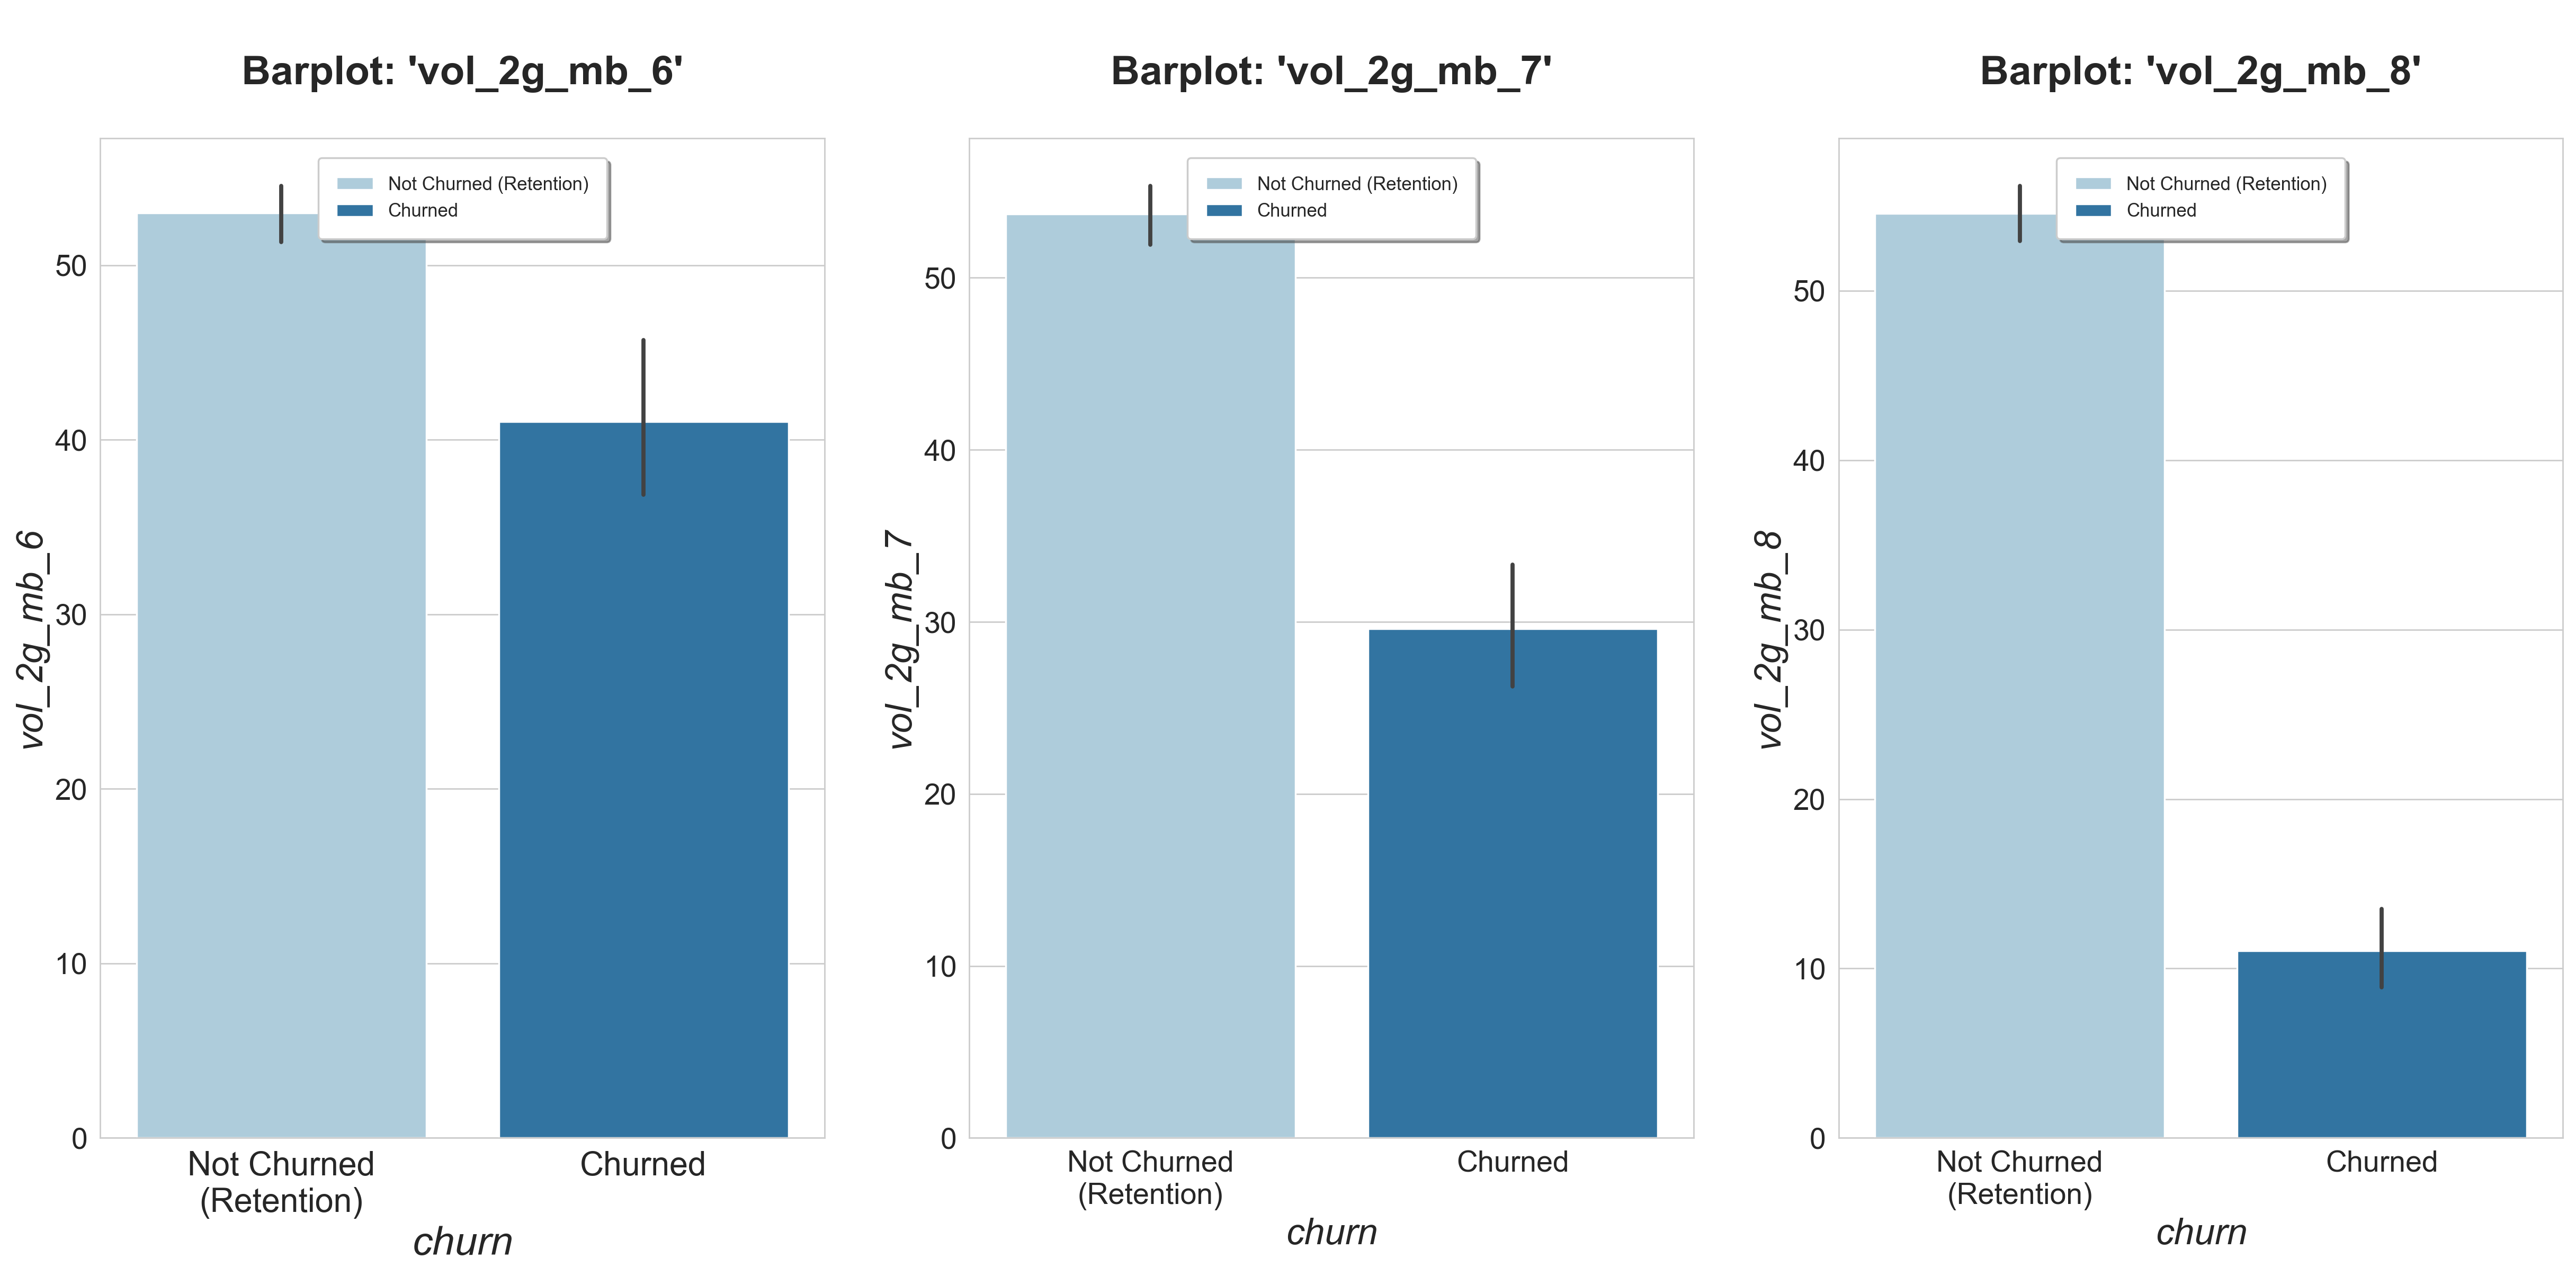

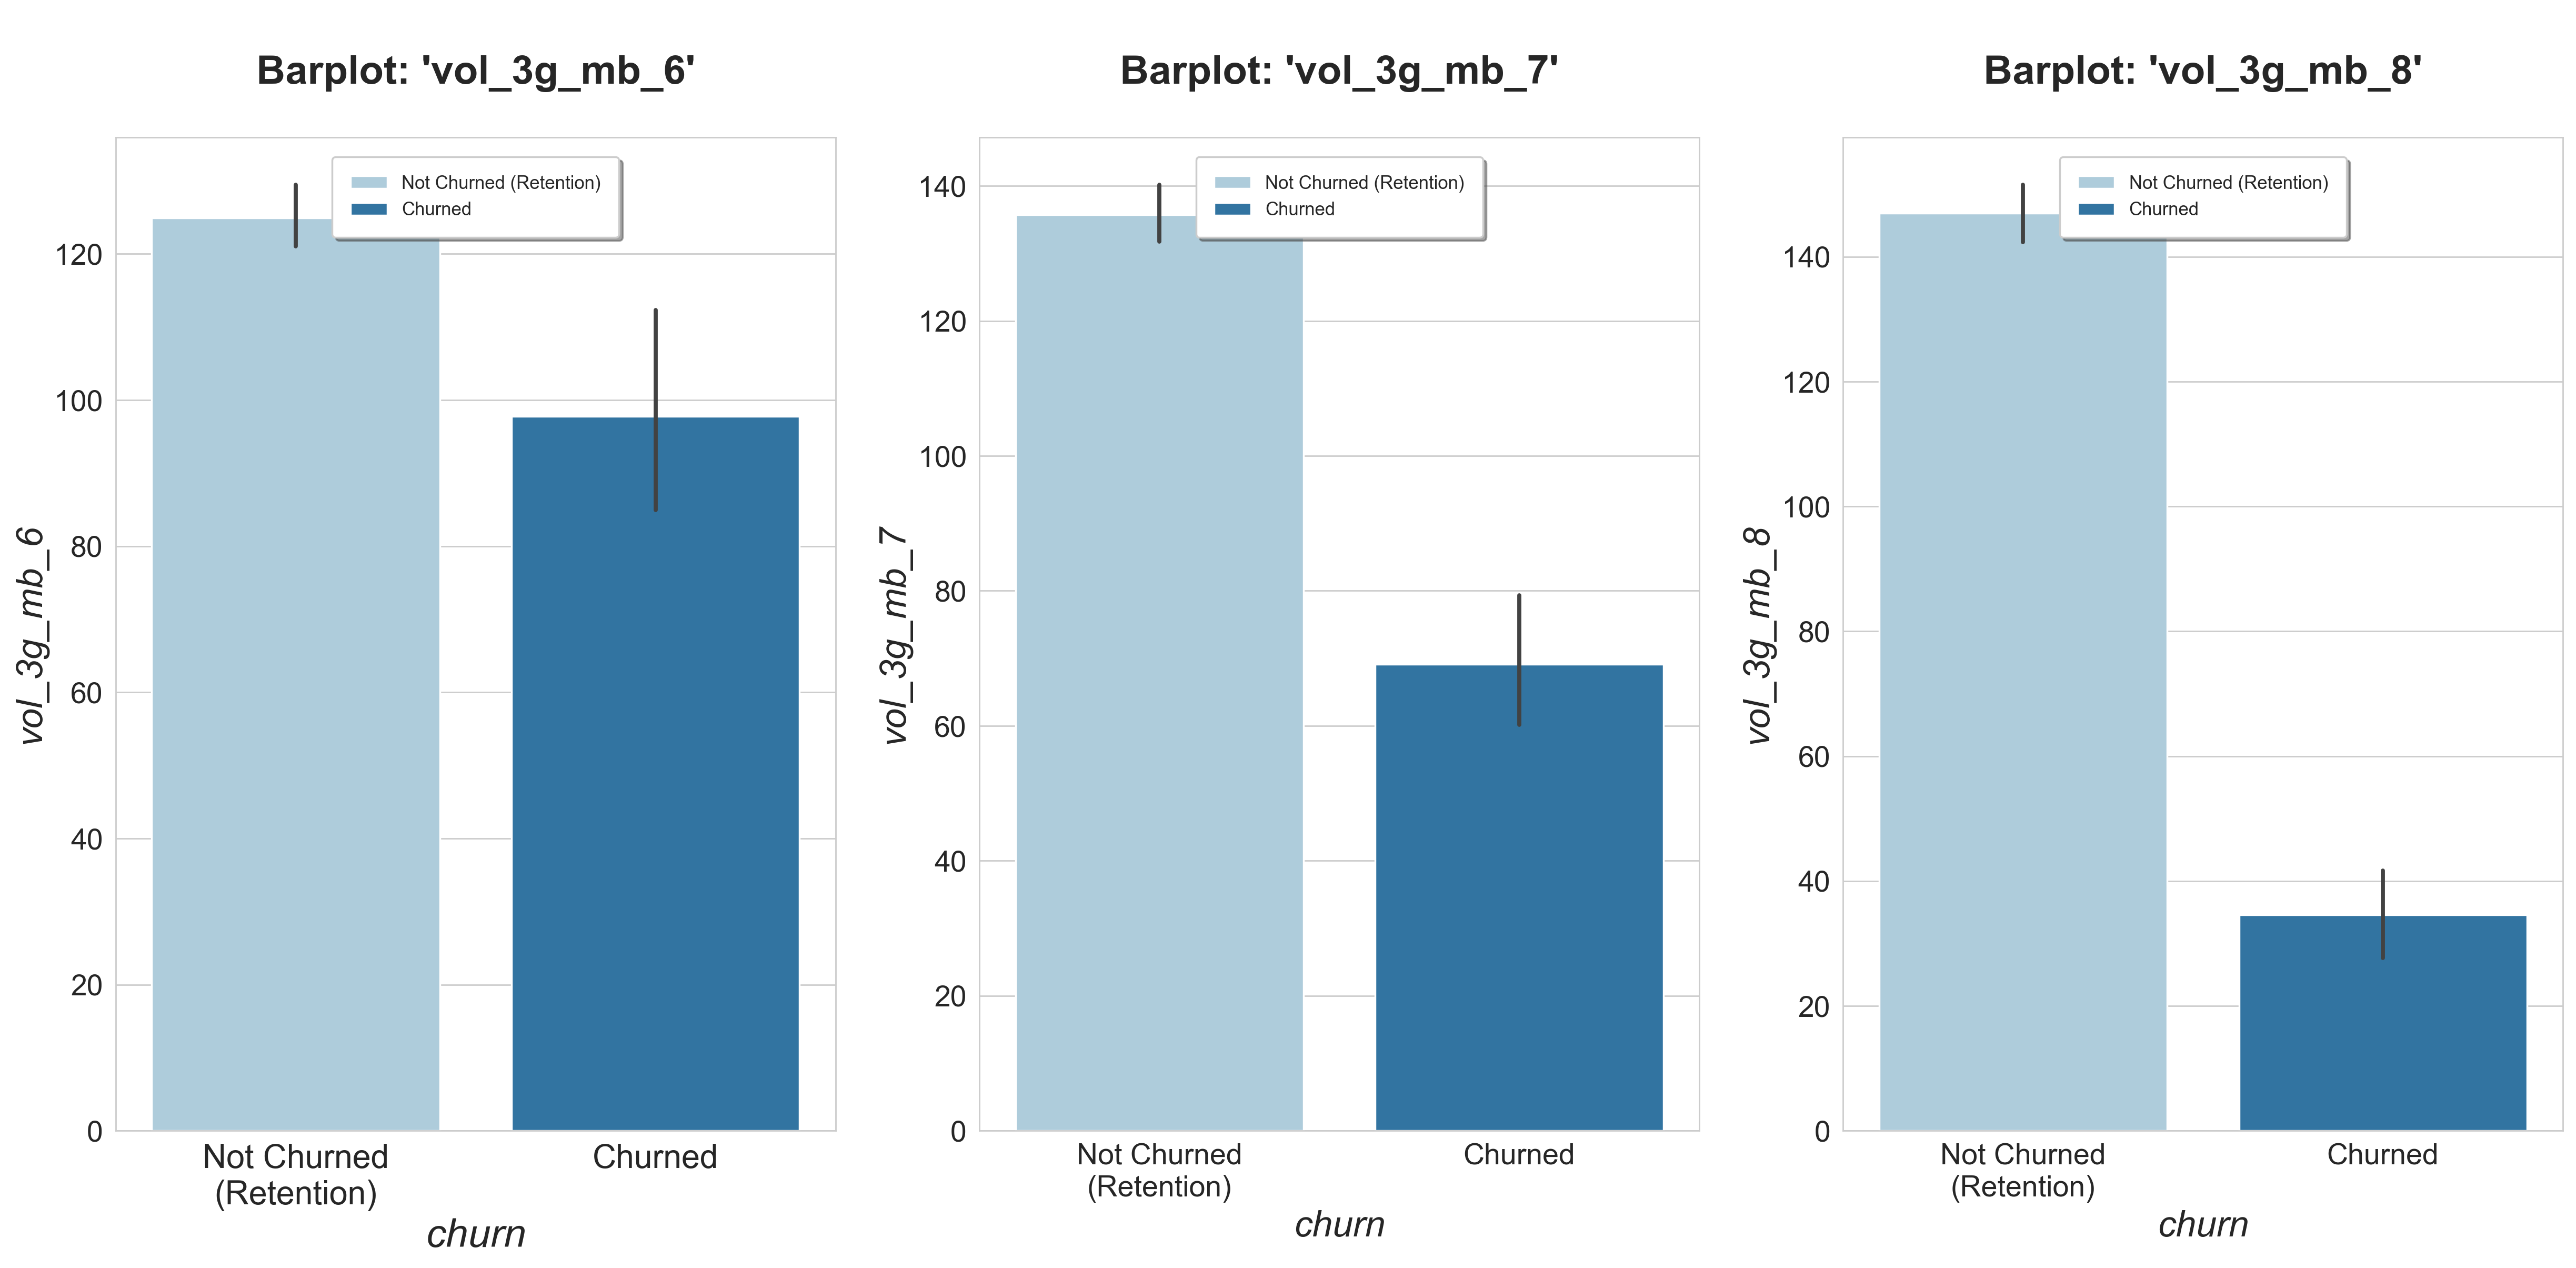

In [50]:
##Plotting volume of data usage:  

##Plotting volume of 2G data usage features:
plot_barplots_6_7_8('vol_2g_mb')

##Plotting volume of 3G data usage features:
plot_barplots_6_7_8('vol_3g_mb')

**Observations:**
(i) The volume of 2G and 3G data usage substantially drops in the 8th month for churned customers.


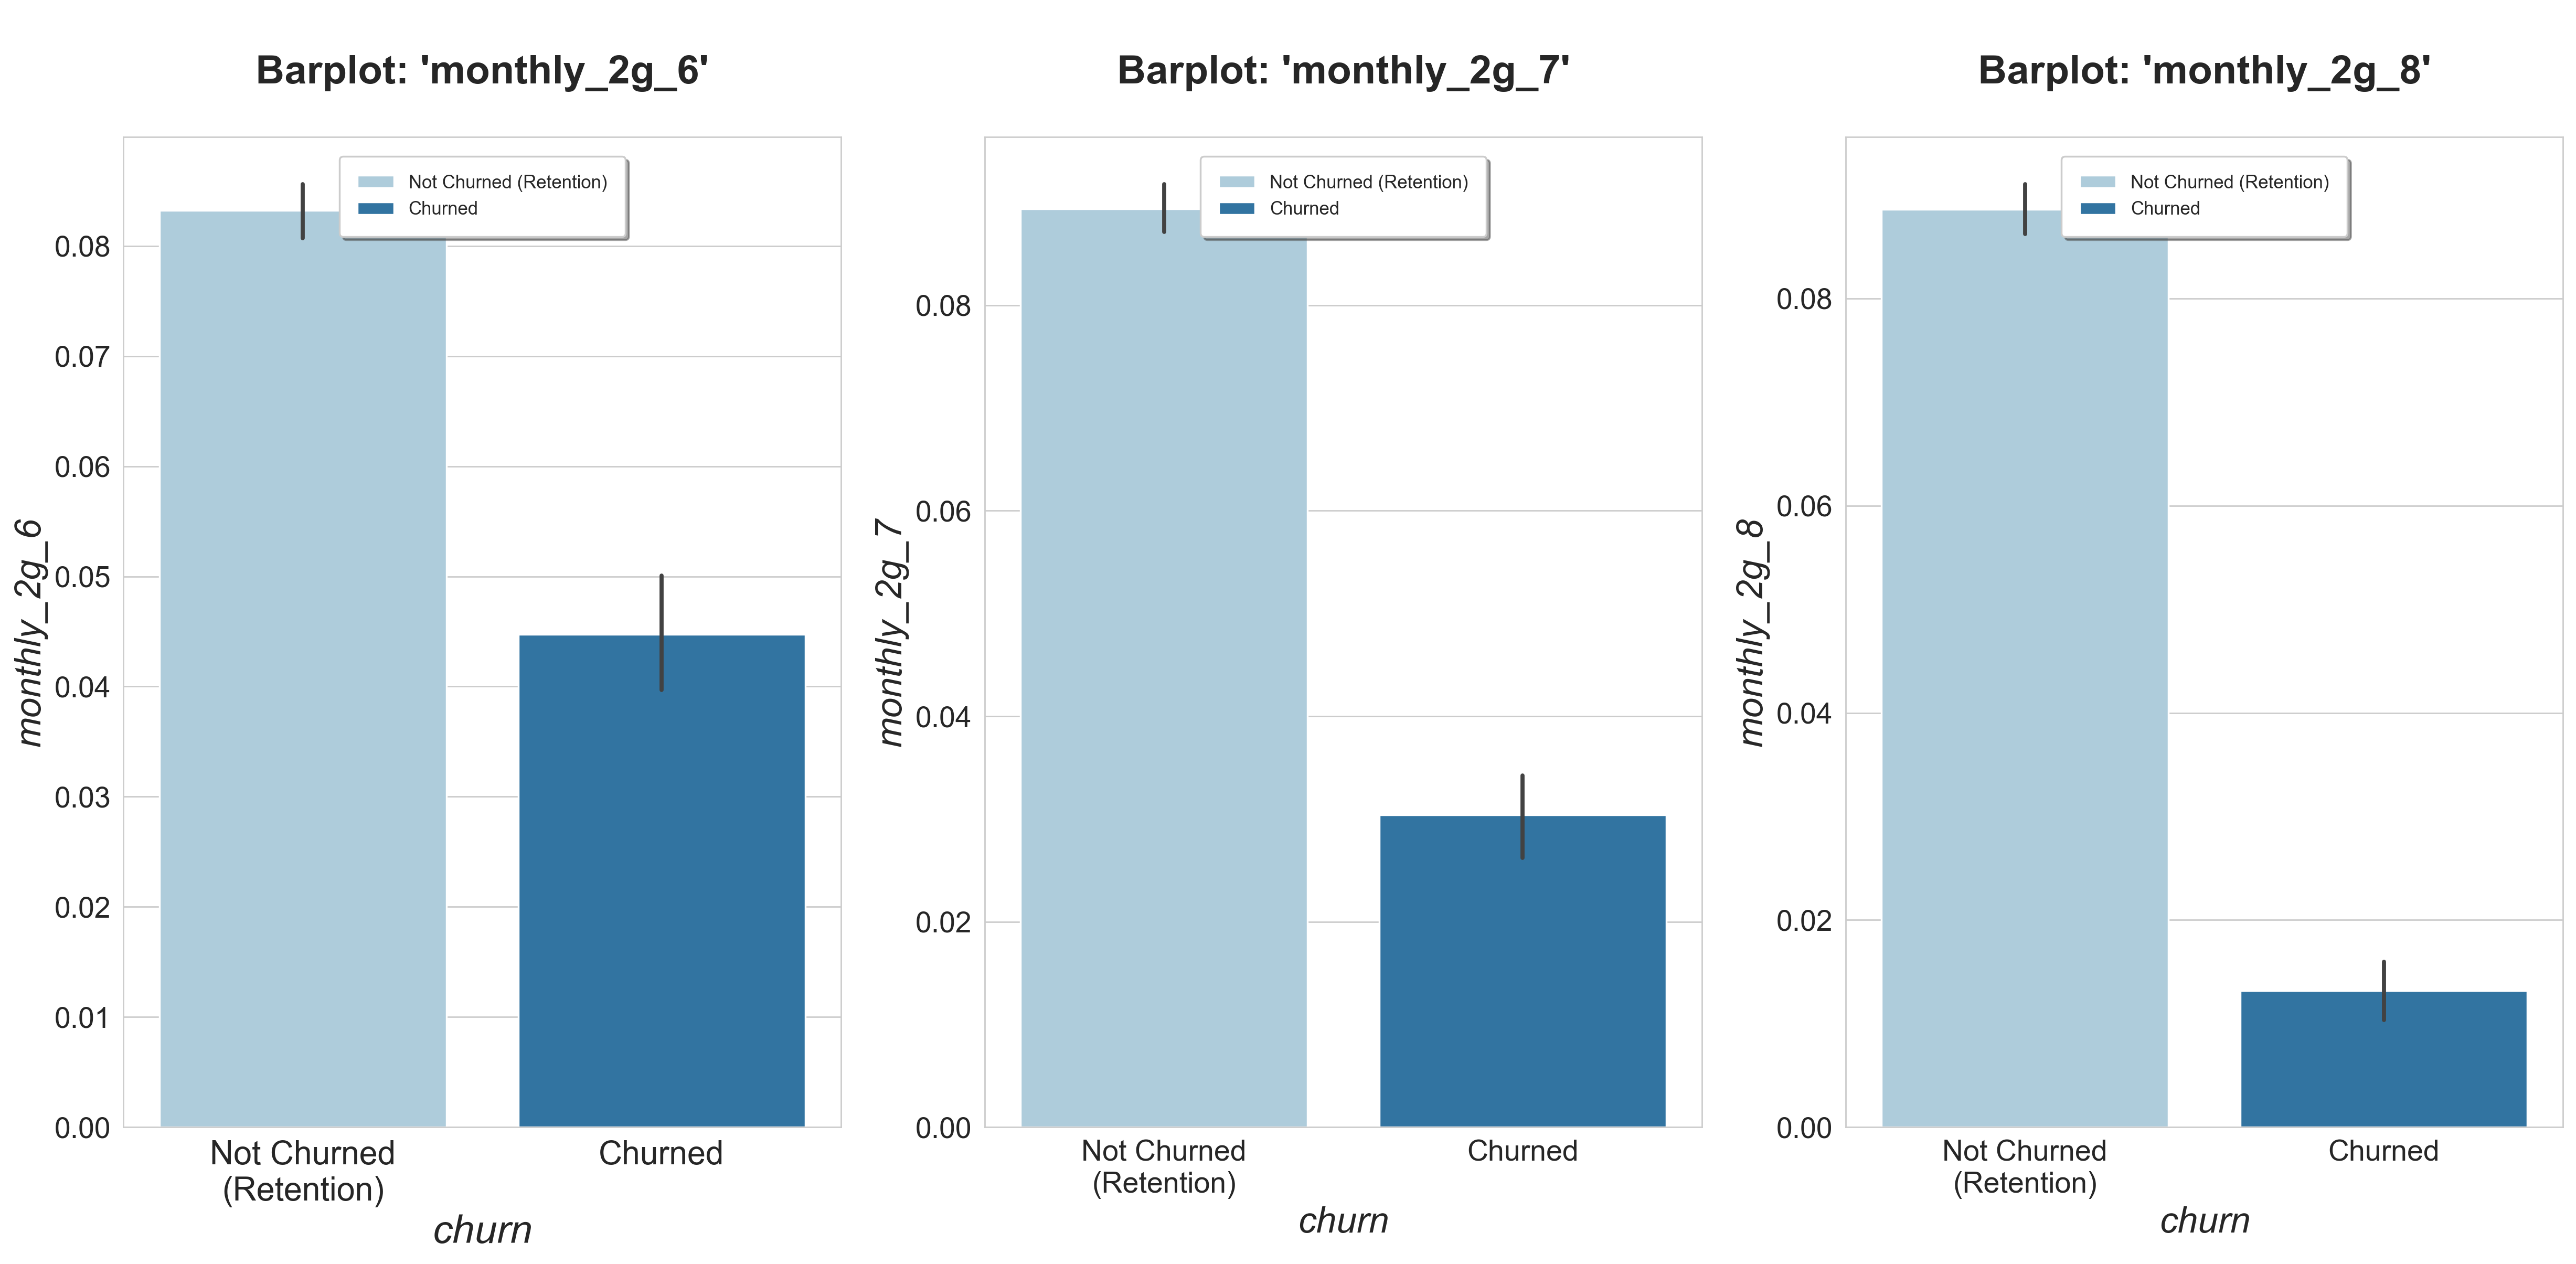

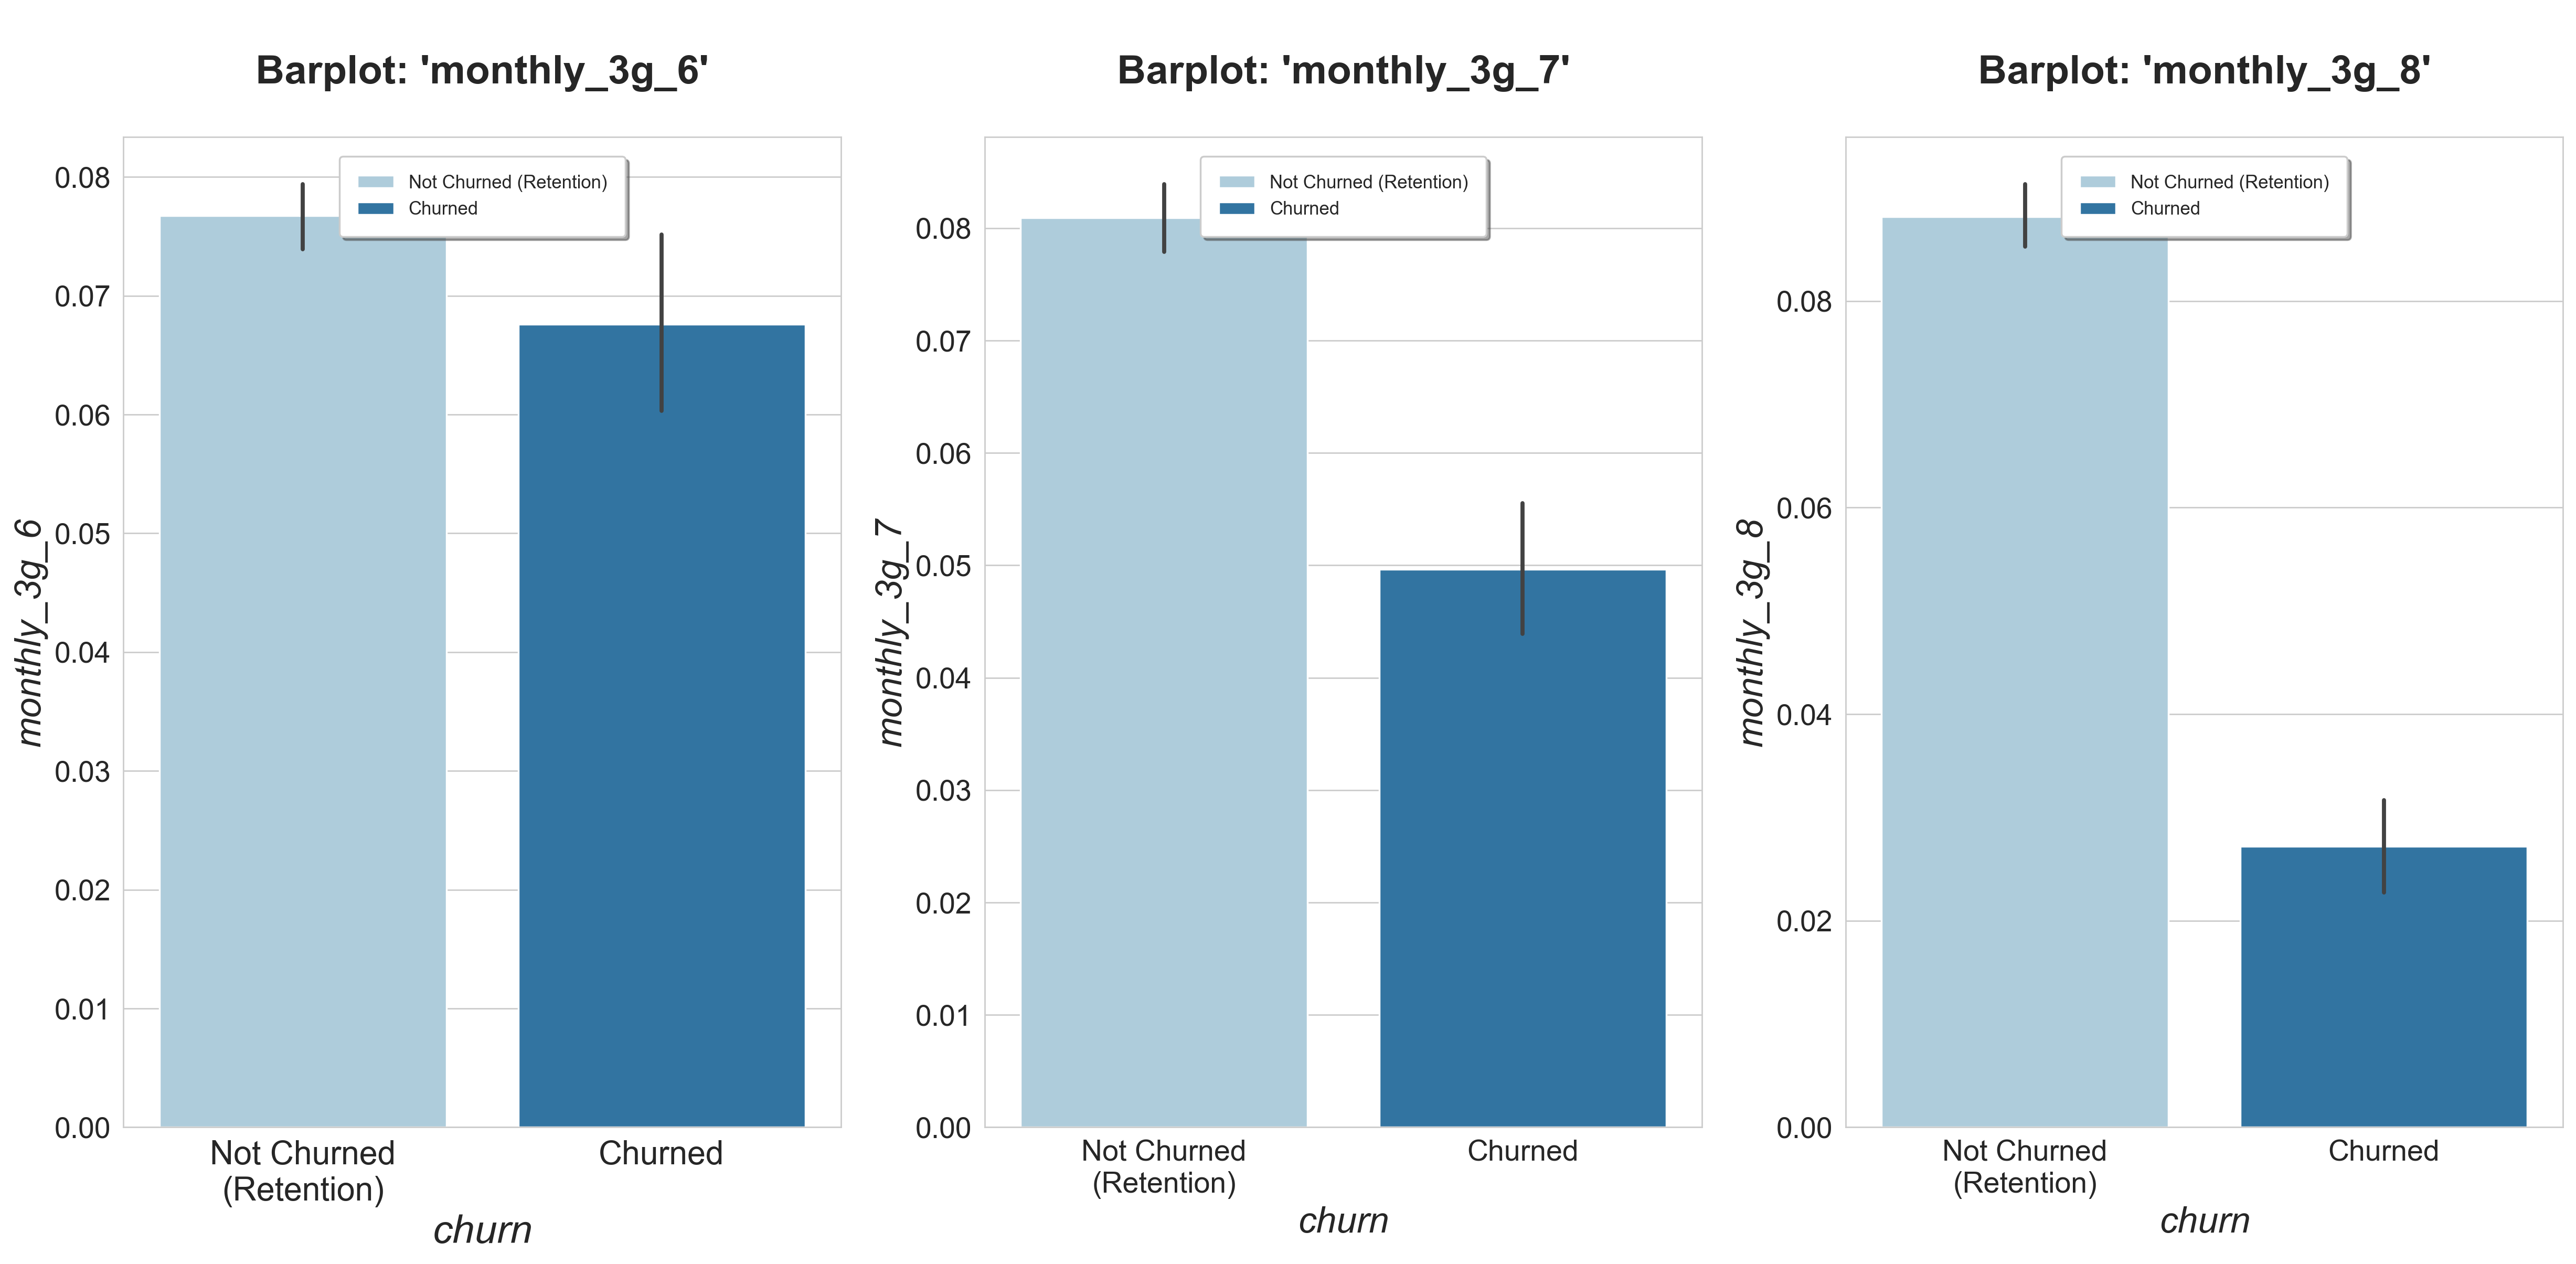

In [51]:
#Barplots for 'monthly_2g' and 'monthly_3g' usage check
plot_barplots_6_7_8('monthly_2g')  #monthly_2g for all 3 months
plot_barplots_6_7_8('monthly_3g')   #monthly_3g for all 3 months

**Observation:** Again we can see a drop in monthly 2G and 3G subscriptions for churned customers in 8th Month

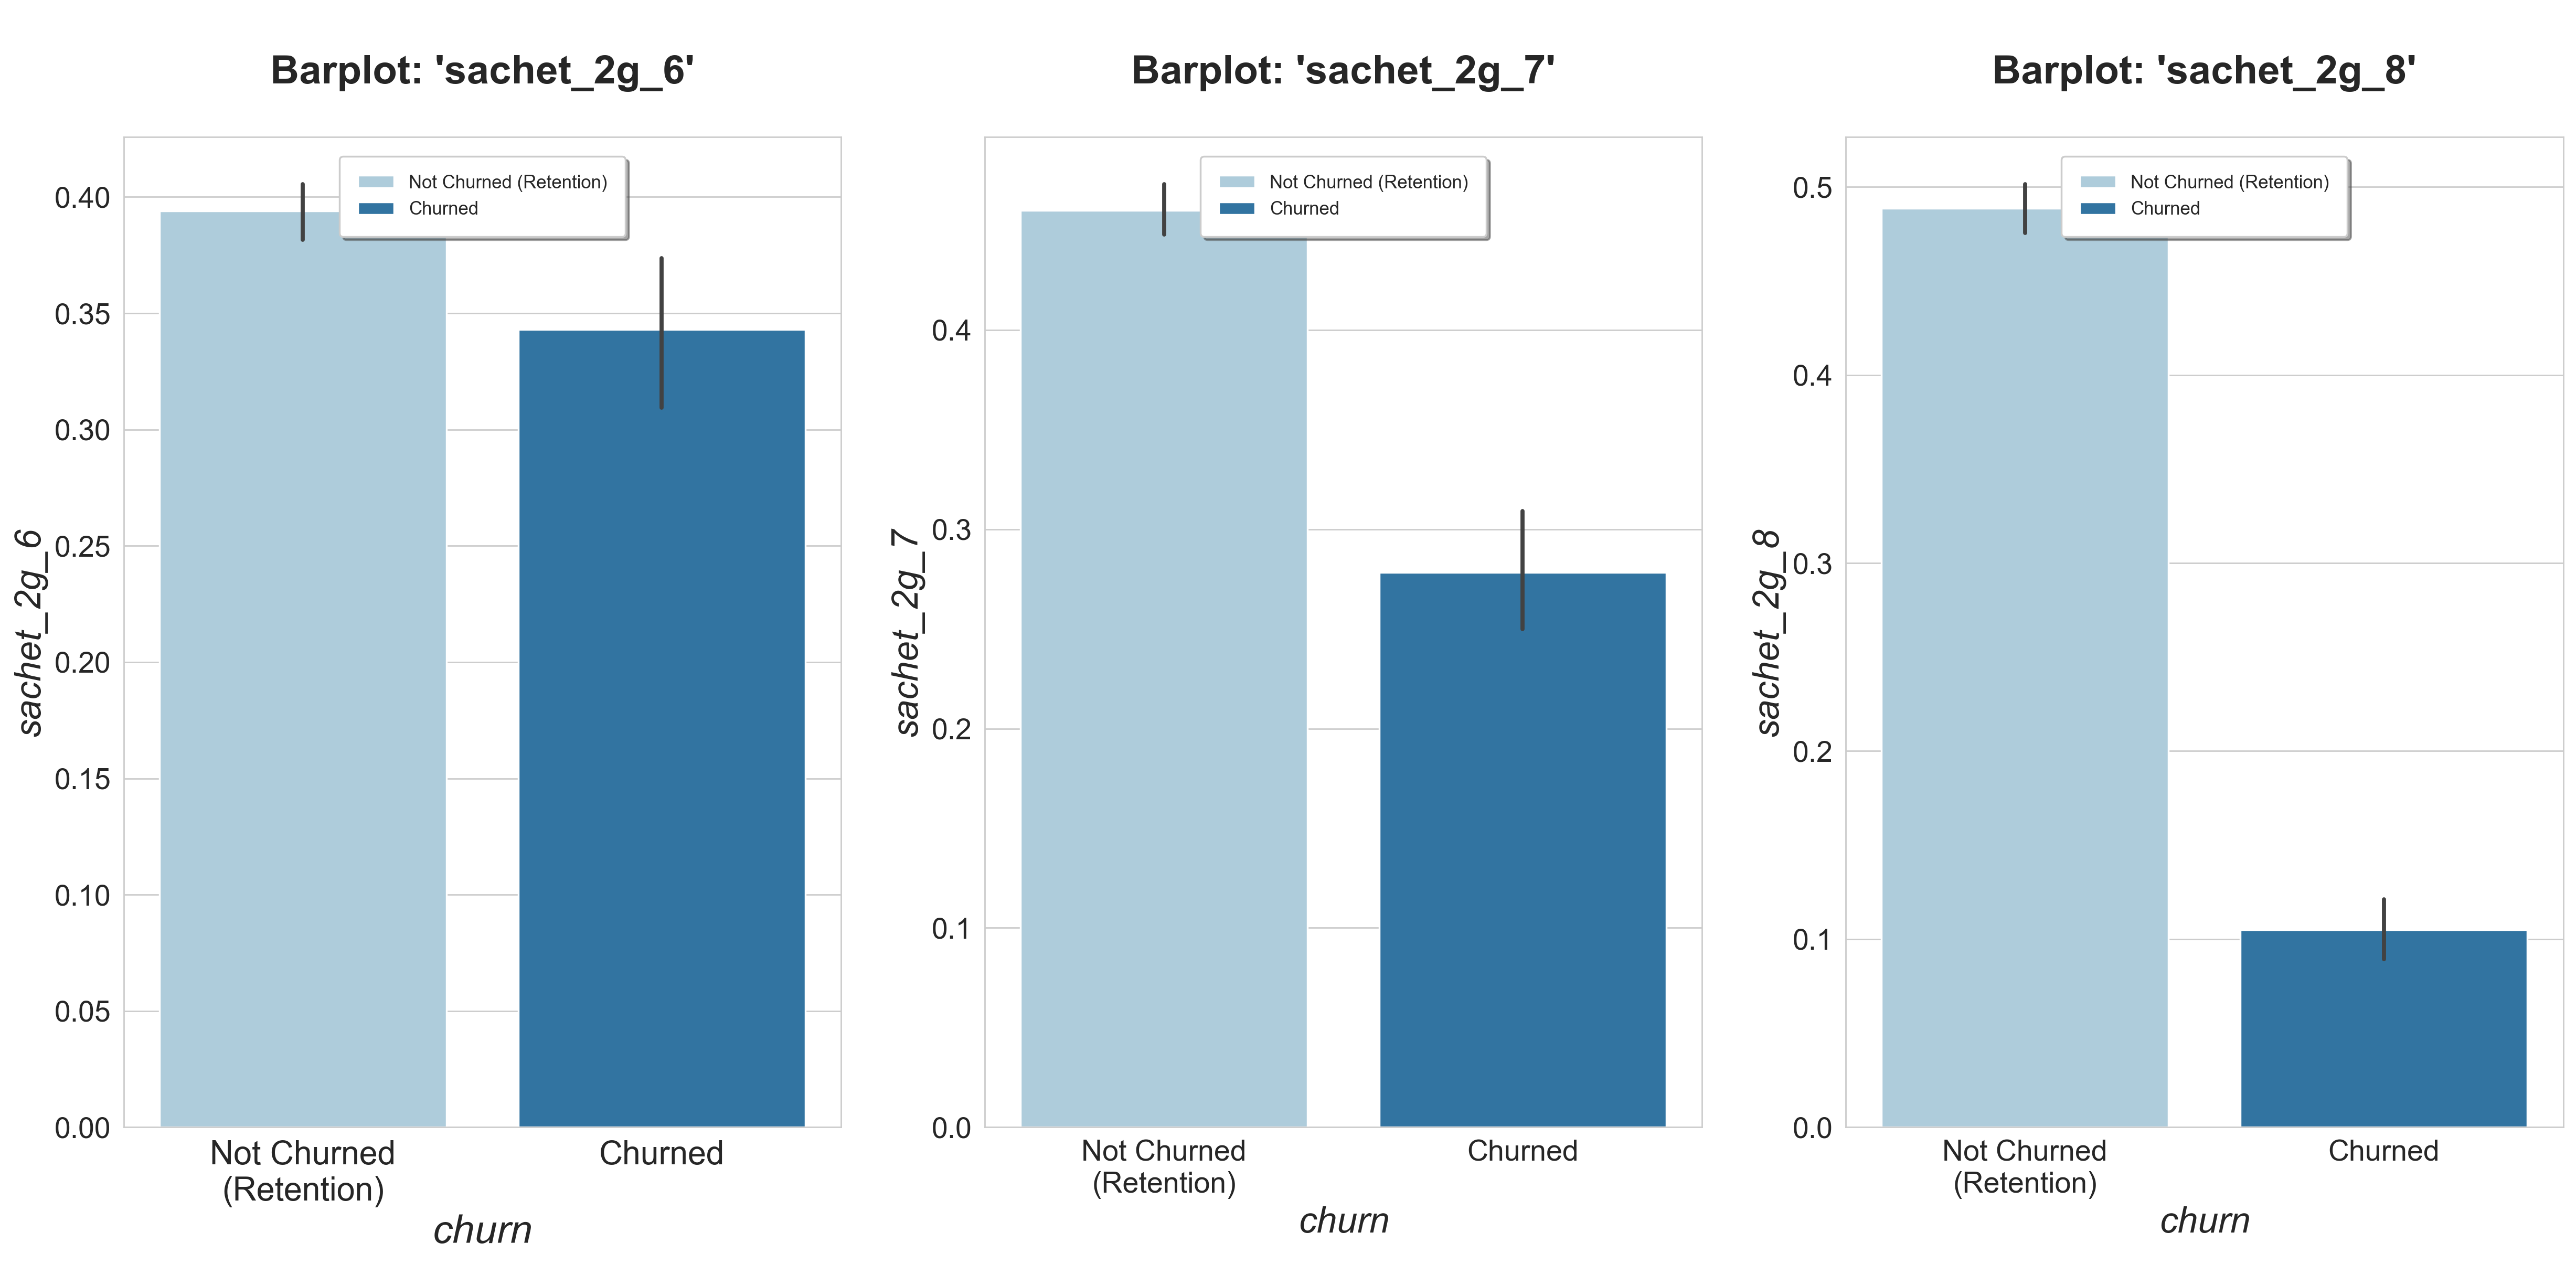

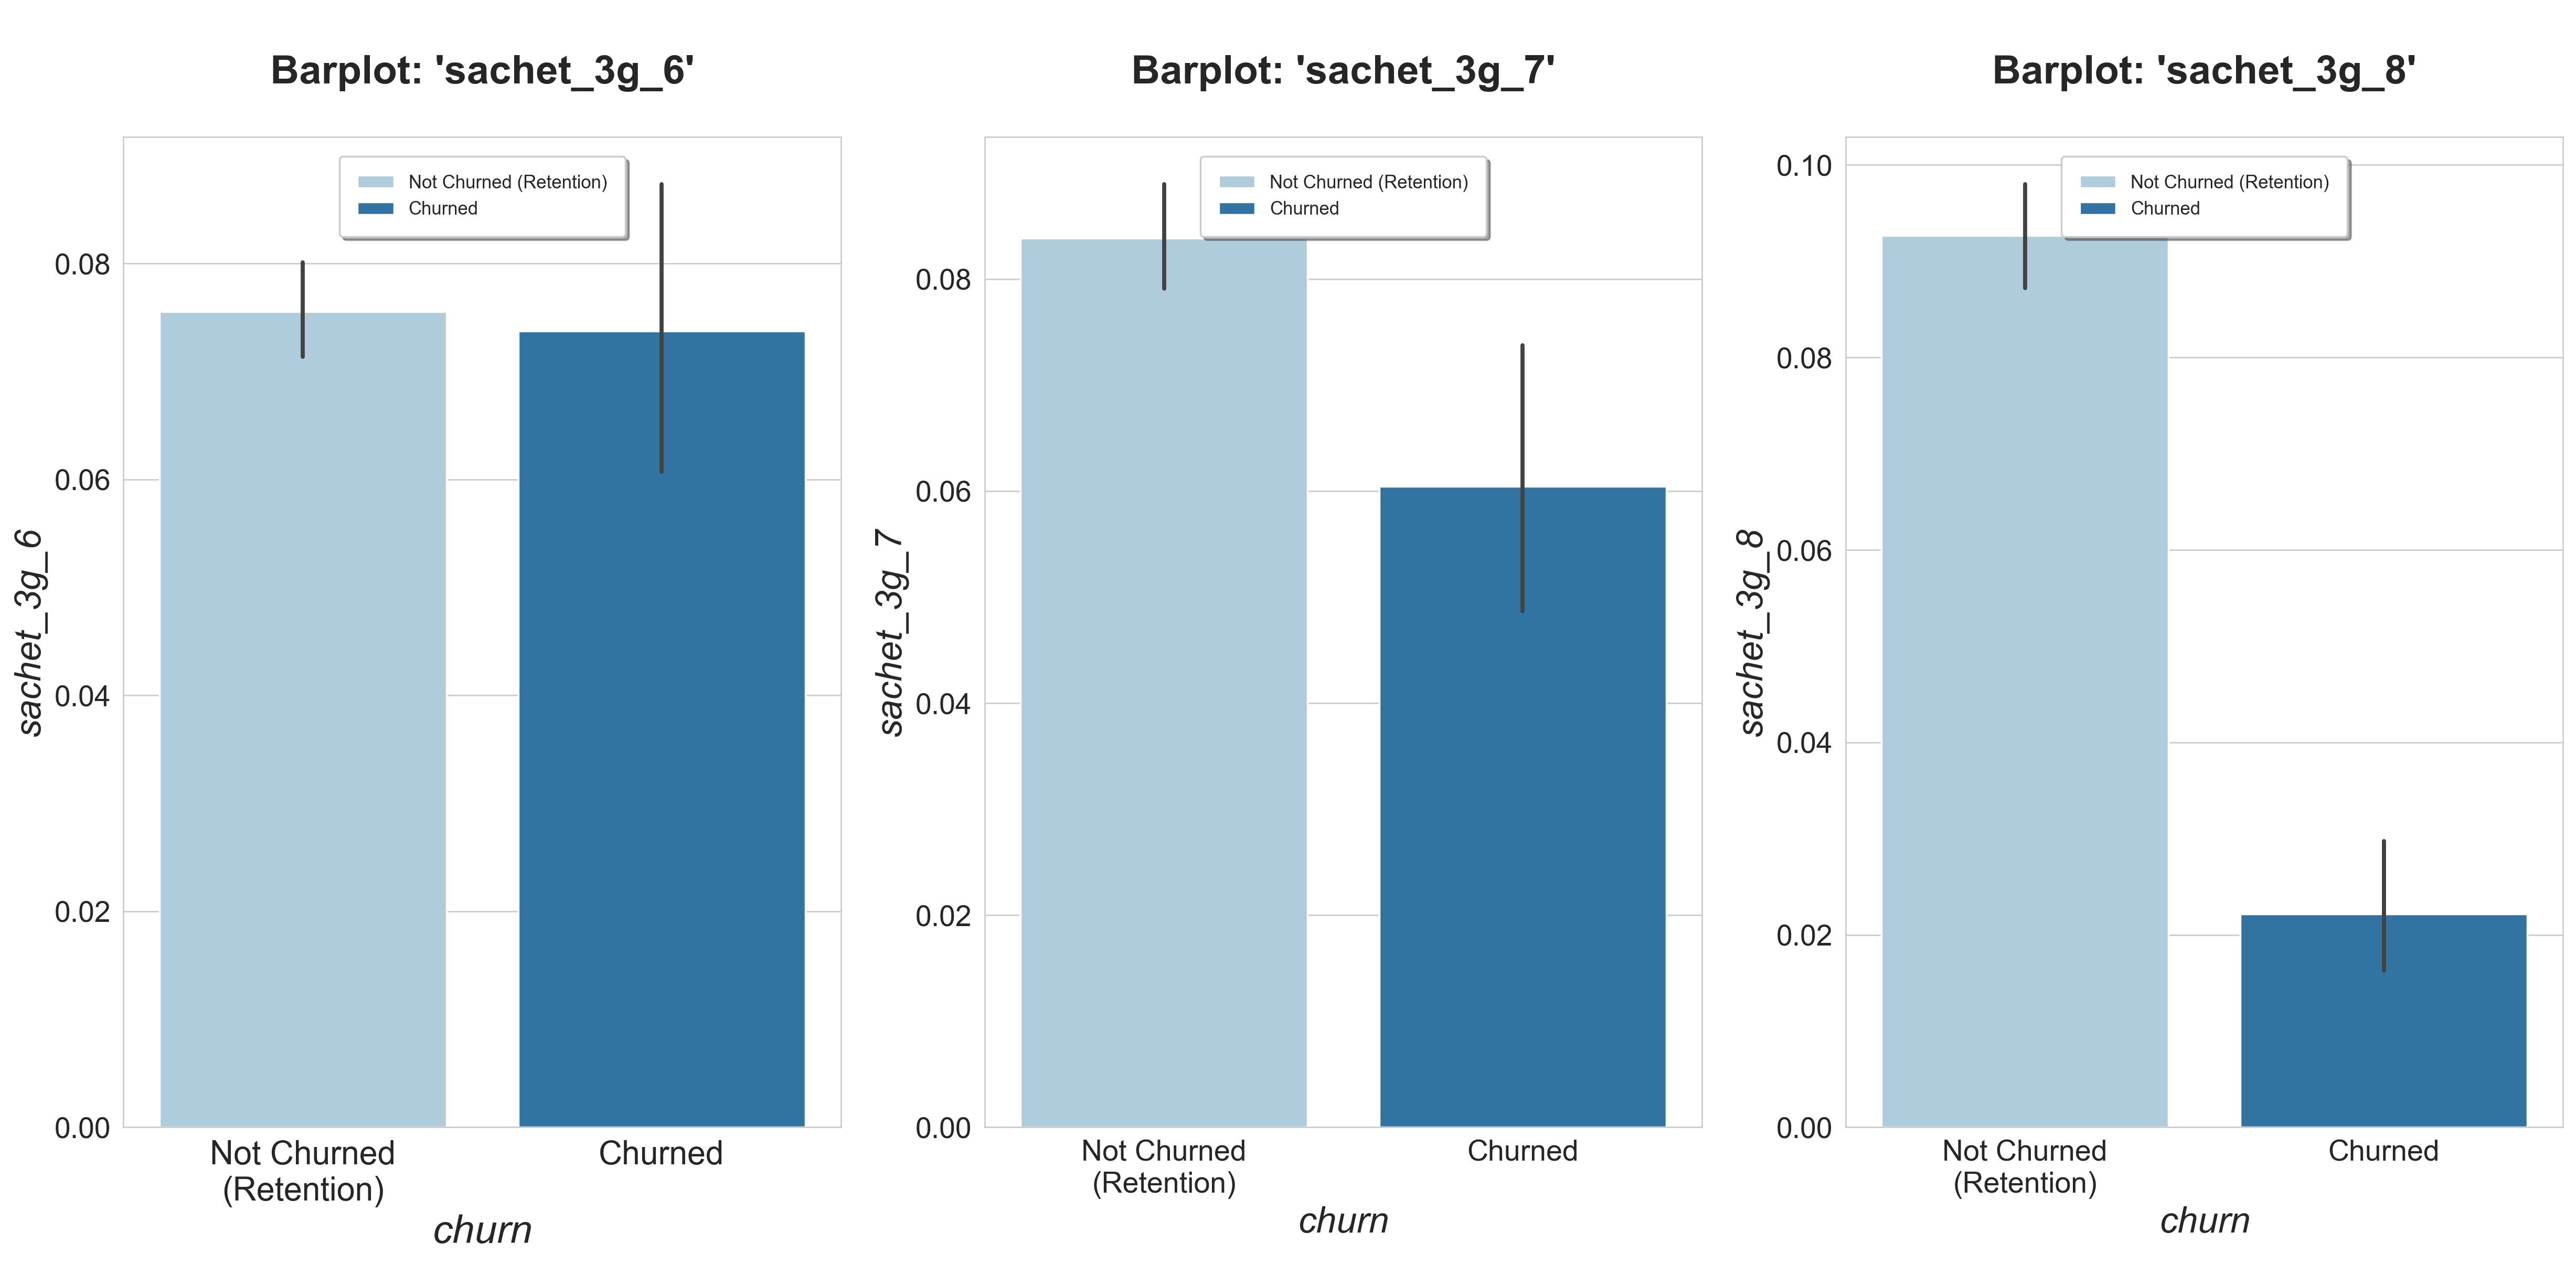

In [52]:
##Checking service schemes with validity smaller than a month for 2G/3G (sachet_2g') and ('sachet_3g') features

plot_barplots_6_7_8('sachet_2g')  #sachet_2g (service schemes with validity smaller than a month): for all 3 months
plot_barplots_6_7_8('sachet_3g')   #sachet_3g (service schemes with validity smaller than a month): for all 3 months

**Observations:** We see that the `'sachet_2g'` and `'sachet_3g'` schemes we largely used in the first and second months i.e. month (6) and (7) and then the trend shows a sudden drop in the usage as we approach the 8th month for churned customers.

(c) Check for Volume Based Cost (vbc)

In [53]:
##Volume Based Cost (vbc) based features
vbc_cols_list = list(telecom_df.columns[telecom_df.columns.str.contains('vbc')])
vbc_cols_list

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']

In [54]:
##Rename vbc features to the desired format ending with month number
telecom_df.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g': 'vbc_3g_7', 'aug_vbc_3g': 'vbc_3g_8'}, inplace=True)

In [55]:
##Recheck rename Volume Based Cost (vbc) based features
vbc_cols_list = list(telecom_df.columns[telecom_df.columns.str.contains('vbc')])
vbc_cols_list

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']

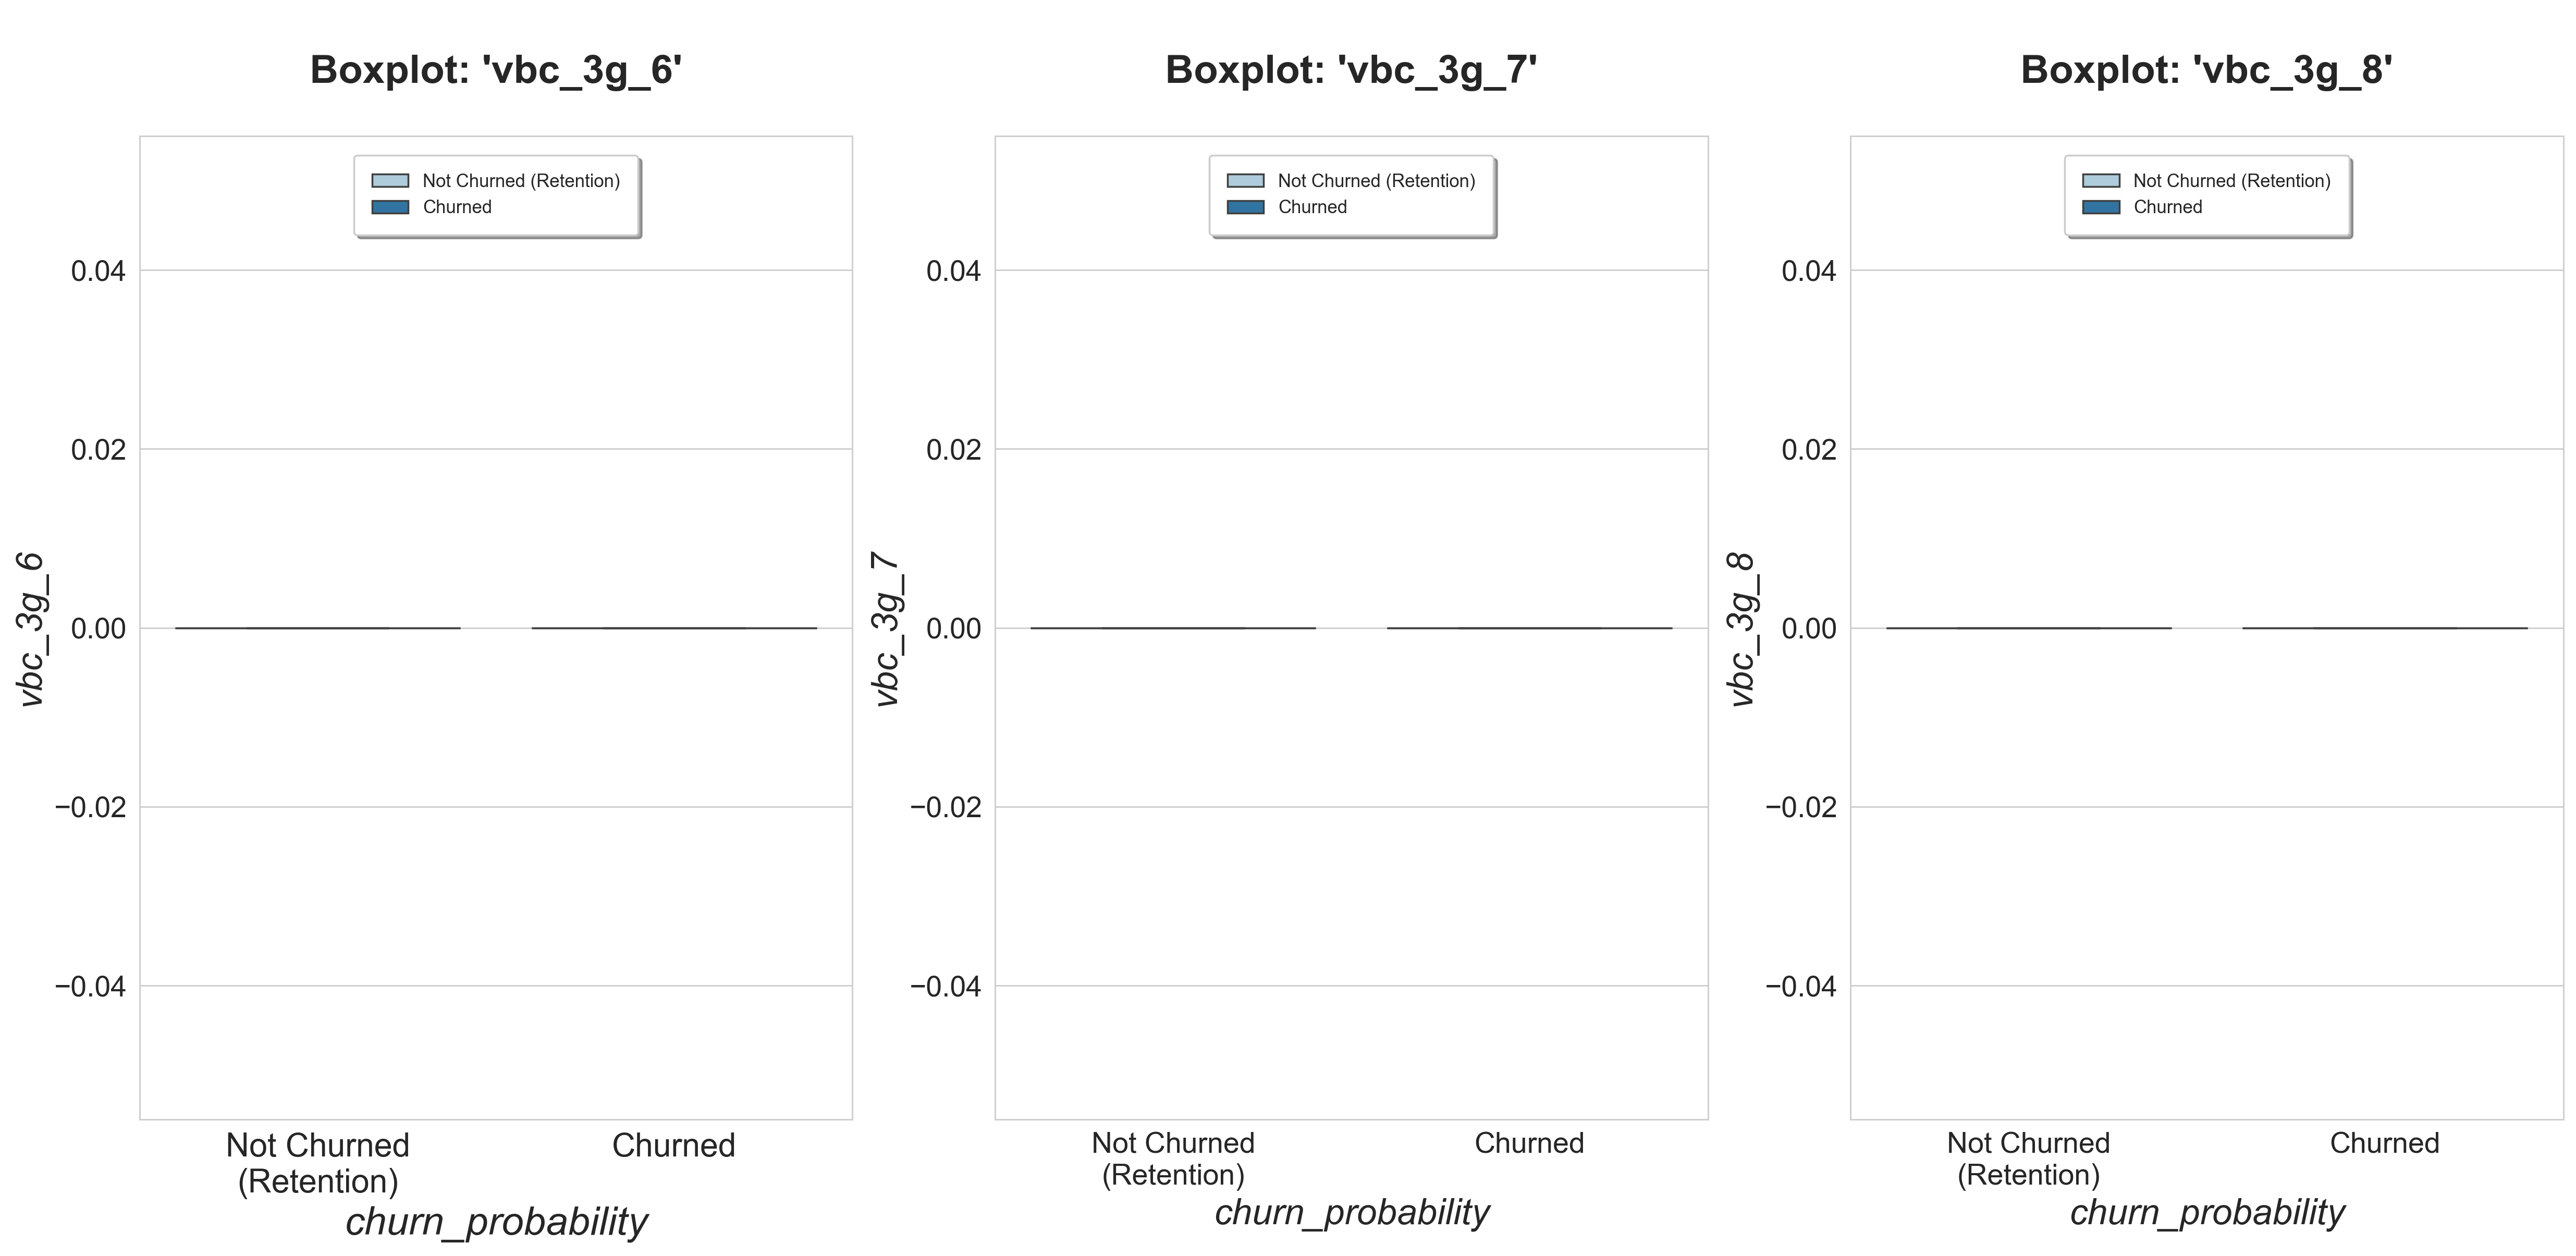

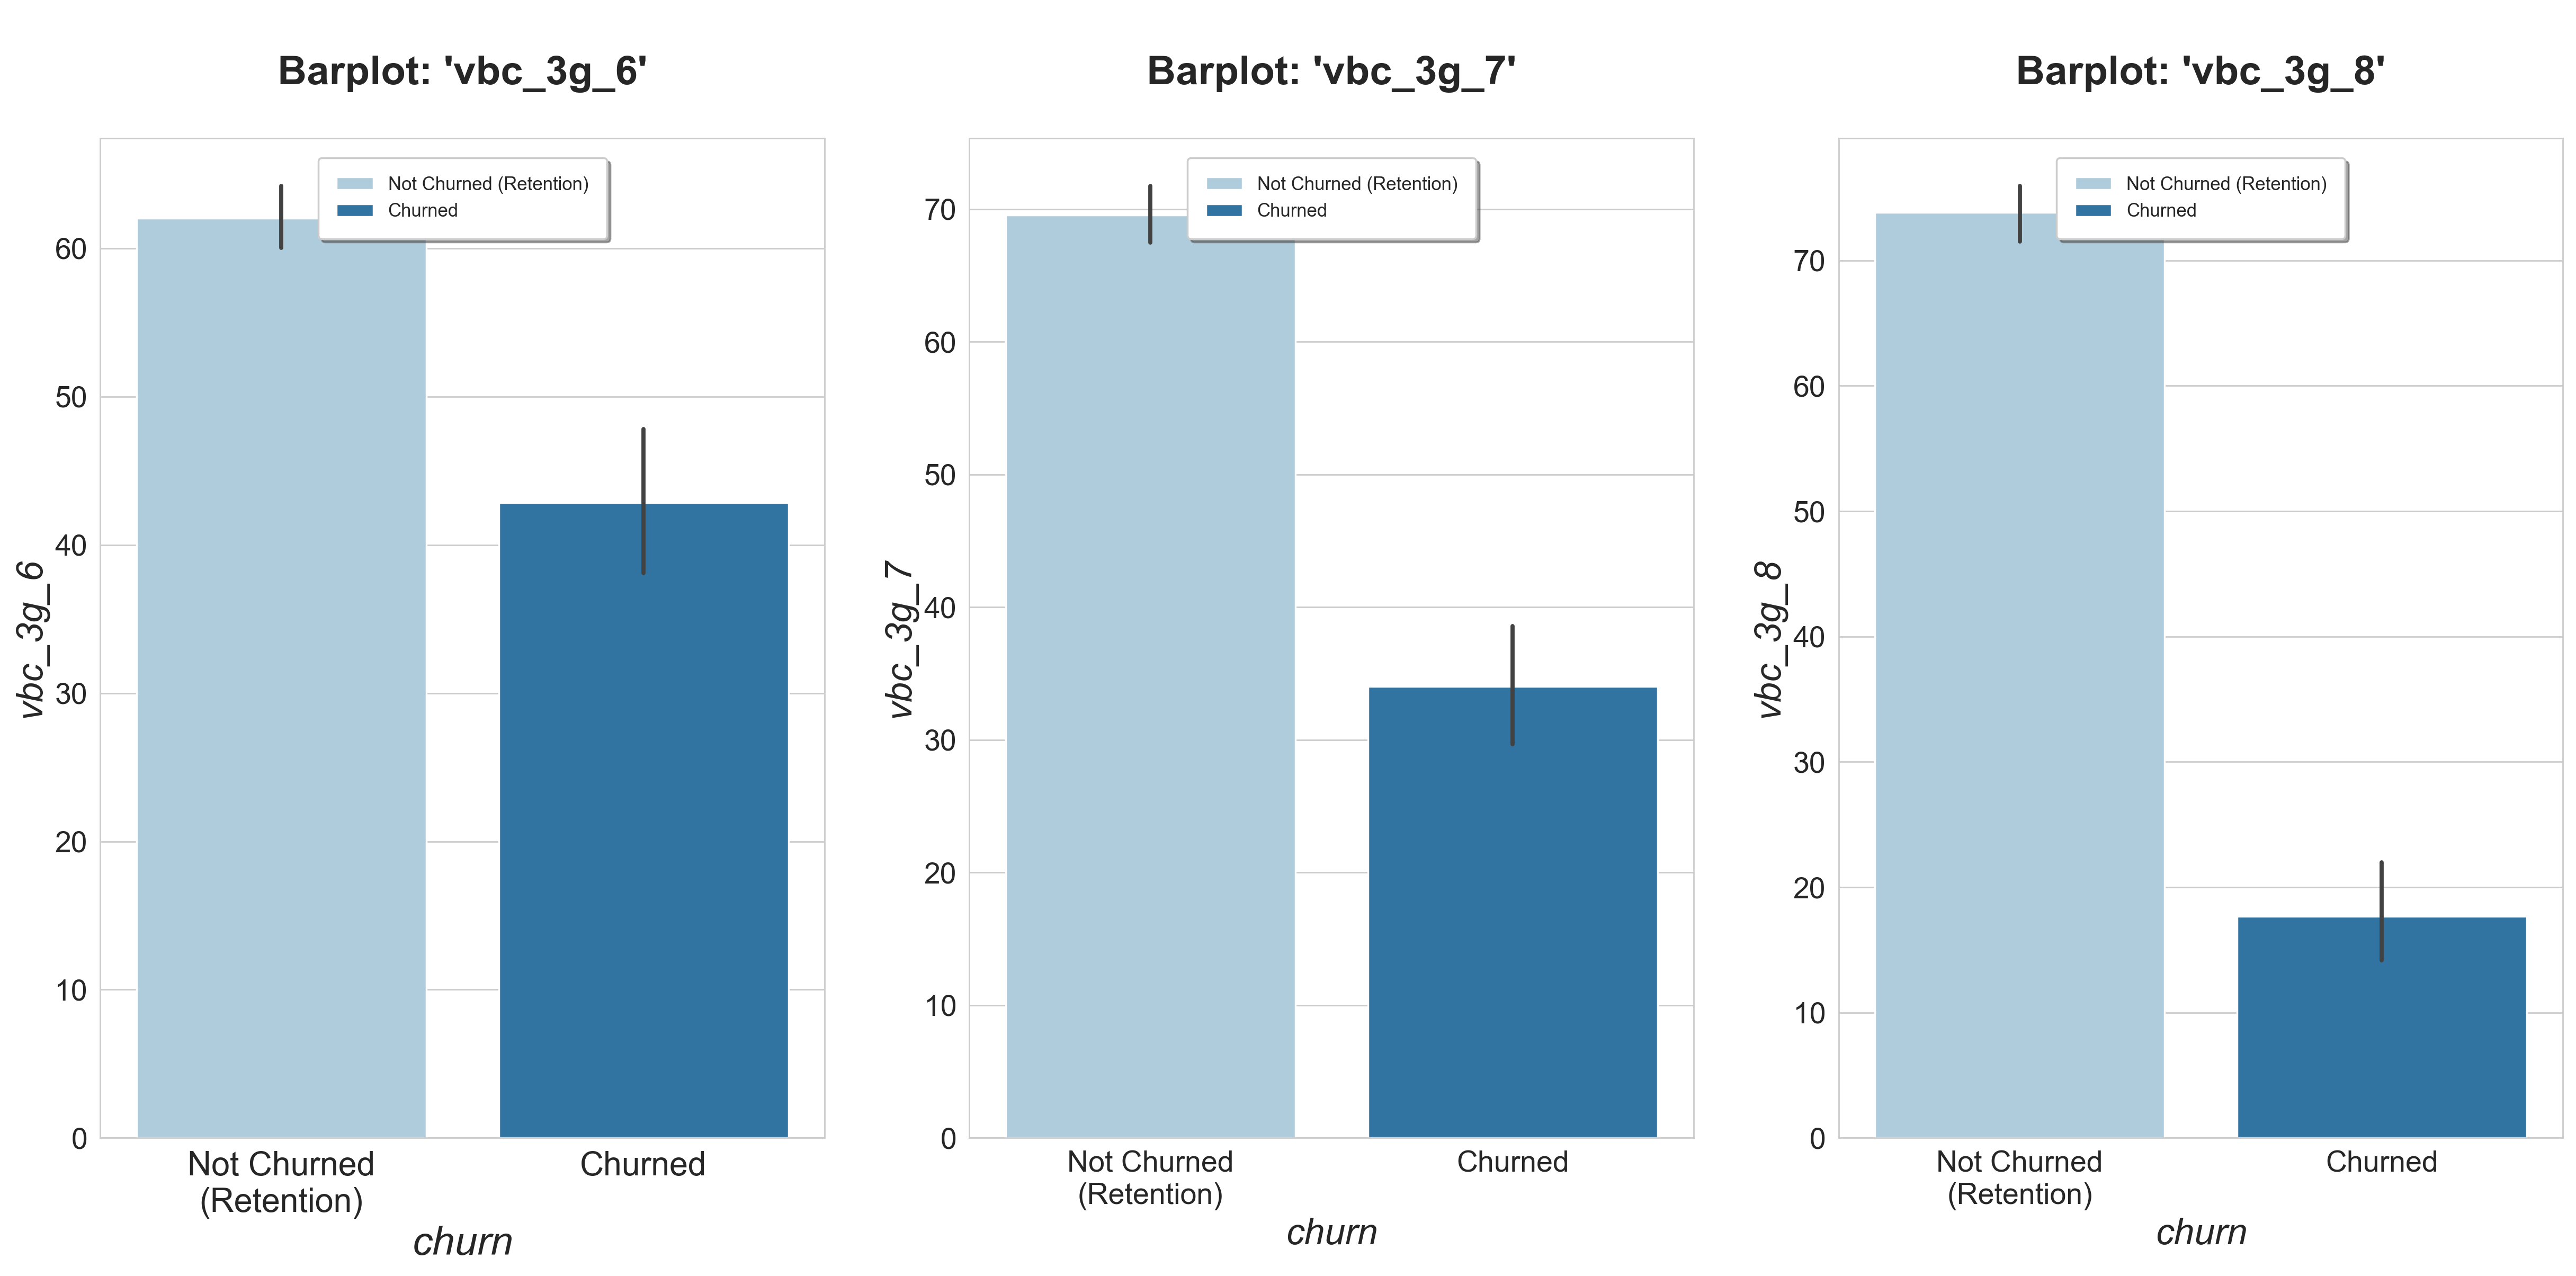

In [56]:
##Plotting boxplots and barplots for vbc based features
plot_boxplots_6_7_8('vbc_3g')
plot_barplots_6_7_8('vbc_3g')

**Observations:**
(i) The volume based cost, vbc for 3G is much lower for Churned customers than the non-churned customers.  
(ii) Also, we see a drop in the vbc as we approach the 8th month for churned customers.

(d) Average Revenue Per User

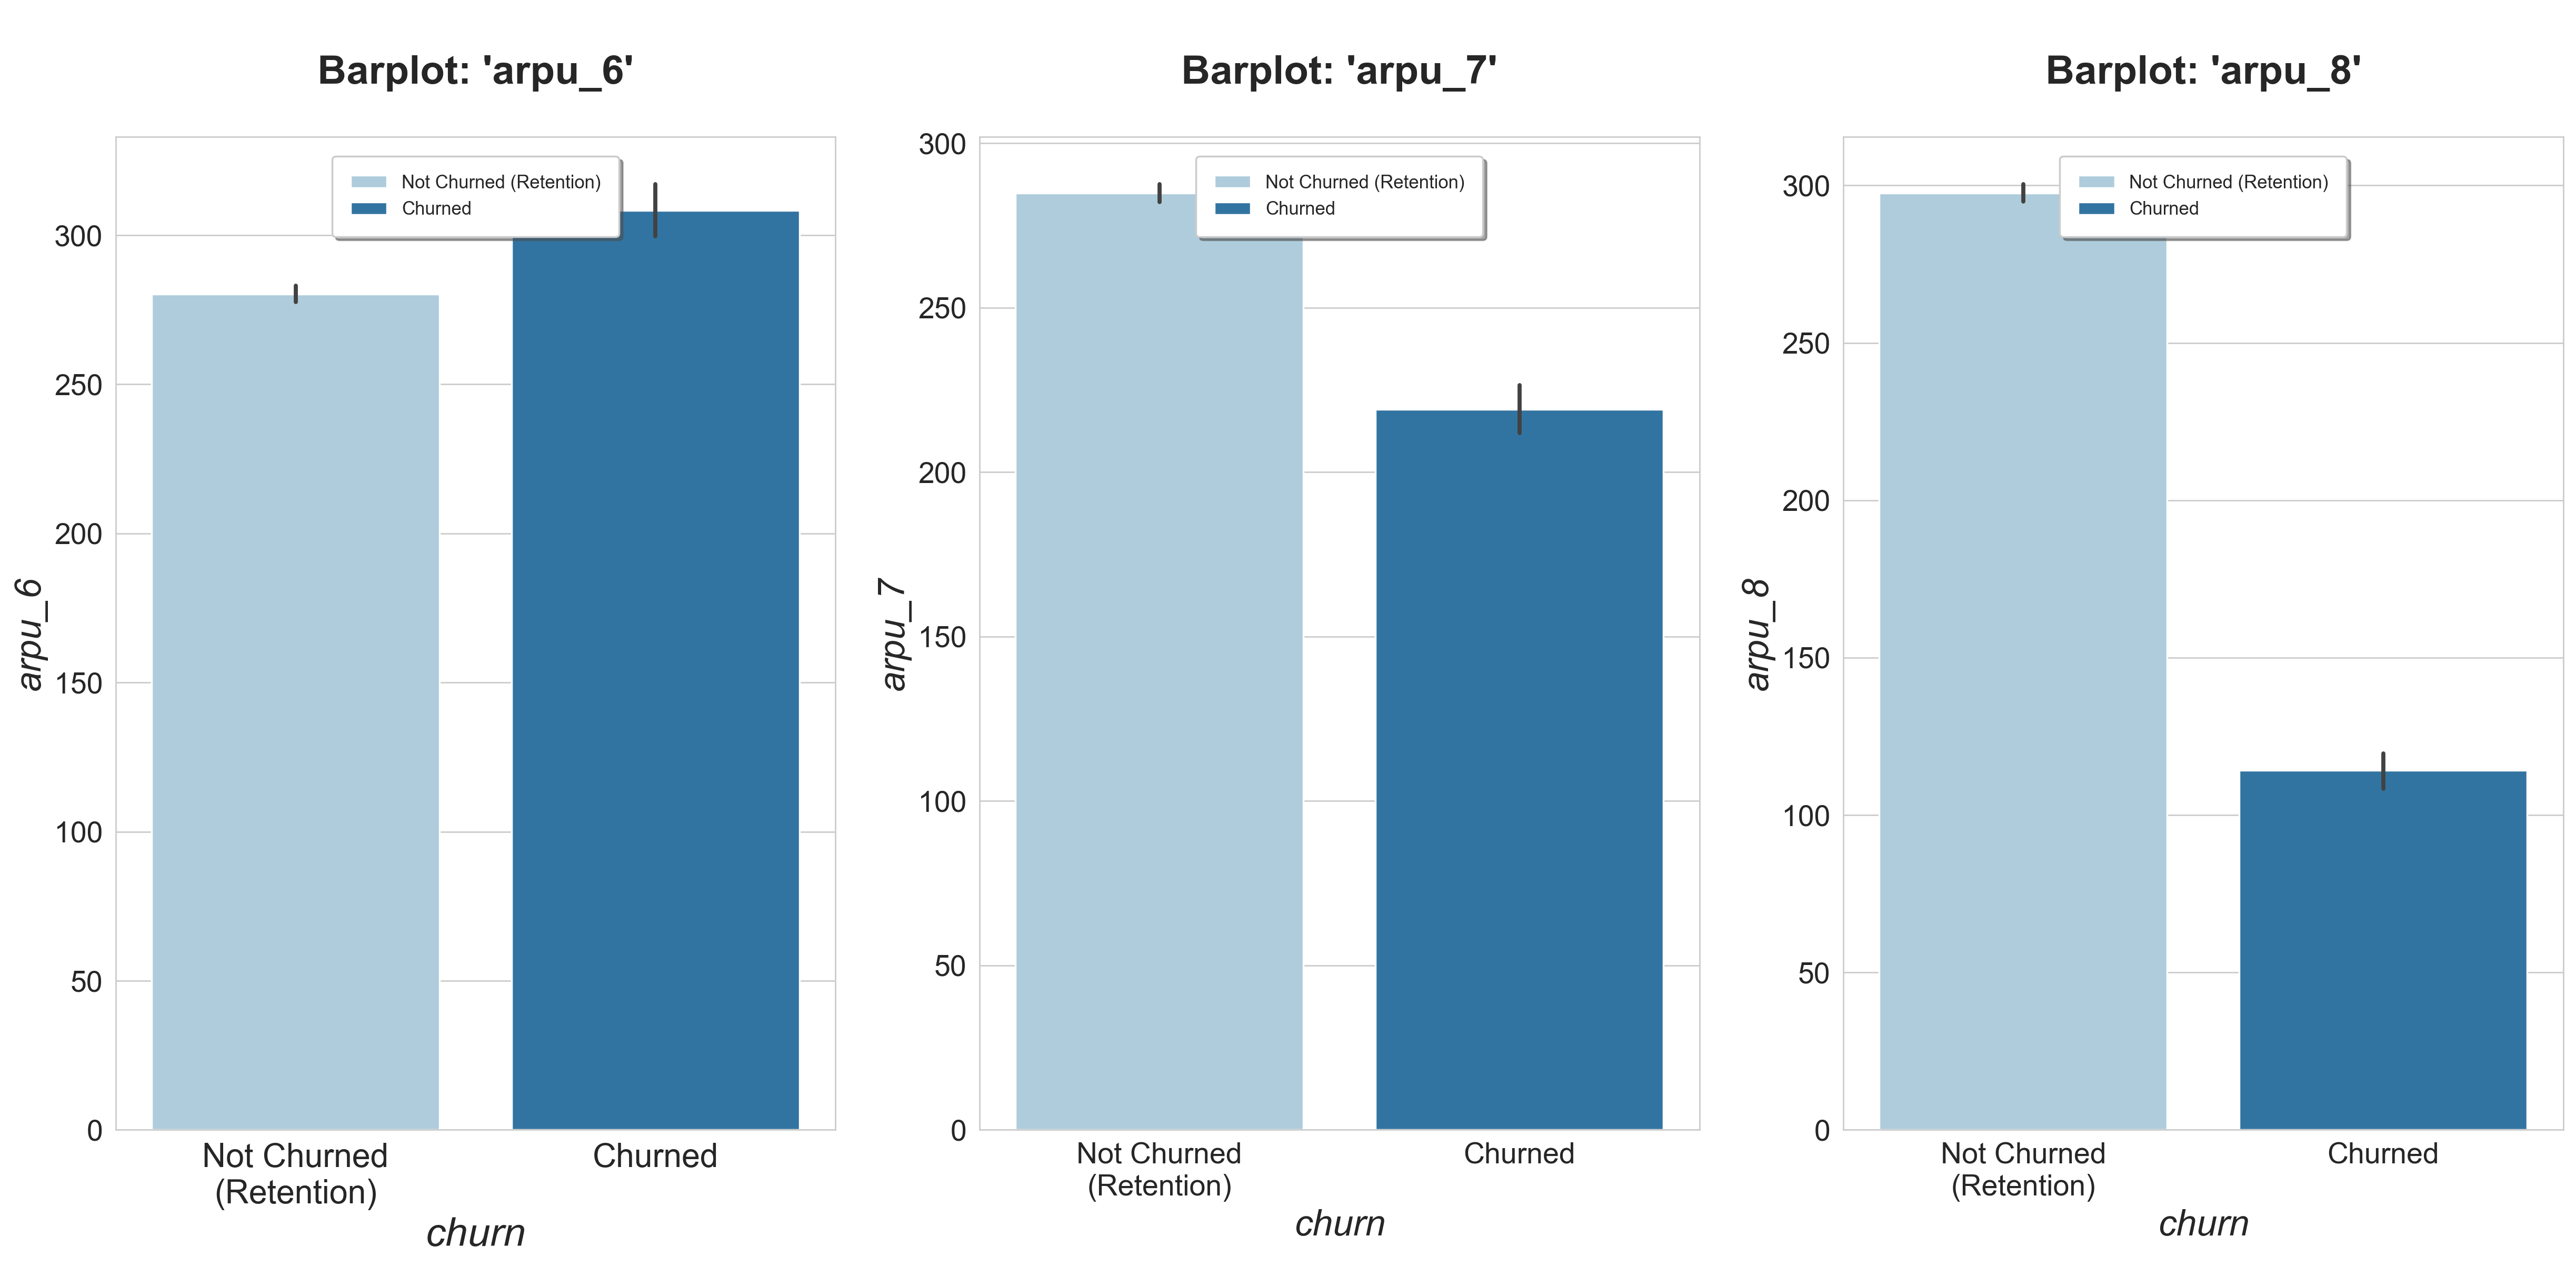

In [57]:
##Checking columns: average revenue per user
arpu_cols = telecom_df.columns[telecom_df.columns.str.contains('arpu_')]

##Plotting 'arpu_' barplots
plot_barplots_6_7_8('arpu')

**Observation**: We see a drop in the `average revenue per user` for churned customers as we approach month 8 from the month 6 and 7

(e) Minutes of usage (MOU): for voice calls

In [58]:
##Check minutes of usage 'mou' columns
mou_cols = telecom_df.columns[telecom_df.columns.str.contains('mou')]
mou_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mo

In [59]:
##Check for missing value percentages in 'mou_cols'

mou_cols_df = telecom_df[mou_cols]
null_prcnt_df(mou_cols_df)

**Observation:** So for all `minutes of usage (mou)` attributes, the maximum missing % is 5.290076 , means that the customer has not used the respective minutes at all for that particular call type. For example, for the month (8) we see all the records have same missing value(%). Thus we can impute these missing values with 0.

In [60]:
##Imputing minutes of usage (mou) attributes with 0
telecom_df[mou_cols] = telecom_df[mou_cols].replace(np.nan, 0)

In [61]:
##Reheck for missing value percentages in 'mou_cols'

mou_cols_df = telecom_df[mou_cols]
null_prcnt_df(mou_cols_df)

No missing values in mou features (including incoming, outgoing, offnet and onnet features)

(e.1) Incoming Calls

In [62]:
##Check for incoming(ic) mou features (just for 6th month)
ic_mou_features = list(telecom_df.columns[telecom_df.columns.str.contains('.*_ic_.*mou_6')])
ic_mou_features

['roam_ic_mou_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_mou_6',
 'total_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6']

In [63]:
telecom_df[ic_mou_features].describe()

roam_ic_mou_6  loc_ic_t2t_mou_6  loc_ic_t2m_mou_6  loc_ic_t2f_mou_6  \
count   69999.000000      69999.000000      69999.000000      69999.000000   
mean        9.379276         46.143461        102.915265         11.574147   
std        56.260778        138.011740        166.407161         38.700206   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          2.110000         13.860000          0.000000   
50%         0.000000         14.240000         52.290000          0.660000   
75%         0.000000         44.760000        127.280000          7.530000   
max      2850.980000       5315.590000       4450.740000       1872.340000   

       loc_ic_mou_6  std_ic_t2t_mou_6  std_ic_t2m_mou_6  std_ic_t2f_mou_6  \
count  69999.000000      69999.000000      69999.000000      69999.000000   
mean     160.641286          9.102206         19.914931          2.061402   
std      249.668829         50.666333         78.794332         16.197661   
min        0.000000          0.000000          0.000000          0.000000   
25%       24.860000          0.000000          0.000000          0.000000   
50%       86.310000          0.000000          1.590000          0.000000   
75%      200.690000          3.610000         13.940000          0.000000   
max     7454.630000       3336.380000       5647.160000       1351.110000   

       std_ic_mou_6  total_ic_mou_6  spl_ic_mou_6  isd_ic_mou_6  
count  69999.000000    69999.000000  69999.000000  69999.000000  
mean      31.080982      199.710640      0.059483      7.101776  
std      102.490662      290.114823      0.161981     59.751263  
min        0.000000        0.000000      0.000000      0.000000  
25%        0.000000       38.640000      0.000000      0.000000  
50%        5.030000      114.780000      0.000000      0.000000  
75%       25.240000      251.070000      0.000000      0.000000  
max     5712.110000     7716.140000     19.760000   6789.410000

<Figure size 1440x1200 with 0 Axes>

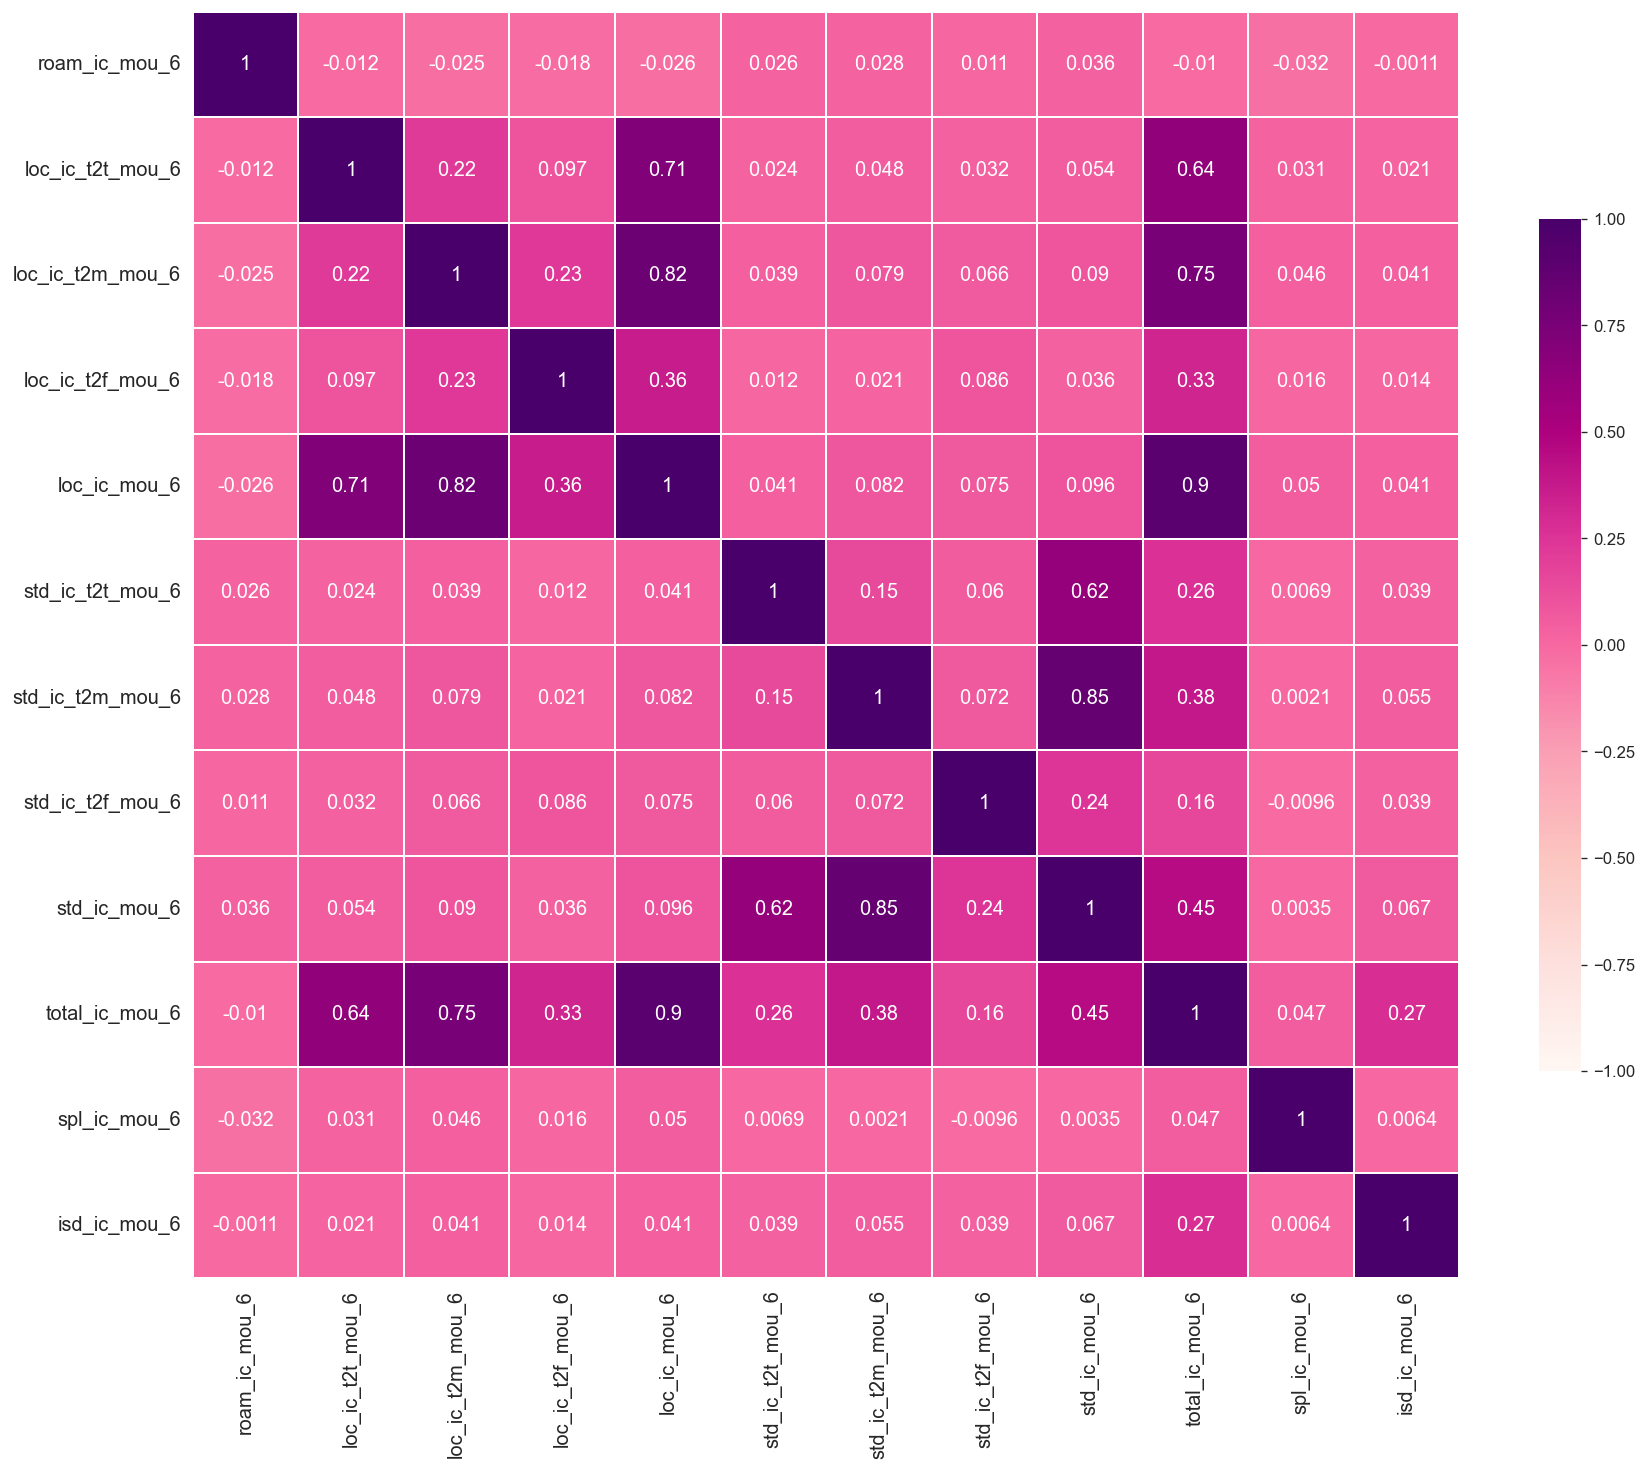

In [64]:
##Let's check the correlation between these variables to see if there is pattern between variables

#Plotting a heatmap to understand the correlation between the independent variables
plt.figure(figsize = (12,10), dpi=120)
corr_matrix_new = telecom_df[ic_mou_features].corr()
f, ax_corr1 = plt.subplots(figsize=(15, 15), dpi=120)
ax_corr1 = sns.heatmap(corr_matrix_new, cmap= 'RdPu', cbar_kws={"shrink": .5}, vmin= -1, vmax=1, center=0,
            square=True, annot=True, linewidths=0.01, annot_kws={"size":12})
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.autoscale()
plt.show()

From the above correlation matrix, We can see that `total_ic_mou_6`, `std_ic_mou_6` and `loc_ic_mou_6` seems to have strong correlation with other fileds and they needs to be inspected to avoid any multicolinearity issues. Let's cross check to eliminate **`multicollinearity`**.

In [65]:
##Let's check for a record (i.e. index 8: example)

print("'loc_ic_mou_6' = 'loc_ic_t2t_mou_6' + 'loc_ic_t2m_mou_6' + 'loc_ic_t2f_mou_6'")
print(telecom_df.loc[18,'loc_ic_mou_6'],"==",telecom_df.loc[18,['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6']].sum())

print("\n'std_ic_mou_6' = 'std_ic_t2t_mou_6' + 'std_ic_t2m_mou_6' + 'std_ic_t2f_mou_6'")
print(telecom_df.loc[18,'std_ic_mou_6'],"==",telecom_df.loc[18,['std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6']].sum())

print("\n'total_ic_mou_6' = 'loc_ic_mou_6' + 'std_ic_mou_6' + 'isd_ic_mou_6' + 'spl_ic_mou_6'")
print(telecom_df.loc[18,'total_ic_mou_6'],"==",telecom_df.loc[18,['loc_ic_mou_6','std_ic_mou_6','isd_ic_mou_6', 'spl_ic_mou_6']].sum())

'loc_ic_mou_6' = 'loc_ic_t2t_mou_6' + 'loc_ic_t2m_mou_6' + 'loc_ic_t2f_mou_6'
25.48 == 25.47

'std_ic_mou_6' = 'std_ic_t2t_mou_6' + 'std_ic_t2m_mou_6' + 'std_ic_t2f_mou_6'
0.86 == 0.86

'total_ic_mou_6' = 'loc_ic_mou_6' + 'std_ic_mou_6' + 'isd_ic_mou_6' + 'spl_ic_mou_6'
26.71 == 26.6


**Observation:** `'loc_ic_mou_*'`, `'std_ic_mou_*'` and `'total_ic_mou_*'` seems to be the aggregated features. Thus, retaining only the granular level variables and dropping these to reduce the **`multicollinearity`** in features.

In [66]:
##Dropping 'loc_ic_mou', 'std_ic_mou' and 'total_ic_mou' for all 3 months
drop_ic_mou_features = list(telecom_df.columns[telecom_df.columns.str.contains('loc_ic_mou_|std_ic_mou_|total_ic_mou_')])
print('List of features dropped:\n', drop_ic_mou_features)

telecom_df.drop(drop_ic_mou_features, axis=1, inplace= True)

List of features dropped:
 ['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']


(e.2) Outgoing Calls

In [67]:
##Check for outgoing(og) mou features (just for 6th month)
og_mou_features = list(telecom_df.columns[telecom_df.columns.str.contains('.*_og_.*mou_6')])
og_mou_features

['roam_og_mou_6',
 'loc_og_t2t_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'spl_og_mou_6',
 'total_og_mou_6']

<Figure size 1440x1200 with 0 Axes>

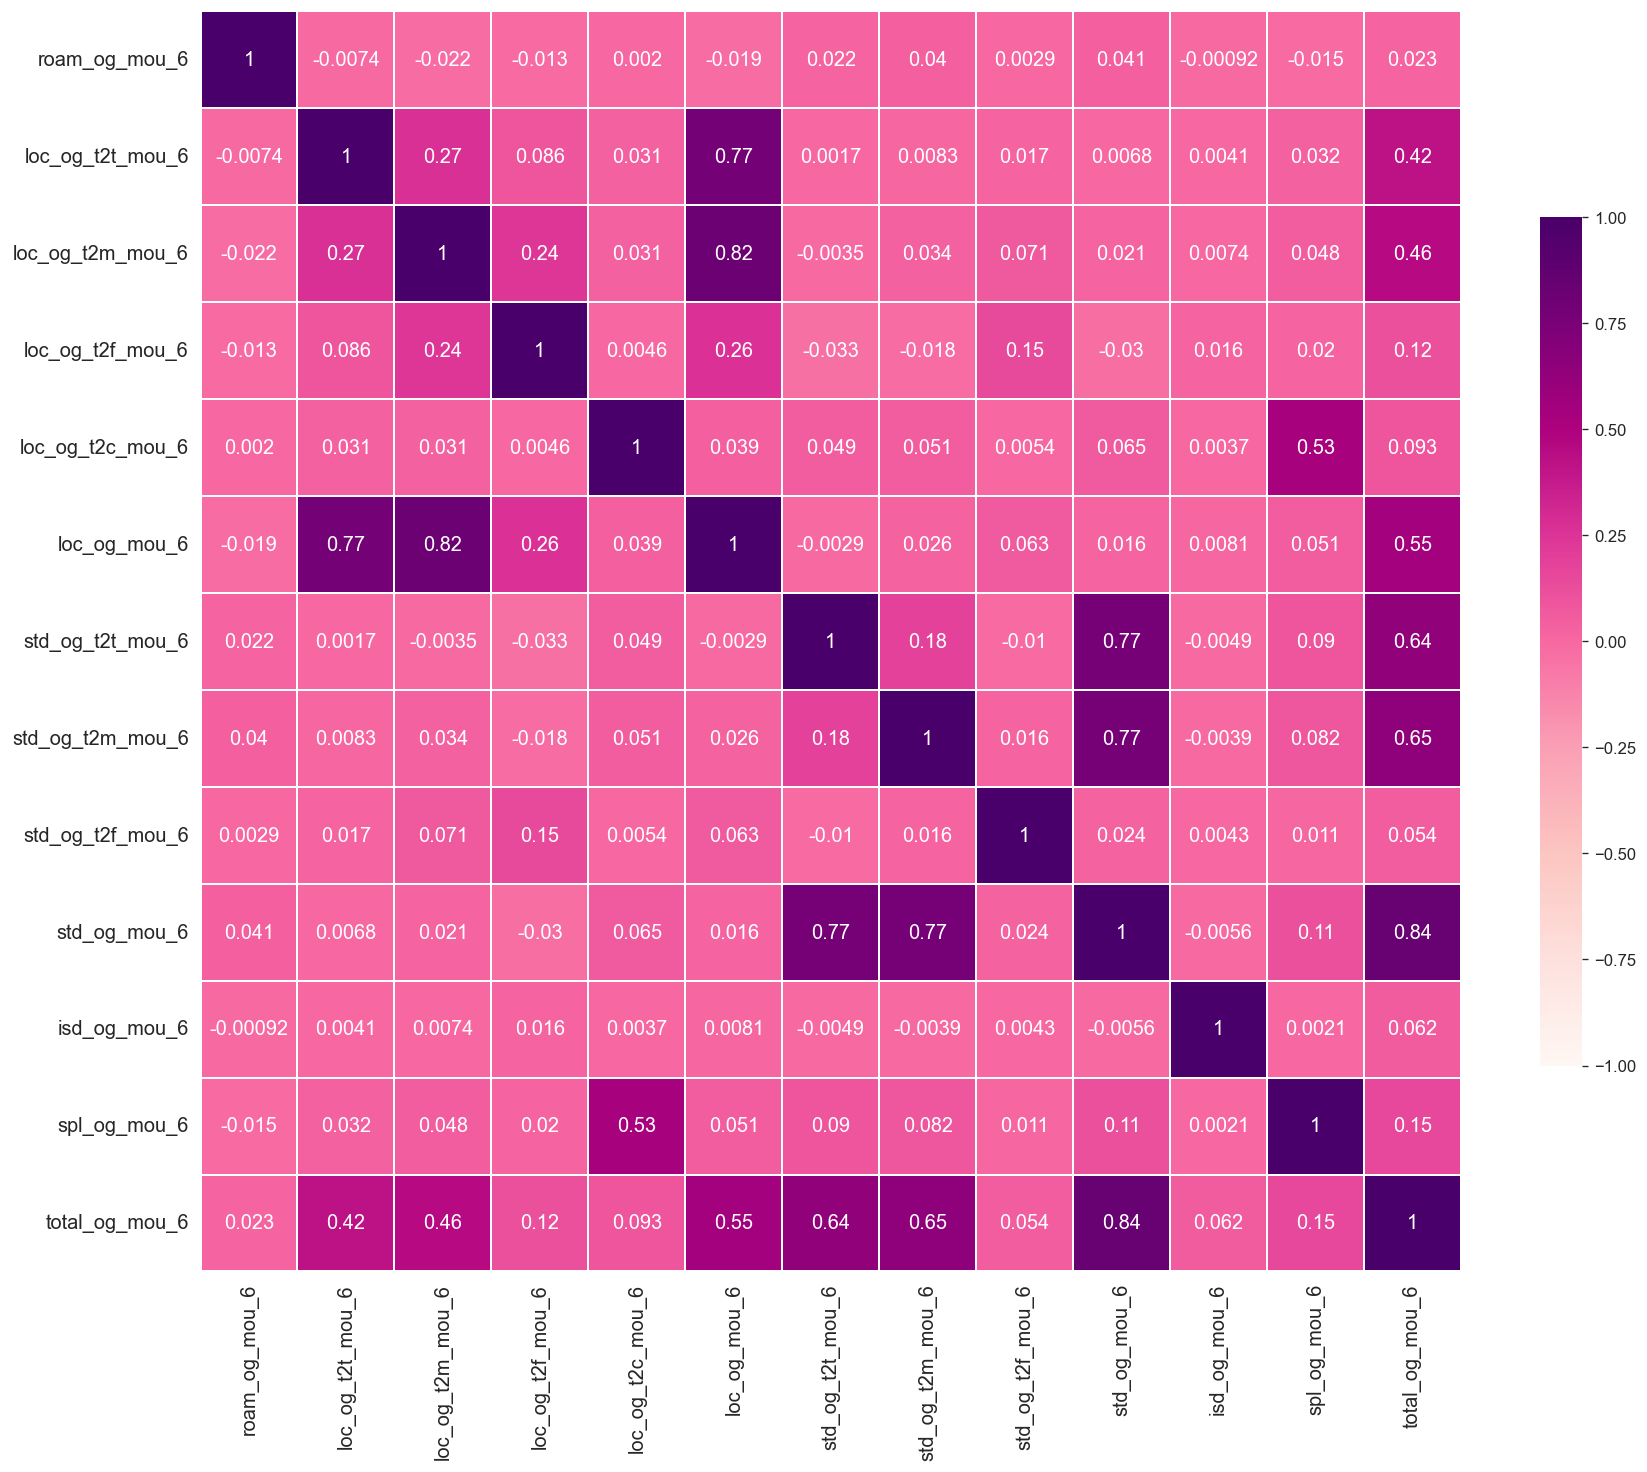

In [68]:
##Let's check the correlation between these variables to see if there is pattern between variables

#Plotting a heatmap to understand the correlation between the independent variables
plt.figure(figsize = (12,10), dpi=120)
corr_matrix_new = telecom_df[og_mou_features].corr()
f, ax_corr1 = plt.subplots(figsize=(15, 15), dpi=120)
ax_corr1 = sns.heatmap(corr_matrix_new, cmap= 'RdPu', cbar_kws={"shrink": .5}, vmin= -1, vmax=1, center=0,
            square=True, annot=True, linewidths=0.01, annot_kws={"size":12})
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.autoscale()
plt.show()

From the above correlation matrix, We can see that `total_og_mou_6`, `std_og_mou_6` and `loc_og_mou_6` seems to have strong correlation with other fileds and they needs to be inspected to avoid any multicolinearity issues. Let's cross check to eliminate **`multicollinearity`**.

In [69]:
##Let's check for a record (i.e. index 21: example)

print("'loc_og_mou_6' = 'loc_og_t2t_mou_6' + 'loc_og_t2m_mou_6' + 'loc_og_t2f_mou_6'")
print(telecom_df.loc[21,'loc_og_mou_6'],"==",telecom_df.loc[21,['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6']].sum())

print("\n'std_og_mou_6' = 'std_og_t2t_mou_6' + 'std_og_t2m_mou_6' + 'std_og_t2f_mou_6'")
print(telecom_df.loc[21,'std_og_mou_6'],"==",telecom_df.loc[21,['std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6']].sum())

print("\n'total_og_mou_6' = 'loc_og_mou_6' + 'std_og_mou_6' +  'spl_og_mou_6' + 'isd_og_mou_6'")
print(telecom_df.loc[21,'total_og_mou_6'],"==",telecom_df.loc[21,['loc_og_mou_6','std_og_mou_6','spl_og_mou_6','isd_og_mou_6']].sum())

'loc_og_mou_6' = 'loc_og_t2t_mou_6' + 'loc_og_t2m_mou_6' + 'loc_og_t2f_mou_6'
191.74 == 191.74

'std_og_mou_6' = 'std_og_t2t_mou_6' + 'std_og_t2m_mou_6' + 'std_og_t2f_mou_6'
21.78 == 21.77

'total_og_mou_6' = 'loc_og_mou_6' + 'std_og_mou_6' +  'spl_og_mou_6' + 'isd_og_mou_6'
213.53 == 213.52


**Observation:** `'loc_og_mou_*'`, `'std_og_mou_*'` and `'total_og_mou_*'` seems to be the aggregated features. Thus, retaining only the granular level variables and dropping these to reduce the **multogollinearity** in features.

In [70]:
##Dropping 'loc_og_mou', 'std_og_mou' and 'total_og_mou' for all 3 months
drop_og_mou_features = list(telecom_df.columns[telecom_df.columns.str.contains('loc_og_mou_|std_og_mou_|total_og_mou_')])
print('List of features dropped:\n', drop_og_mou_features)

telecom_df.drop(drop_og_mou_features, axis=1, inplace= True)

List of features dropped:
 ['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']


(f) Offnet MOU Usage: All kind of calls outside the operator T network

In [71]:
offnet_usage_cols = list(telecom_df.columns[telecom_df.columns.str.contains('offnet.*mou')])
offnet_usage_cols

['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']

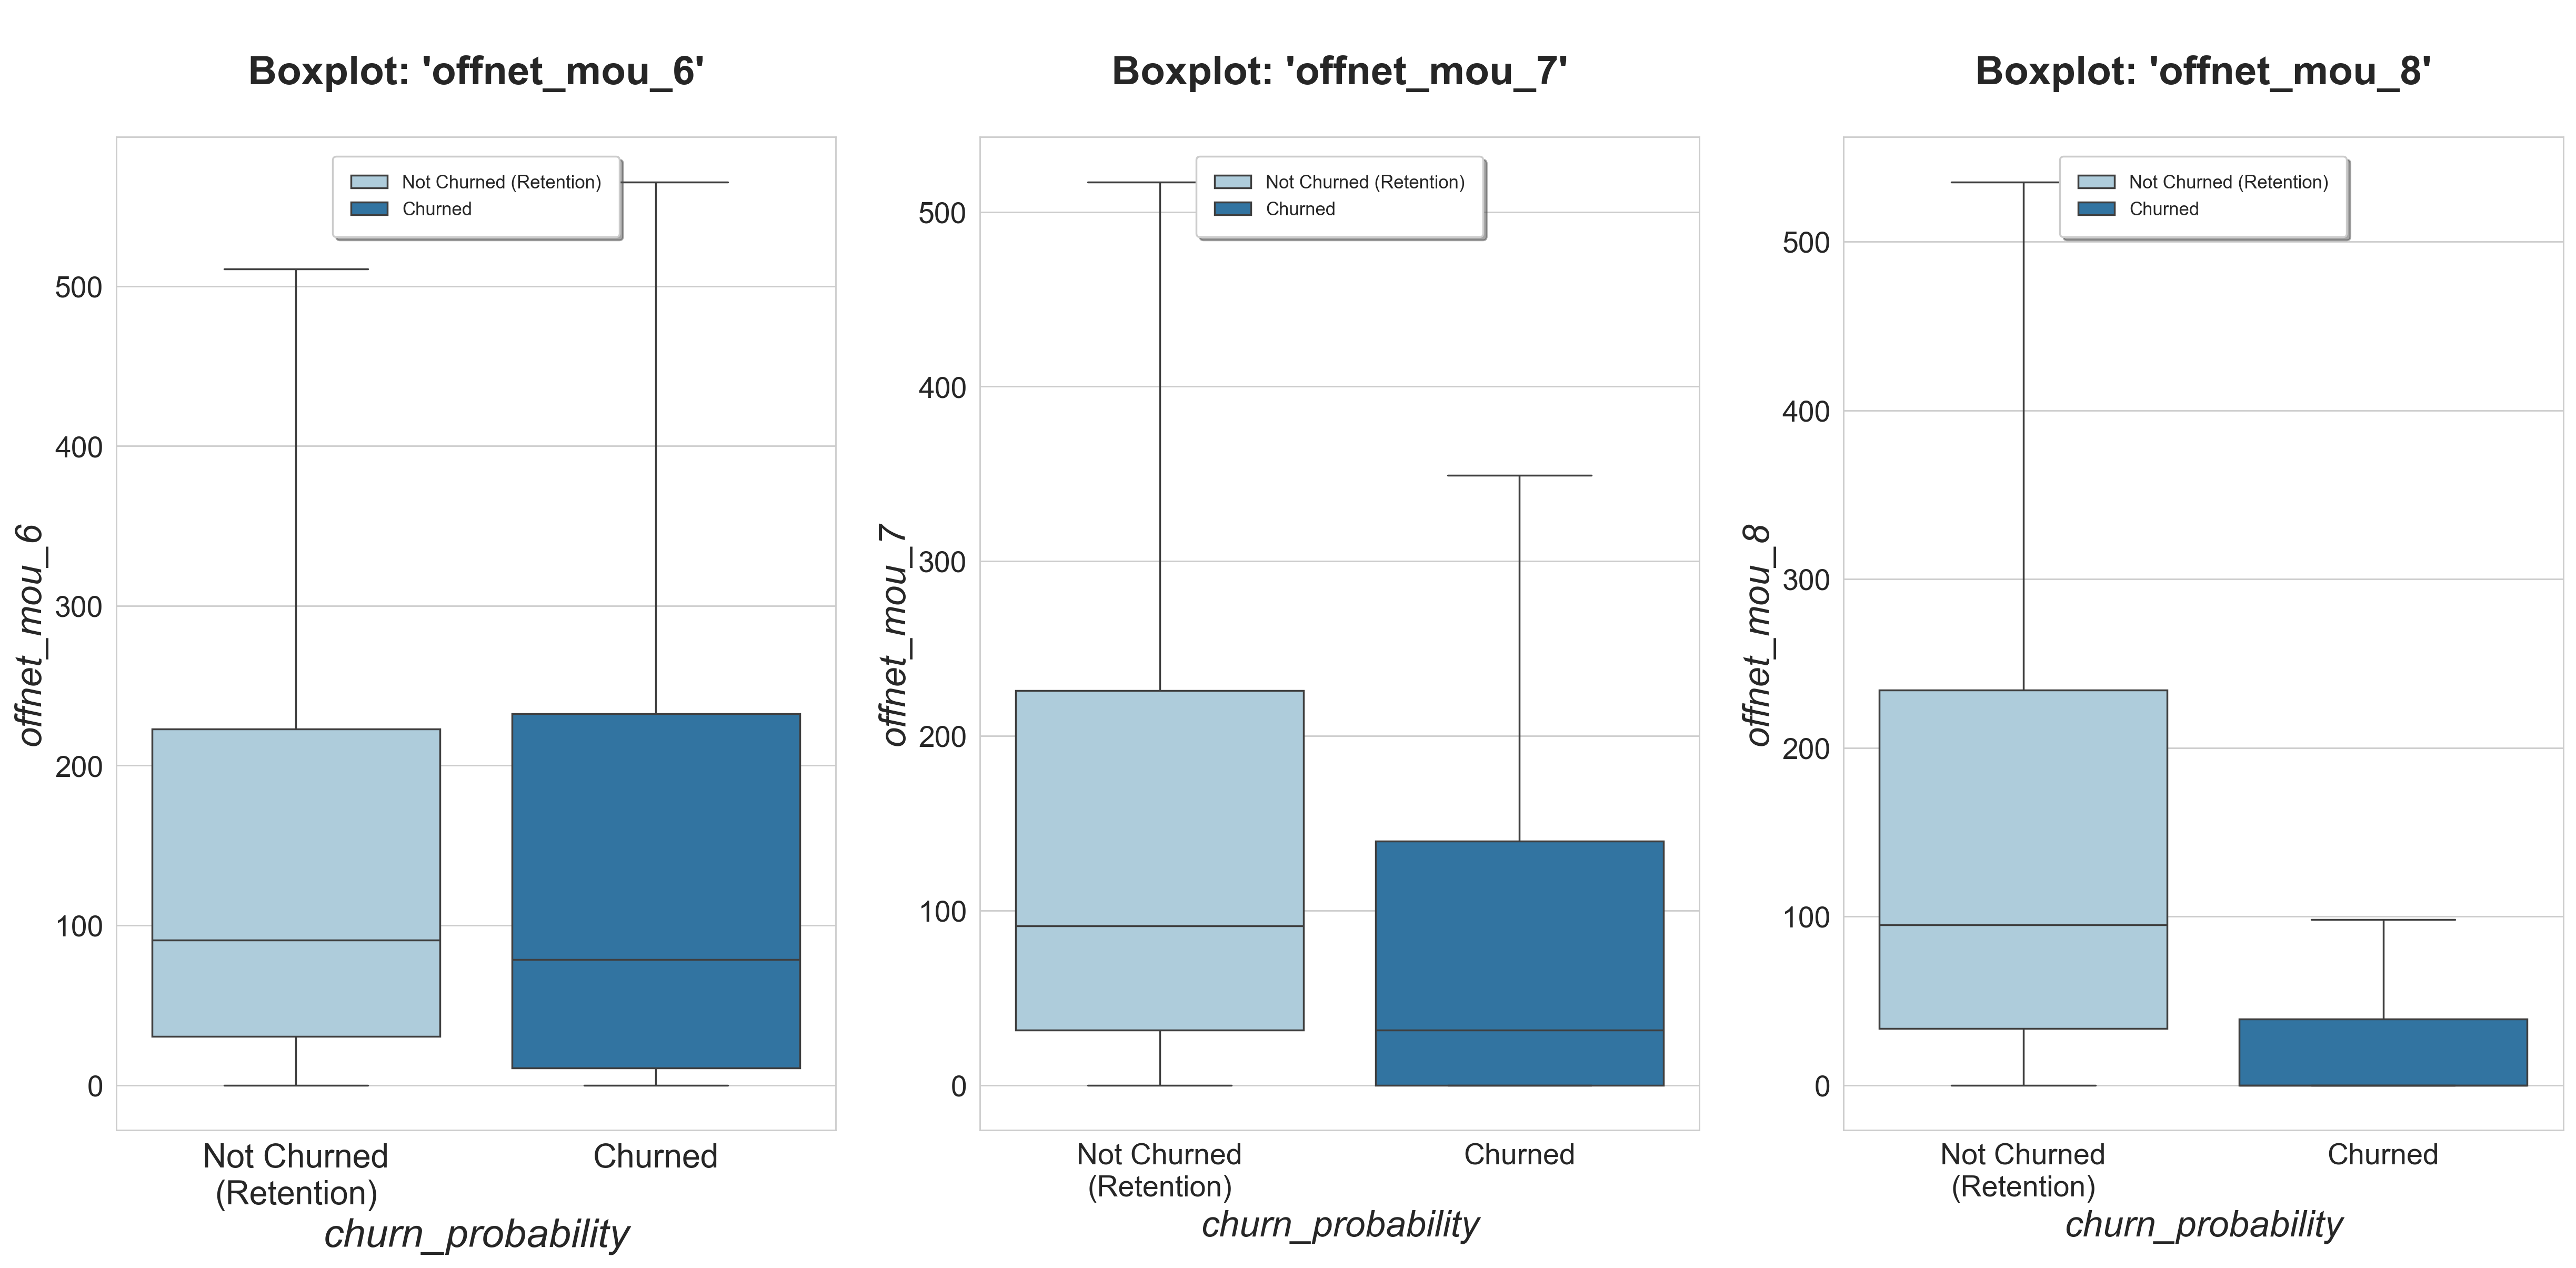

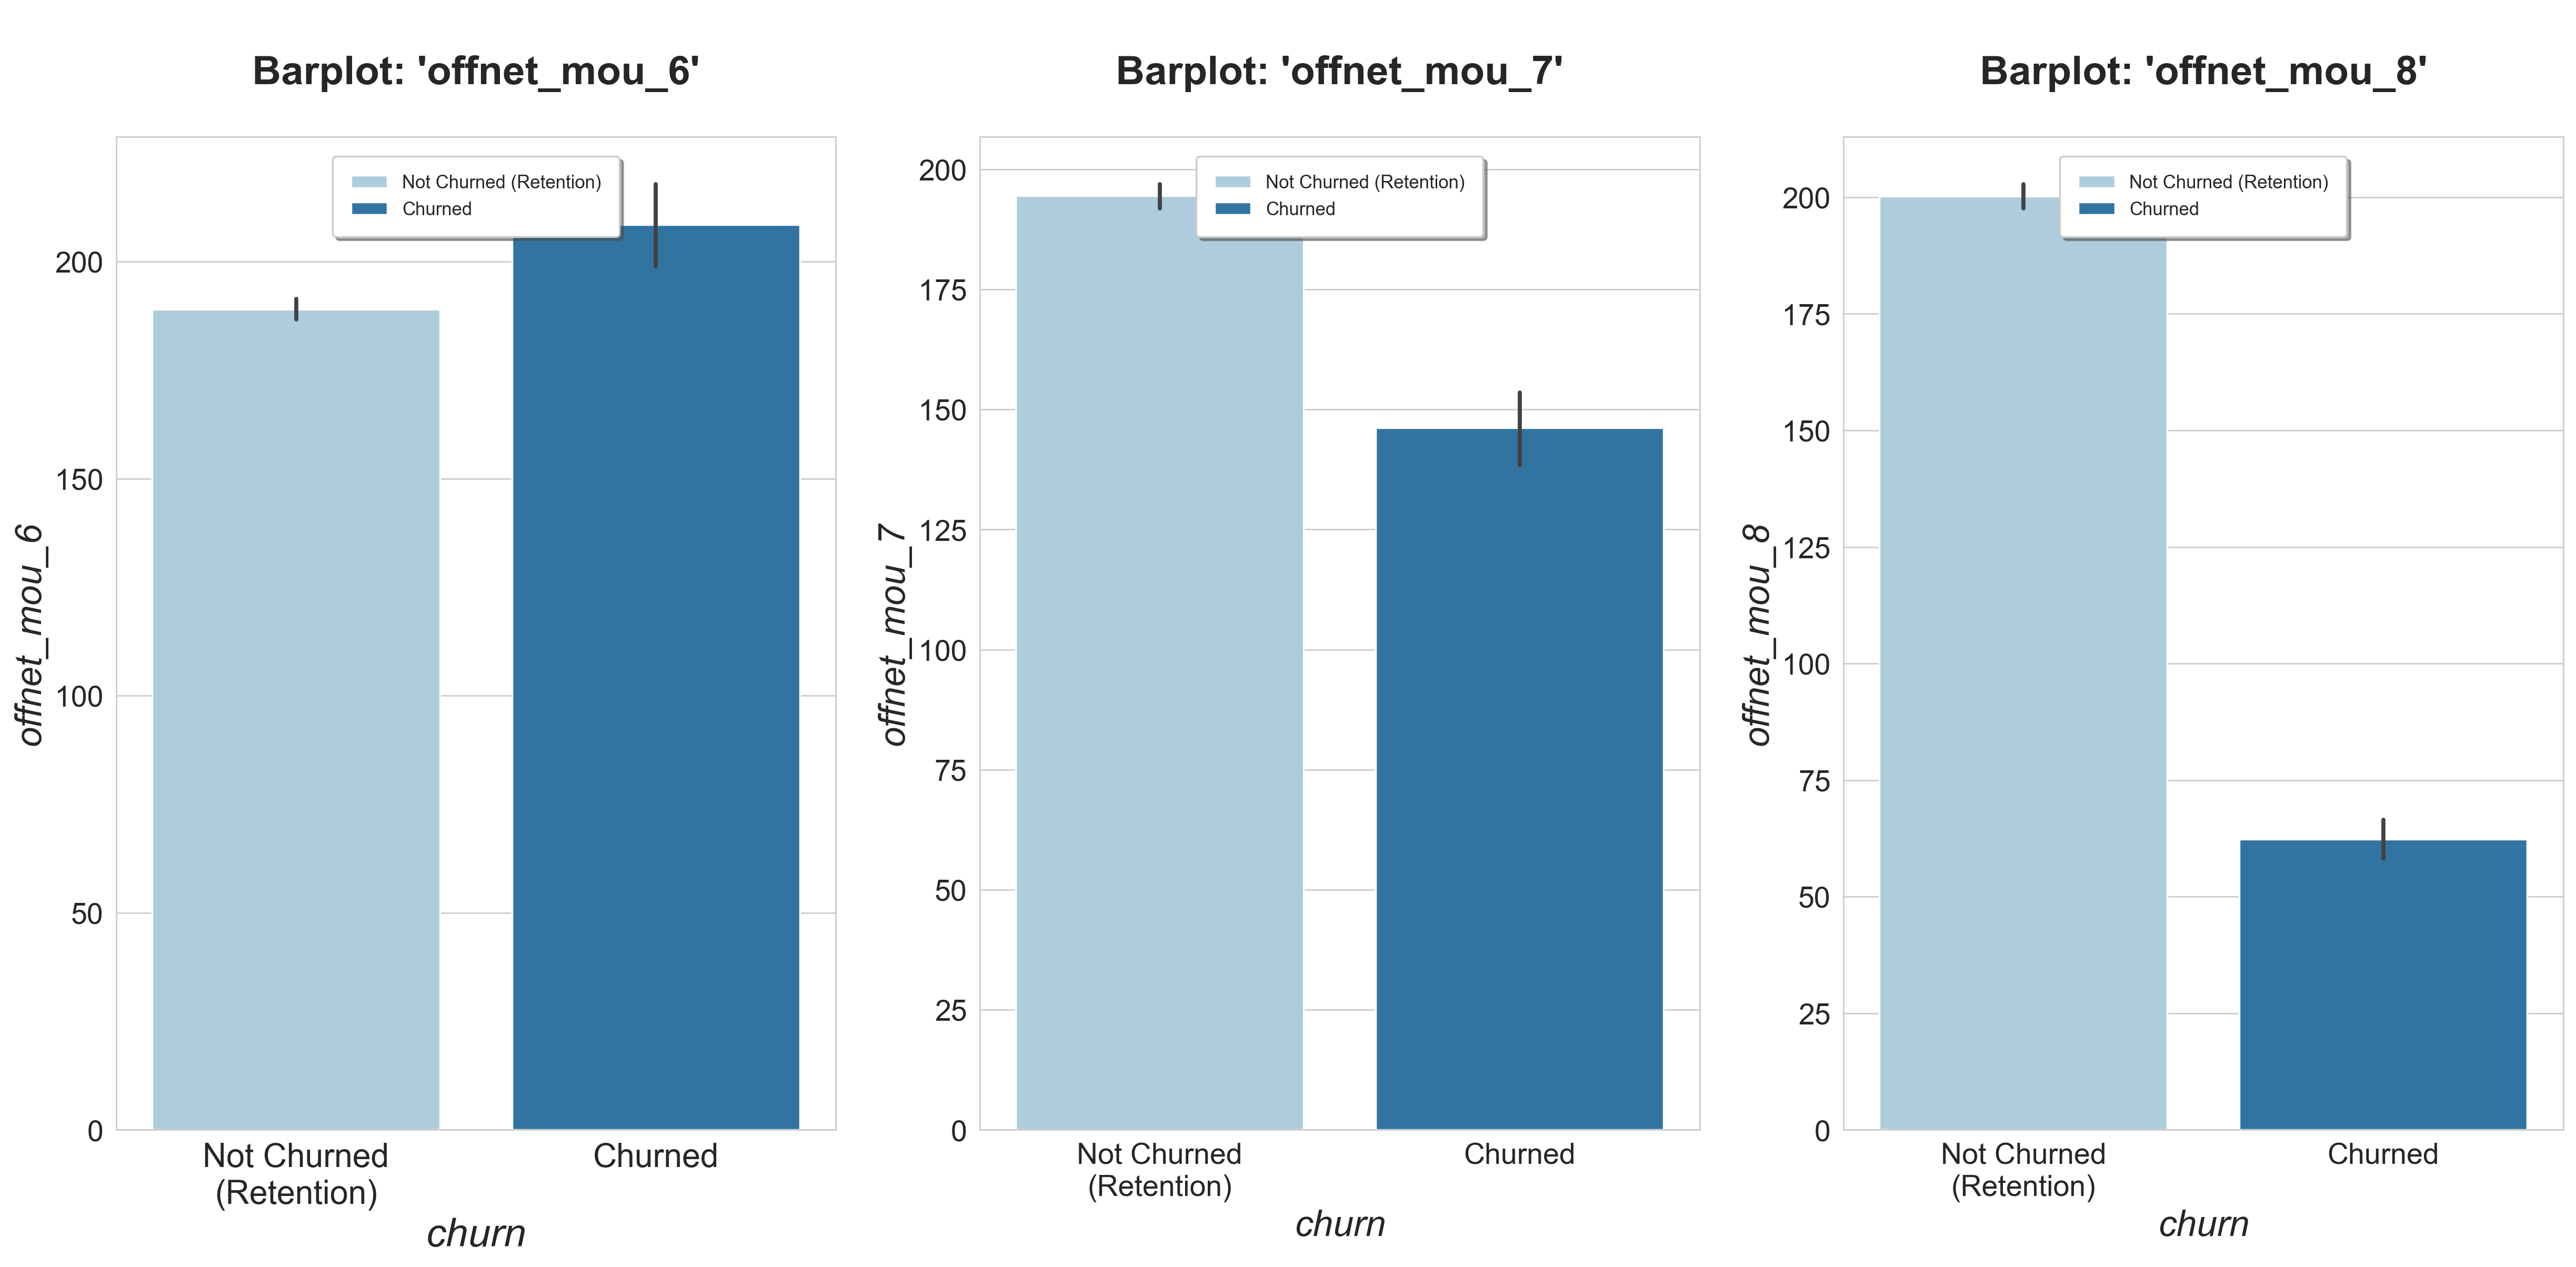

In [72]:
# Plotting 'offnet_mou' boxplots and barplots
plot_boxplots_6_7_8('offnet_mou')  #Suppresses outliers
plot_barplots_6_7_8('offnet_mou')

**Observation**: The `offnet_mou (minutes of usage)` decline as we move from month 6 and 7 to the month 8 for churned customers.

(g) Onnet MOU Usage: All kind of calls within the same operator network

In [73]:
onnet_usage_cols = list(telecom_df.columns[telecom_df.columns.str.contains('onnet.*mou')])
onnet_usage_cols

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']

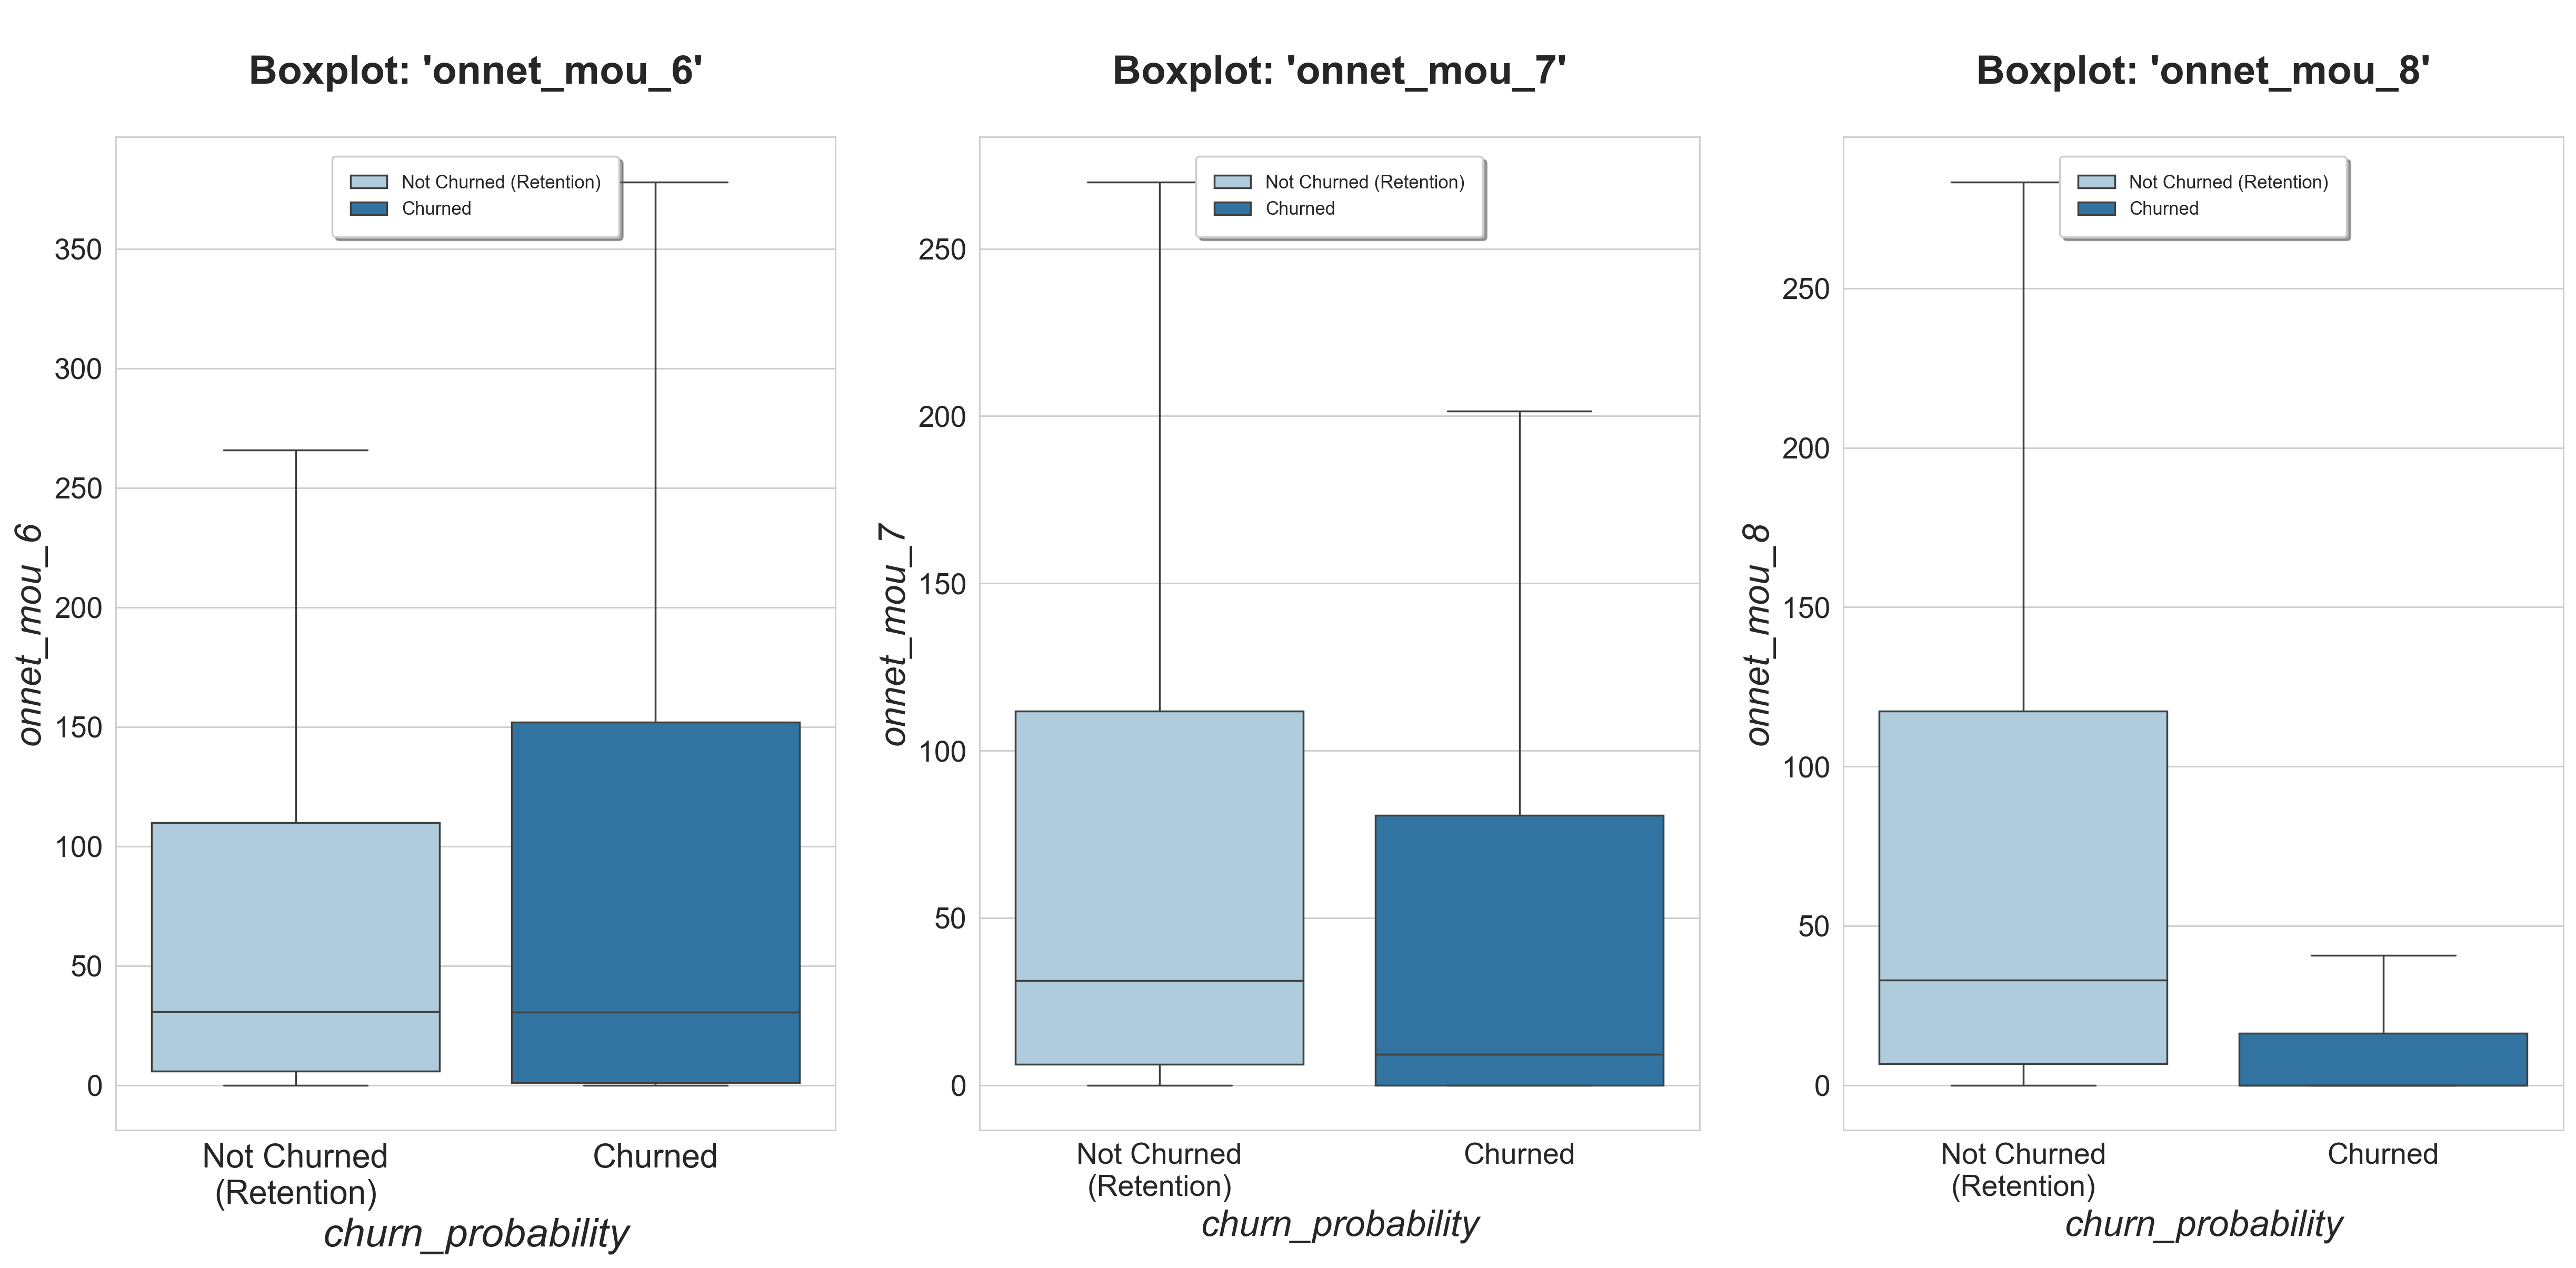

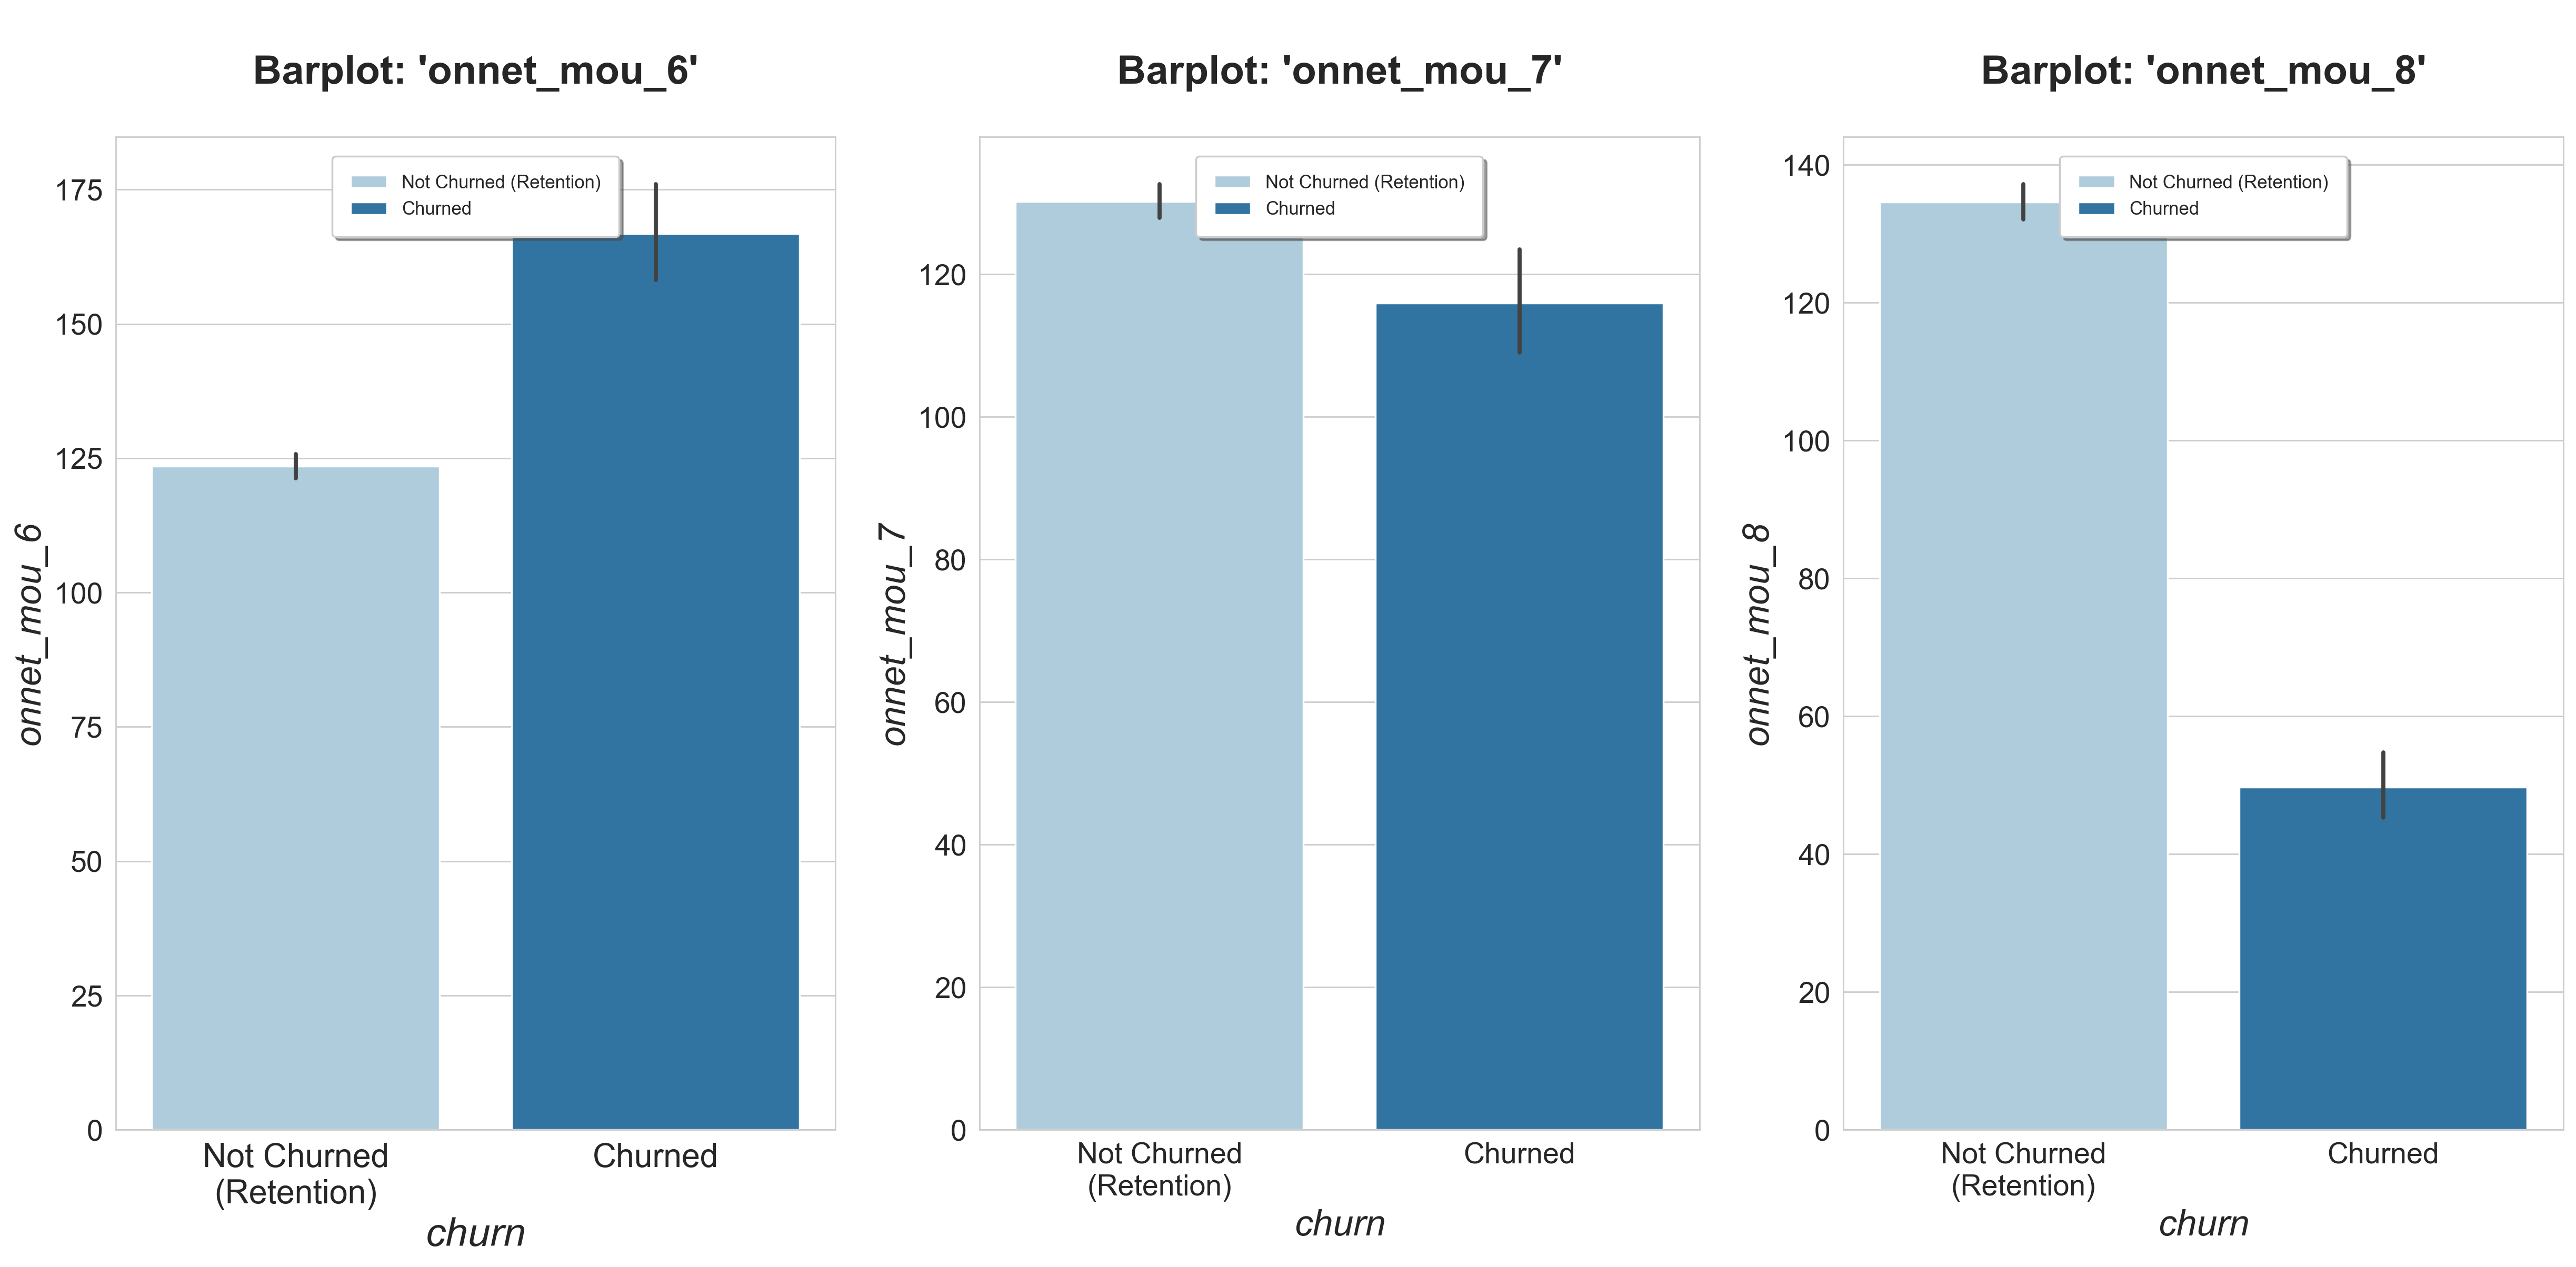

In [74]:
# Plotting 'onnet_mou' boxplots and barplots
plot_boxplots_6_7_8('onnet_mou')  #Suppresses outliers
plot_barplots_6_7_8('onnet_mou')

**Observation**: The `onnet_mou (minutes of usage)` decline as we move from good phase month 6 and 7 to the month 8 for churned customers.

(h) Tenure (Age on network) Analysis

The `AON variable` was used to create tenure buckets. `[AON: Age on network (in number of days)]`
It is observerd that larger the tenure, lesser was the churn - as customers who are newly acquired by the network churned more often in comparison to the old customers.

In [75]:
##Creating  a new column tenure_year to store the number of years the customer has been on network T
telecom_df['tenure_year'] = round(telecom_df['aon']/365, 1)

print(telecom_df.tenure_year.value_counts())
print("Min:",telecom_df.tenure_year.min())
print("Max:",telecom_df.tenure_year.max())

tenure_year
1.3     3334
0.6     2531
0.8     2366
1.0     2316
0.9     2293
        ... 
11.7       2
11.9       1
11.6       1
10.7       1
11.0       1
Name: count, Length: 107, dtype: int64
Min: 0.5
Max: 11.9


In [76]:
##Creating bins
my_bins = [0,1,2,3,5,12]
my_labels_aon= ['0_1_year','1_2_year','2_3_year','3_5_year','5_12_year']
telecom_df['tenure'] = pd.cut(telecom_df['tenure_year'], bins= my_bins, labels= my_labels_aon)

##Dropping 'tenure_year' and 'aon' column as we have already created bins in 'tenure' column
telecom_df.drop(['tenure_year','aon'] , axis=1, inplace= True)

telecom_df.tenure.value_counts()

tenure
1_2_year     18059
5_12_year    17218
0_1_year     13103
3_5_year     11043
2_3_year     10576
Name: count, dtype: int64

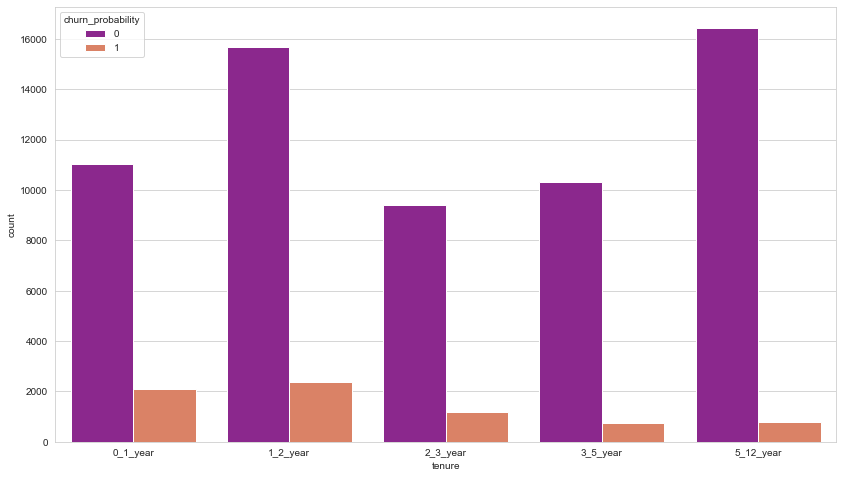

In [77]:
##Visualizing 'age of network' and 'churn'
plt.figure(figsize=(14,8))
tenure_df= telecom_df[['tenure','churn_probability']]
sns.countplot(x = 'tenure', hue = 'churn_probability',data = tenure_df,palette=("plasma"))
plt.show()

**Observation**: We see that as the `age on network (AON)` increases, the number of people churned out (i.e. churned class label: 1) are reduced.

In [78]:
##Check for missing values in dataframe (show only missing value columns)
missing_val_cols_prcnt = round(100*telecom_df.isnull().sum()/len(telecom_df.index),2)
missing = pd.DataFrame(missing_val_cols_prcnt[missing_val_cols_prcnt!=0].sort_values(ascending=False))  #Descending order(% NaN)
missing.reset_index(inplace=True)
missing= missing.rename(columns={'index':'features',0:'Null_Percentage'})
missing

features  Null_Percentage
0   night_pck_user_6            74.90
1          fb_user_6            74.90
2   night_pck_user_7            74.48
3          fb_user_7            74.48
4   night_pck_user_8            73.69
5          fb_user_8            73.69
6        og_others_8             5.29
7        ic_others_8             5.29
8        og_others_6             3.95
9        ic_others_6             3.95
10       og_others_7             3.84
11       ic_others_7             3.84

**Observation**:
(i) Since we checked at the very beginning that `'fb_user_*'` and `'night_pck_user_*'` attributes had same number of missing values as the dates of recharging data plan. Thus, the number of missing values, imply no recharge done. However, 0 has a meaning here, we just can't impute with 0. Also, a lot of values are missing (74%) and these features don't seem to be significant. Hence, dropping the `'fb_user_*'` and `'night_pck_user_*'` attributes.  
(ii) Also, imputing `ig_others` and `og_others` with 0, since they had similar missing values as that of incoming mou features and outgoing mou features, thus indicating absence of mou.

In [79]:
##Dropping 'fb_user_*' and 'night_pck_user_*' features
cols_to_drop = ['fb_user_6', 'fb_user_7', 'fb_user_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']
telecom_df.drop(cols_to_drop, axis=1, inplace= True)

##Imputing 'ic_others' and 'og_others' with 0 (<=3.91% missing values)
cols_to_impute = telecom_df.columns[telecom_df.columns.str.contains('ic_others|og_others')]
telecom_df[cols_to_impute] = telecom_df[cols_to_impute].replace(np.nan, 0)

In [80]:
##Checking the entire high-value customer dataframe for null (missing) values
null_prcnt_df(telecom_df)

In [81]:
telecom_df.shape

(69999, 120)

**`Outlier Treatment`**:

**Summary**:
This code segment first defines cont_cols_df, a list of continuous features in the telecom_df DataFrame, excluding the churn_probability and tenure columns. It then iterates over these continuous features, using NumPy's clip() function to limit the values within the 1st and 99.9th percentiles. This outlier capping helps in mitigating the impact of extreme values, leading to more robust model performance.

In [82]:
##Continuous features
cont_cols_df= [i for i in telecom_df.columns if i not in ['churn_probability', 'tenure']]
cont_cols_df

##Using numpy clip() to cap the values of outliers in between 1 and 99.9 percentiles
import numpy as np
for col in cont_cols_df:
    percentiles = telecom_df[col].quantile([0.01,0.999]).values
    telecom_df[col] = np.clip(telecom_df[col], percentiles[0], percentiles[1])

**Get dummies for categorical variables**:

In [83]:
##Checking categorical column 'tenure'
telecom_df.tenure.head()

0    5_12_year
1     1_2_year
2     2_3_year
3     2_3_year
4     1_2_year
Name: tenure, dtype: category
Categories (5, object): ['0_1_year' < '1_2_year' < '2_3_year' < '3_5_year' < '5_12_year']

In [84]:
#'tenure' is a categorical variable. Converting it into numeric using get_dummies
###Creating dummies for categorical variable 'tenure'
cat_cols= ['tenure']
d_tenure = pd.get_dummies(telecom_df['tenure'], prefix='tenure', drop_first = True)
d_tenure = d_tenure.astype(int)
telecom_df = pd.concat([telecom_df, d_tenure], axis = 1)

##Dropping the 'tenure' column
telecom_df.drop(cat_cols, axis=1, inplace=True)

In [85]:
telecom_df.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0  699.98   31.277   87.009    7.527        48.58       124.38         1.29   
1  699.98    0.000  122.787   42.953         0.00         0.00         0.00   
2  699.98   60.806  103.176    0.000         0.53        15.93         0.00   
3  699.98  156.362  205.260  111.095         7.26        16.01         0.00   
4  699.98  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  vbc_3g_7  vbc_3g_6  \
0         32.24         96.68          2.33  ...       0.0       0.0   
1          0.00         25.99         30.89  ...       0.0       0.0   
2         53.99         82.05          0.00  ...       0.0       0.0   
3         68.76         78.48         50.23  ...       0.0       0.0   
4         56.99         38.11          9.63  ...       0.0       0.0   

   churn_probability  total_rech_data_amt_6  total_rech_data_amt_7  \
0                  0                    0.0                    0.0   
1                  0                    0.0                  145.0   
2                  0                    0.0                    0.0   
3                  0                    0.0                    0.0   
4                  0                 1225.0                 1337.0   

   total_rech_data_amt_8  tenure_1_2_year  tenure_2_3_year  tenure_3_5_year  \
0                    0.0                0                0                0   
1                    0.0                1                0                0   
2                    0.0                0                1                0   
3                    0.0                0                1                0   
4                  852.0                1                0                0   

   tenure_5_12_year  
0                 1  
1                 0  
2                 0  
3                 0  
4                 0  

[5 rows x 123 columns]

In [86]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 123 entries, id to tenure_5_12_year
dtypes: float64(99), int32(4), int64(20)
memory usage: 64.6 MB


<span style="color:blue">**Step 4: Data Preparation**</span>

In [87]:
##Separates the features and target variable by dropping the id and churn_probability columns from the dataset.
X = telecom_df.drop(columns=['id','churn_probability'])
y = telecom_df['churn_probability']

This code checks the class distribution of the target variable and visualizes it using a bar plot to understand the balance between the classes (churn vs. non-churn).

Class Distribution: Counter({0: 62867, 1: 7132})


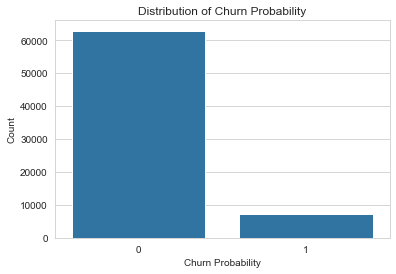

In [88]:

# Check the distribution of the target variable
class_distribution = Counter(y)
print("Class Distribution:", class_distribution)

# Plot the distribution
sns.countplot(x=y)
plt.title("Distribution of Churn Probability")
plt.xlabel("Churn Probability")
plt.ylabel("Count")
plt.show()

This code applies the `SMOTE (Synthetic Minority Over-sampling Technique)` to address class imbalance by generating synthetic samples for the minority class in the dataset.

In [89]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

This code snippet checks and visualizes the distribution of the target variable after applying SMOTE to ensure that the class imbalance has been addressed.

Class Distribution: Counter({0: 62867, 1: 62867})


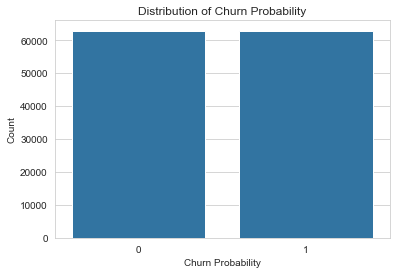

In [90]:
class_distribution = Counter(y_resampled )
print("Class Distribution:", class_distribution)

# Plot the distribution
sns.countplot(x=y_resampled)
plt.title("Distribution of Churn Probability")
plt.xlabel("Churn Probability")
plt.ylabel("Count")
plt.show()

<span style="color:blue">**Step 5: Model Training and Evaluation**</span>

In [91]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

This code snippet performs `Feature Scaling` and `Model Training` for a **logistic regression** model

In [92]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Logistic Regression with class weighting
logreg_model = LogisticRegression(class_weight='balanced', random_state=42)
logreg_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [93]:
# Predict and evaluate
y_pred = logreg_model.predict(X_test_scaled)
print("Logistic Regression - Classification Report:\n", classification_report(y_test, y_pred))
print("Logistic Regression - Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Logistic Regression - AUC-ROC:", roc_auc_score(y_test, logreg_model.predict_proba(X_test_scaled)[:, 1]))

Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89     19009
           1       0.88      0.90      0.89     18712

    accuracy                           0.89     37721
   macro avg       0.89      0.89      0.89     37721
weighted avg       0.89      0.89      0.89     37721

Logistic Regression - Confusion Matrix:
 [[16820  2189]
 [ 1883 16829]]
Logistic Regression - AUC-ROC: 0.9561818094041591


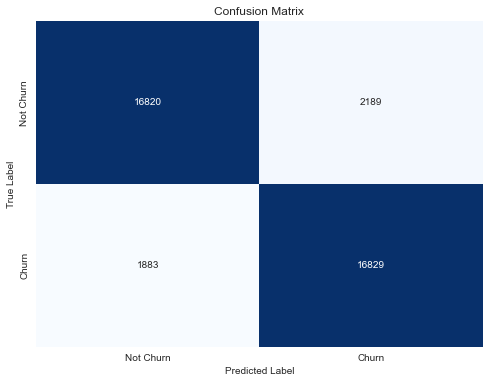

In [94]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The performance metrics for your Logistic Regression model look quite solid:

`Precision and Recall`: Both are well-balanced between the two classes (0 and 1), indicating that the model is equally good at identifying both churners and non-churners.
`F1-score`: Consistent across both classes, which is ideal for a balanced dataset.
`Accuracy`: The overall accuracy is 90%, which is a good result, showing that the model correctly predicts churn about 90% of the time.
`AUC-ROC`: A score of 0.95 is excellent, indicating that the model has a high ability to distinguish between the classes.

<span style="color:blue">**Model#2**</span>

We re moving from `Logistic Regression` to `XGBoost` to capture more complex, non-linear relationships in your data. XGBoost’s boosting technique improves accuracy by correcting errors over multiple iterations, and it automatically handles feature interactions. Additionally, XGBoost's regularization and flexible hyperparameter tuning help prevent overfitting, offering the potential for better predictive performance than Logistic Regression.

In [95]:
# Setting up a pipeline that first scales the features and then applies an XGBoost classifier.
# The GridSearchCV is used to perform cross-validation while tuning the hyperparameters, 
# such as the number of boosting rounds, tree depth, learning rate, and subsample ratio,
# to find the best model configuration for accuracy.


# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))  # XGBoost classifier
])

# Define hyperparameters to tune
param_grid = {
    'model__n_estimators': [100, 200],     # Number of boosting rounds
    'model__max_depth': [3, 6, 9],         # Maximum depth of a tree
    'model__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'model__subsample': [0.8, 1.0],        # Subsample ratio of the training instance
}

# Set up the GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=1)


In [96]:
# Fit the model with grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=1,
             param_grid={'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 6, 9],
                         'model__n_estimators': [100, 200],
                         'model__subsample': [0.8, 1.0]},
             scoring='accuracy')

In [97]:
# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("XGBoost - Classification Report:\n", classification_report(y_test, y_pred))
print("XGBoost - Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("XGBoost - AUC-ROC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

XGBoost - Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     19009
           1       0.97      0.97      0.97     18712

    accuracy                           0.97     37721
   macro avg       0.97      0.97      0.97     37721
weighted avg       0.97      0.97      0.97     37721

XGBoost - Confusion Matrix:
 [[18358   651]
 [  609 18103]]
XGBoost - AUC-ROC: 0.9951378789296068


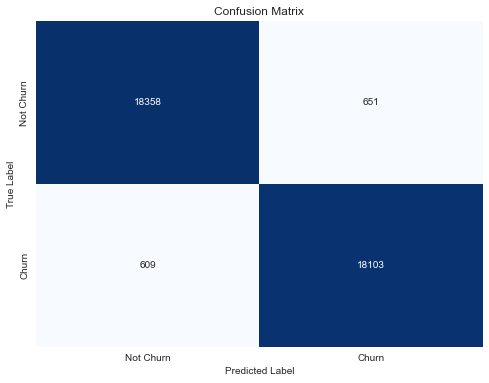

In [98]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The `XGBoost model` has achieved excellent performance with an accuracy of 97% and an AUC-ROC score of 0.995 on the validation set, indicating strong predictive power. The precision and recall are also well-balanced for both classes, which is crucial for a churn prediction model. Given these promising results, We are now ready to apply this model to the test or unseen data to make final predictions.

<span style="color:blue">**Load Test.csv**</span>

In [99]:
test_df = pd.read_csv('test.csv')

# Ensure test data has the same preprocessing steps applied as training data
test_df = test_df.rename(columns= lambda x: x.strip(), inplace=False)

# Apply the same preprocessing steps to test data (as done for train data)
# - Fill missing values (similar strategies as training data)
# - Feature scaling (using the scaler fitted on the training data)
# - Drop unnecessary columns (if any)
# Identify non-numeric columns in the test dataset


In [100]:
##Correcting name of 'last_day_rch_amt_*' to 'last_day_rech_amt_*' columns (for months 6,7,and 8)
test_df = test_df.rename(columns= {'last_day_rch_amt_6':'last_day_rech_amt_6', 'last_day_rch_amt_7':'last_day_rech_amt_7',\
                                     'last_day_rch_amt_8':'last_day_rech_amt_8'})
correct_last_day_rech_amt_cols = list(test_df.columns[test_df.columns.str.contains('last_day')])
correct_last_day_rech_amt_cols

['last_day_rech_amt_6', 'last_day_rech_amt_7', 'last_day_rech_amt_8']

In [101]:
# Handling missing values in test data (as done in training)
test_df['av_rech_amt_data_6'] = test_df['av_rech_amt_data_6'].fillna(0)
test_df['av_rech_amt_data_7'] = test_df['av_rech_amt_data_7'].fillna(0)
test_df['av_rech_amt_data_8'] = test_df['av_rech_amt_data_8'].fillna(0)

test_df['total_rech_data_6'] = test_df['total_rech_data_6'].fillna(0)
test_df['total_rech_data_7'] = test_df['total_rech_data_7'].fillna(0)
test_df['total_rech_data_8'] = test_df['total_rech_data_8'].fillna(0)

In [102]:
# Create total recharge amount for data columns if they were generated
test_df['total_rech_data_amt_6'] = test_df['av_rech_amt_data_6'] * test_df['total_rech_data_6']
test_df['total_rech_data_amt_7'] = test_df['av_rech_amt_data_7'] * test_df['total_rech_data_7']
test_df['total_rech_data_amt_8'] = test_df['av_rech_amt_data_8'] * test_df['total_rech_data_8']

In [103]:
test_df= remove_single_val_uniq_col(test_df)

Columns that are dropped are:
['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

Number of columns dropped:
13


In [104]:
##Since this is not a time-series based analysis, we might also eliminate date columns as they won't be useful for our analysis
date_columns_list= list(test_df.columns[test_df.columns.str.contains('date')])
date_columns_list

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [105]:
##Dropping the date columns
test_df.drop(date_columns_list, axis=1, inplace=True)
test_df.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0  69999   91.882   65.330   64.445        31.78        20.23        23.11   
1  70000  414.168  515.568  360.868        75.51        41.21        19.84   
2  70001  329.844  434.884  746.239         7.54         7.86         8.40   
3  70002   43.550  171.390   24.400         5.31         2.16         0.00   
4  70003  306.854  406.289  413.329       450.93       609.03       700.68   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  fb_user_6  fb_user_7  \
0         60.16         32.16         34.83  ...        NaN        NaN   
1        474.34        621.84        394.94  ...        NaN        NaN   
2         16.98         45.81         45.04  ...        NaN        NaN   
3         40.04        205.01         24.01  ...        NaN        NaN   
4         60.94         23.84         74.16  ...        NaN        NaN   

   fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  total_rech_data_amt_6  \
0        NaN  1692        0.00        0.00        0.00                    0.0   
1        NaN  2533        0.00        0.00        0.00                    0.0   
2        NaN   277      525.61      758.41      241.84                    0.0   
3        NaN  1244        0.00        0.00        0.00                    0.0   
4        NaN   462        0.00        0.00        0.00                    0.0   

   total_rech_data_amt_7  total_rech_data_amt_8  
0                    0.0                    0.0  
1                    0.0                    0.0  
2                    0.0                    0.0  
3                    0.0                    0.0  
4                    0.0                    0.0  

[5 rows x 155 columns]

In [106]:
##Imputing 'max_rech_data_*' columns with 0 (*columns: all 3 months - month 6, 7 and 8)
test_df[['max_rech_data_6','max_rech_data_7','max_rech_data_8']] = test_df[['max_rech_data_6','max_rech_data_7',\
                                                                                  'max_rech_data_8']].replace(np.nan, 0)

In [107]:
##Recheck for missing values in 'recharge' plans for calling and data features
all_rech_vars = list(test_df.columns[test_df.columns.str.contains('rech_amt|rech_data_amt|rech_num|max_rech_data')])  ##Excluding 2g_3g
all_rech = test_df[all_rech_vars]
null_prcnt_df(all_rech)

In [108]:
##Dropping 'arpu_2g', 'arpu_3g', 'count_rech_2g' and 'count_rech_3g' based features (revenue_based)
drop_vars = list(test_df.columns[test_df.columns.str.contains('arpu_2g|arpu_3g|count_rech_2g_|count_rech_3g')])
test_df.drop(drop_vars, axis=1, inplace=True)

In [109]:
##Volume Based Cost (vbc) based features
vbc_cols_list = list(test_df.columns[test_df.columns.str.contains('vbc')])
vbc_cols_list

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']

In [110]:
##Rename vbc features to the desired format ending with month number
test_df.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g': 'vbc_3g_7', 'aug_vbc_3g': 'vbc_3g_8'}, inplace=True)

In [111]:
##Recheck rename Volume Based Cost (vbc) based features
vbc_cols_list = list(test_df.columns[test_df.columns.str.contains('vbc')])
vbc_cols_list

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']

In [112]:
test_df[mou_cols] = test_df[mou_cols].replace(np.nan, 0)

In [113]:
##Reheck for missing value percentages in 'mou_cols'

mou_cols_df = test_df[mou_cols]
null_prcnt_df(mou_cols_df)

In [114]:
##Dropping 'loc_ic_mou', 'std_ic_mou' and 'total_ic_mou' for all 3 months
drop_ic_mou_features = list(test_df.columns[test_df.columns.str.contains('loc_ic_mou_|std_ic_mou_|total_ic_mou_')])
print('List of features dropped:\n', drop_ic_mou_features)

test_df.drop(drop_ic_mou_features, axis=1, inplace= True)

List of features dropped:
 ['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']


In [115]:
##Dropping 'loc_og_mou', 'std_og_mou' and 'total_og_mou' for all 3 months
drop_og_mou_features = list(test_df.columns[test_df.columns.str.contains('loc_og_mou_|std_og_mou_|total_og_mou_')])
print('List of features dropped:\n', drop_og_mou_features)

test_df.drop(drop_og_mou_features, axis=1, inplace= True)

List of features dropped:
 ['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']


In [116]:
offnet_usage_cols = list(test_df.columns[test_df.columns.str.contains('offnet.*mou')])
offnet_usage_cols

['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']

In [117]:
##Creating  a new column tenure_year to store the number of years the customer has been on network T
test_df['tenure_year'] = round(test_df['aon']/365, 1)

print(test_df.tenure_year.value_counts())
print("Min:",test_df.tenure_year.min())
print("Max:",test_df.tenure_year.max())

tenure_year
1.3     1418
0.6     1106
0.8     1049
1.0     1017
0.9     1002
        ... 
10.1       8
10.8       6
10.7       2
10.4       1
10.3       1
Name: count, Length: 103, dtype: int64
Min: 0.5
Max: 11.5


In [118]:
##Creating bins
my_bins = [0,1,2,3,5,12]
my_labels_aon= ['0_1_year','1_2_year','2_3_year','3_5_year','5_12_year']
test_df['tenure'] = pd.cut(test_df['tenure_year'], bins= my_bins, labels= my_labels_aon)

##Dropping 'tenure_year' and 'aon' column as we have already created bins in 'tenure' column
test_df.drop(['tenure_year','aon'] , axis=1, inplace= True)

test_df.tenure.value_counts()

tenure
1_2_year     7787
5_12_year    7296
0_1_year     5726
3_5_year     4784
2_3_year     4407
Name: count, dtype: int64

In [119]:
##Check for missing values in dataframe (show only missing value columns)
missing_val_cols_prcnt = round(100*test_df.isnull().sum()/len(test_df.index),2)
missing = pd.DataFrame(missing_val_cols_prcnt[missing_val_cols_prcnt!=0].sort_values(ascending=False))  #Descending order(% NaN)
missing.reset_index(inplace=True)
missing= missing.rename(columns={'index':'features',0:'Null_Percentage'})
missing

features  Null_Percentage
0   night_pck_user_6            74.72
1          fb_user_6            74.72
2   night_pck_user_7            74.31
3          fb_user_7            74.31
4   night_pck_user_8            73.59
5          fb_user_8            73.59
6        og_others_8             5.58
7        ic_others_8             5.58
8        og_others_7             3.91
9        ic_others_7             3.91
10       og_others_6             3.90
11       ic_others_6             3.90

In [120]:
##Dropping 'fb_user_*' and 'night_pck_user_*' features
cols_to_drop = ['fb_user_6', 'fb_user_7', 'fb_user_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']
test_df.drop(cols_to_drop, axis=1, inplace= True)

In [121]:
##Imputing 'ic_others' and 'og_others' with 0 (<=3.91% missing values)
cols_to_impute = test_df.columns[test_df.columns.str.contains('ic_others|og_others')]
test_df[cols_to_impute] = test_df[cols_to_impute].replace(np.nan, 0)

In [122]:
null_prcnt_df(test_df)

In [123]:
test_df.shape

(30000, 119)

In [124]:
##Checking categorical column 'tenure'
test_df.tenure.head()

0     3_5_year
1    5_12_year
2     0_1_year
3     3_5_year
4     1_2_year
Name: tenure, dtype: category
Categories (5, object): ['0_1_year' < '1_2_year' < '2_3_year' < '3_5_year' < '5_12_year']

In [125]:
#'tenure' is a categorical variable. Converting it into numeric using get_dummies
###Creating dummies for categorical variable 'tenure'
cat_cols= ['tenure']
d_tenure = pd.get_dummies(test_df['tenure'], prefix='tenure', drop_first = True)
d_tenure = d_tenure.astype(int)
test_df = pd.concat([test_df, d_tenure], axis = 1)

##Dropping the 'tenure' column
test_df.drop(cat_cols, axis=1, inplace=True)

In [126]:
test_df.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0  69999   91.882   65.330   64.445        31.78        20.23        23.11   
1  70000  414.168  515.568  360.868        75.51        41.21        19.84   
2  70001  329.844  434.884  746.239         7.54         7.86         8.40   
3  70002   43.550  171.390   24.400         5.31         2.16         0.00   
4  70003  306.854  406.289  413.329       450.93       609.03       700.68   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  vbc_3g_8  vbc_3g_7  \
0         60.16         32.16         34.83  ...      0.00      0.00   
1        474.34        621.84        394.94  ...      0.00      0.00   
2         16.98         45.81         45.04  ...    525.61    758.41   
3         40.04        205.01         24.01  ...      0.00      0.00   
4         60.94         23.84         74.16  ...      0.00      0.00   

   vbc_3g_6  total_rech_data_amt_6  total_rech_data_amt_7  \
0      0.00                    0.0                    0.0   
1      0.00                    0.0                    0.0   
2    241.84                    0.0                    0.0   
3      0.00                    0.0                    0.0   
4      0.00                    0.0                    0.0   

   total_rech_data_amt_8  tenure_1_2_year  tenure_2_3_year  tenure_3_5_year  \
0                    0.0                0                0                1   
1                    0.0                0                0                0   
2                    0.0                0                0                0   
3                    0.0                0                0                1   
4                    0.0                1                0                0   

   tenure_5_12_year  
0                 0  
1                 1  
2                 0  
3                 0  
4                 0  

[5 rows x 122 columns]

<span style="color:blue">**Step 6: Making Prediction on Unseen (Test.csv) data**</span>
This code finalizes the prediction process by applying the trained model to the unseen test data. It scales the test features using the same scaler from training, predicts the churn probabilities, and then converts these probabilities to binary outcomes (0 or 1) based on a 0.5 threshold. The results, along with the customer IDs, are saved to a `CSV file for submission`.

In [127]:
# Create solution dataframe for unseen data
X_test_unseen_scaled = best_model.named_steps['scaler'].transform(test_df.drop(columns=['id']))
churn_probabilities = best_model.named_steps['model'].predict_proba(X_test_unseen_scaled)[:, 1]

# Convert probabilities to binary classifications with a threshold of 0.5
churn_probabilities = (churn_probabilities >= 0.5).astype(int)

solution_df = pd.DataFrame({
    'id': test_df['id'],
    'churn_probability': churn_probabilities
})

solution_df.to_csv('Submission.csv', index=False)